<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/UK/RDSA/RDSA_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "RDSBGBGBX"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-07-25 05:11:49,573 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-07-25 05:11:49,577 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for RDSBGBGBX
2019-07-25 05:14:45,590 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-07-25 05:20:44,031 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-07-25 05:23:49,571 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-07-25 05:26:51,542 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-07-25 05:30:00,180 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-07-25 05:33:04,250 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-07-25 05:36:13,256 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-07-25 05:39:21,702 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-07-25 05:48:54,698 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_RDSBGBGBX__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-RDSBGBGBX__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-RDSBGBGBX to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open       High        Low      Close    Volume
Date                                                                     
2018-01-02 08:00:00  25.004971  25.004971  24.784969  24.859980  0.498269
2018-01-02 09:00:00  24.854980  25.029980  24.829969  25.029970  0.999567
2018-01-02 10:00:00  25.029980  25.044979  24.944969  24.959970  0.943823
2018-01-02 11:00:00  24.959980  24.994980  24.934971  24.994980  0.795009
2018-01-02 12:00:00  24.994970  25.004980  24.949970  24.964970  0.569445
...                        ...        ...        ...        ...       ...
2018-12-31 08:00:00  23.349970  23.389980  23.209970  23.344971  0.702117
2018-12-31 09:00:00  23.344980  23.469980  23.294970  23.459980  0.666507
2018-12-31 10:00:00  23.459970  23.524981  23.449970  23.504971  0.599672
2018-12-31 11:00:00  23.499969  23.514980  23.314970  23.324980  0.730618
2018-12-31 12:00:00  23.324970  23.374981  23.299971  23.309971  0.526979

[2257 rows x 5 columns]

Open         High          Low        Close       Volume
count  2257.000000  2257.000000  2257.000000  2257.000000  2257.000000
mean     25.193155    25.263521    25.125668    25.195745     1.481361
std       1.538035     1.539311     1.538692     1.540363     0.896452
min      21.999981    22.034981    21.934971    21.994970     0.195039
25%      23.939970    24.019979    23.824970    23.934971     0.881005
50%      25.479980    25.544979    25.399969    25.484980     1.206775
75%      26.484970    26.549980    26.404970    26.489981     1.863210
max      28.404980    28.439980    28.364969    28.424980     8.105173

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open       High        Low      Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08      SMA_8     TEMA_8    TRIMA_8      WMA_8     MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  25.729971  25.754971  25.704969  25.709980  0.812909    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  25.679487  25.328382  25.559866  25.707496  25.665812  25.602915   25.659975   25.649970  25.572683  25.648100  25.721698  25.644225  25.674976  25.648100  25.716643  25.596646               25.764608                25.648100               25.531591               25.822863                25.648100               25.473337               25.881117                25.648100               25.415083               25.939371                25.648100               25.356828  25.665812  25.705042  25.603398               25.782320                25.665812               25.549303               25.840575                25.665812               25.491049               25.898829                25.665812               25.432795               25.957083   
2018-01-09 14:00:00  25.709970  25.759979  25.624969  25.634979  2.180358    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  25.676788  25.338945  25.579377  25.686052  25.658960  25.603693   25.659975   25.652474  25.587266  25.654351  25.685748  25.664476  25.672061  25.654351  25.672480  25.604473               25.761642                25.654351               25.547060               25.815287                25.654351               25.493415               25.868933                25.654351               25.439769               25.922578                25.654351               25.386124  25.658960  25.660778  25.611576               25.766251                25.658960               25.551669               25.819897                25.658960               25.498024               25.873542                25.658960               25.444378               25.927188   
2018-01-09 15:00:00  25.629971  25.689980  25.619970  25.6

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000    2207.000000  2207.000000   2207.000000     2207.000000     2207.000000       2207.000000  2207.000000  2207.000000  2207.000000  2207.000000   2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000  2207.000000  2207.000000  2207.000000             2207.000000              2207.000000             2207.000000             2207.000000              2207.000000             2207.000000             2207.000000   
mean     25.188725    25.259598    25.120552    25.191149     1.485657    15.895333     2.038061   185.700952      30.419574    11.384232      0.034436        0.028092        0.002266          0.004078     6.609425     2.537381    26.976892     2.038061      1.975986    26.976892    25.196901    25.205392     1.916221    25.191061    25.194864    25.194597    25.191557    25.188535    25.185997    25.194802    25.191208    25.194797    25.193596    25.194802    25.192744    25.202615               25.411177                25.194802               24.978427               25.519365                25.194802               24.870239               25.627553                25.194802               24.762051               25.735740                25.194802               24.653864    25.194864    25.192186    25.201393               25.411239                25.194864               24.978488               25.519427                25.194864               24.870301               25.627614   
std       1.554617     1.555994     1.555176     1.556960     0.900984     8.583567     1.403080   102.265743       0.856280     2.616824      0.182387        0.165274        0.047554          0.063743     3.364615     1.107681    14.610349     1.403080      1.398375    14.610349     1.544175     1.521229    25.166051     1.559292     1.547716     1.543095     1.551364     1.549708     1.557299     1.550318     1.558215     1.551454     1.551666     1.550318     1.554932     1.536961                1.559100                 1.550318                1.551663                1.567242                 1.550318                1.556133                1.577839                 1.550318                1.563109                1.590840                 1.550318                1.572559     1.547716     1.554491     1.539020                1.556385                 1.547716                1.549191                1.564479                 1.547716                1.553731                1.575032   
min      21.999981    22.034981    21.9349

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.582356  0.580795  0.586314  0.577761  0.078111    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.576900  0.524916  0.951909  0.576802  0.573300  0.567445    0.572677    0.572460  0.559217  0.570112  0.580890  0.568590  0.574016  0.570112  0.579605  0.565167                0.551328                 0.570112                0.573382                0.531388                 0.570112                0.578900                0.511066                 0.570112                0.584573                0.492303                 0.570112                0.590774  0.573300  0.577903  0.565268                0.560044                 0.573300                0.582859                0.540001                 0.573300                0.588937                0.518942                 0.573300                0.595159                0.499100                 0.573300   
2018-01-09 14:00:00  0.579233  0.581577  0.573872  0.566097  0.250984    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.576466  0.526696  0.952253  0.573473  0.572205  0.567571    0.572677    0.572863  0.561459  0.571103  0.575330  0.571783  0.573555  0.571103  0.572711  0.566451                0.550876                 0.571103                0.575811                0.530282                 0.571103                0.582008                0.509360                 0.571103                0.588339                0.490047                 0.571103                0.595172  0.572205  0.570976  0.566604                0.557553                 0.572205                0.583231                0.536923                 0.572205                0.590017                0.515338                 0.572205                0.596924                0.495018                 0.572205   
2018-01-09 15:00:00  0.566743  0.570648  

139619

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpw6pxxrno
  JVM stdout: /tmp/tmpw6pxxrno/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpw6pxxrno/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_x2dqvc
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.543152  0.688858              0.490099  0.497856  0.247860
1  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.543069  0.697315              0.477063  0.502078  0.252083
2              DeepLearning_1_AutoML_20190725_055731  0.517574  0.727471              0.494266  0.515533  0.265774
3  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.513614  4.164819              0.490099  0.710584  0.504929
4  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.505817  0.711258              0.479414  0.508859  0.258938
5  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.500000  0.691092              0.500000  0.498972  0.248973
6  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.500000  0.690089              0.500000  0.498470  0.248472
7  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.480776  0.731919              0.490099  0.517861  0.268180
8  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.460066  0.713762              0.462211  0.509470  0.259560
9  DeepLearning_grid_1_AutoML_20190725_055731_mod...  0.439604  1.146191              0.500000  0.625166  0.390833

variable  relative_importance  scaled_importance  percentage
0          STOCHRSI_fastk             1.000000           1.000000    0.001218
1            HT_TRENDMODE             0.994617           0.994617    0.001211
2             aroondown_8             0.976463           0.976463    0.001189
3                   DX_14             0.971780           0.971780    0.001183
4                  SAREXT             0.950155           0.950155    0.001157
...                   ...                  ...                ...         ...
1030            MAVP_14_4             0.694913           0.694913    0.000846
1031            CDLHARAMI             0.694537           0.694537    0.000846
1032           CDL3INSIDE             0.694272           0.694272    0.000845
1033       CDLHARAMICROSS             0.671649           0.671649    0.000818
1034  CDLRISEFALL3METHODS             0.646749           0.646749    0.000788

[1035 rows x 4 columns]

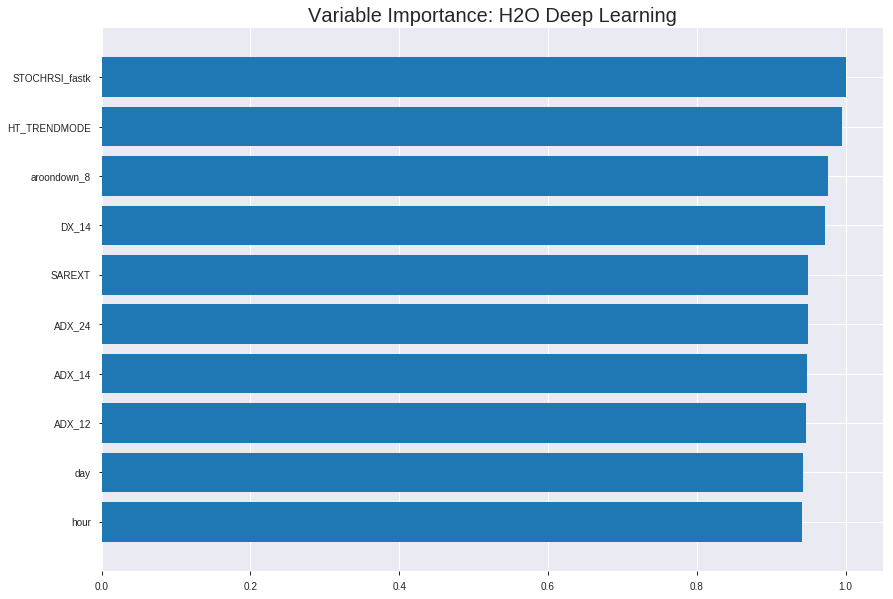

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_055731_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24695828215636403
RMSE: 0.4969489733930075
LogLoss: 0.6867953946760623
Mean Per-Class Error: 0.4778431487909631
AUC: 0.5255112246698997
pr_auc: 0.5548680843480145
Gini: 0.05102244933979949
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4321239534848829: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   710   0.9608   (710.0/739.0)
1      5    800   0.0062   (5.0/805.0)
Total  34   1510  0.4631   (715.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432124     0.691145  366
max f2                       0.358557     0.845992  376
max f0point5                 0.481383     0.584864  356
max accuracy                 0.488185     0.538212  354
max precision                0.744952     1         0
max recall                   0.226981     1         396
max specificity              0.744952     1         0
max absolute_mcc             0.432124     0.112438  366
max min_per_class_accuracy   0.502865     0.403727  324
max mean_per_class_accuracy  0.506215     0.522157  306

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.643105           1.43851   1.43851            0.75             0.667178  0.75                        0.667178            0.0149068       0.0149068                  43.8509    43.8509
    2        0.0200777                   0.56856            1.40654   1.42304            0.733333         0.599753  0.741935                    0.634553            0.0136646       0.0285714                  40.6542    42.3041
    3        0.0304404                   0.55387            1.43851   1.42831            0.75             0.556592  0.744681                    0.608013            0.0149068       0.0434783                  43.8509    42.8307
    4        0.0401554                   0.552088           0.639337  1.23743            0.333333         0.552818  0.645161                    0.594659            0.00621118      0.0496894                  -36.0663   23.7427
    5        0.0505181                   0.54946            1.19876   1.2295             0.625            0.550796  0.641026                    0.585662            0.0124224       0.0621118                  19.8758    22.9495
    6        0.100389                    0.542863           1.0711    1.15081            0.558442         0.544893  0.6                         0.565409            0.0534161       0.115528                   7.10978    15.0807
    7        0.150259                    0.539166           0.871824  1.05821            0.454545         0.540927  0.551724                    0.557283            0.0434783       0.159006                   -12.8176   5.82138
    8        0.20013                     0.535726           0.946552  1.03039            0.493506         0.537438  0.537217                    0.552338            0.047205        0.206211                   -5.34484   3.03886
    9        0.29987                     0.517328           0.99637   1.01907            0.519481         0.527507  0.531317                    0.544079            0.0993789       0.30559                    -0.362991  1.90736
    10       0.930052                    0.49877            1.01124   1.01377            0.527235         0.500293  0.528552                    0.514411            0.637267        0.942857                   1.1244     1.37684
    11       1                           0.193265           0.816931  1                  0.425926         0.435206  0.521373                    0.50887             0.0571429       1                          -18.3069   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24811813195705293
RMSE: 0.4981145771376832
LogLoss: 0.6893658030637452
Mean Per-Class Error: 0.43727302740178275
AUC: 0.5366251238032353
pr_auc: 0.5625444780584129
Gini: 0.0732502476064707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47686182100822394: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    200  0.9615   (200.0/208.0)
1      1    232  0.0043   (1.0/233.0)
Total  9    432  0.4558   (201.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476862     0.697744  294
max f2                       0.457925     0.852231  297
max f0point5                 0.476862     0.591535  294
max accuracy                 0.514261     0.55102   130
max precision                0.52716      0.657895  37
max recall                   0.457925     1         297
max specificity              0.597944     0.995192  0
max absolute_mcc             0.514261     0.13705   130
max min_per_class_accuracy   0.507092     0.504808  220
max mean_per_class_accuracy  0.514261     0.562727  130

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.578864           1.13562   1.13562            0.6              0.588934  0.6                         0.588934            0.0128755       0.0128755                  13.5622   13.5622
    2        0.0204082                   0.568673           0.946352  1.0515             0.5              0.571835  0.555556                    0.581335            0.00858369      0.0214592                  -5.36481  5.15021
    3        0.031746                    0.552208           1.13562   1.08155            0.6              0.561173  0.571429                    0.574134            0.0128755       0.0343348                  13.5622   8.15451
    4        0.0408163                   0.539904           1.41953   1.15665            0.75             0.54223   0.611111                    0.567044            0.0128755       0.0472103                  41.9528   15.6652
    5        0.0521542                   0.528945           0.757082  1.06979            0.4              0.53222   0.565217                    0.559474            0.00858369      0.055794                   -24.2918  6.97891
    6        0.102041                    0.526086           1.29048   1.17768            0.681818         0.527537  0.622222                    0.54386             0.0643777       0.120172                   29.048    17.7682
    7        0.151927                    0.52074            1.20445   1.18647            0.636364         0.523618  0.626866                    0.537213            0.0600858       0.180258                   20.4448   18.6471
    8        0.201814                    0.518832           1.03238   1.14838            0.545455         0.519694  0.606742                    0.532883            0.0515021       0.23176                    3.23839   14.8382
    9        0.301587                    0.514244           1.24746   1.18116            0.659091         0.516315  0.62406                     0.527402            0.124464        0.356223                   24.7464   18.1161
    10       0.401361                    0.51139            0.731272  1.06932            0.386364         0.512864  0.564972                    0.523788            0.0729614       0.429185                   -26.8728  6.93242
    11       0.501134                    0.507092           0.774288  1.01058            0.409091         0.50916   0.533937                    0.520875            0.0772532       0.506438                   -22.5712  1.0584
    12       0.600907                    0.501763           0.903336  0.992777           0.477273         0.504775  0.524528                    0.518202            0.0901288       0.596567                   -9.66641  -0.722326
    13       0.93424                     0.49877            1.05579   1.01526            0.557823         0.498829  0.536408                    0.51129             0.351931        0.948498                   5.5794    1.52611
    14       1                           0.392908           0.783188  1                  0.413793         0.473633  0.528345                    0.508814            0.0515021       1                          -21.6812  0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:10:35  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:10:37  7 min 22.808 sec   333 obs/sec       0.411917  1             636        0.677352         2.96526             -0.838582      0.509799        0.501542           1.07888          0.478627                         0.623566           1.77787               -0.560354        0.532767          0.544961             0.757082           0.471655
    2019-07-25 06:11:04  7 min 49.846 sec   453 obs/sec       7.7785    18            12010      0.499879         0.692827            -0.00134709    0.513317        0.528089           1.19876          0.473446                         0.499923           0.693039              -0.00291664      0.510214          0.511808             0.757082           0.45805
    2019-07-25 06:11:30  8 min 15.610 sec   483 obs/sec       15.5635   36            24030      0.497196         0.687437            0.00937451     0.538733        0.56968            1.43851          0.467617                         0.498915           0.690979              0.00112541       0.527072          0.563004             1.13562            0.469388
    2019-07-25 06:11:55  8 min 41.109 sec   505 obs/sec       23.8031   55            36752      0.496949         0.686795            0.0103586      0.525511        0.554868           1.43851          0.463083                         0.498115           0.689366              0.0043277        0.536625          0.562544             1.13562            0.455782
    2019-07-25 06:12:20  9 min  6.248 sec   548 obs/sec       33.8484   78            52262      0.495357         0.683473            0.0166895      0.548075        0.580869           1.67826          0.463083                         0.500278           0.693782              -0.00434025      0.498494          0.522629             1.13562            0.462585
    2019-07-25 06:12:46  9 min 32.241 sec   592 obs/sec       45.5952   105           70399      0.494997         0.68256             0.0181161      0.5388          0.622204           1.67826          0.455959                         0.500152           0.693542              -0.00383432      0.46614           0.505148             0.757082           0.471655
    2019-07-25 06:13:12  9 min 58.154 sec   637 obs/sec       58.647    135           90551      0.494916         0.682244            0.0184406      0.528045        0.56251            1.79814          0.457902                         0.499784           0.692725              -0.00235635      0.514289          0.539053             0.757082           0.469388
    2019-07-25 06:13:15  10 min  0.798 sec  636 obs/sec       58.647    135           90551      0.496949         0.686795            0.0103586      0.525511        0.554868           1.43851          0.463083                         0.498115           0.689366              0.0043277        0.536625          0.562544             1.13562            0.455782

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ---------------------
STOCHRSI_fastk       1.0                    1.0                  0.001217706211854499
HT_TRENDMODE         0.994616687297821      0.994616687297821    0.0012111509185367005
aroondown_8          0.9764626026153564     0.9764626026153564   0.0011890445768483306
DX_14                0.9717800617218018     0.9717800617218018   0.0011833426177149864
SAREXT               0.9501554369926453     0.9501554369926453   0.00115701017785327
---                  ---                    ---                  ---
MAVP_14_4            0.694912850856781      0.694912850856781    0.0008461996951858212
CDLHARAMI            0.6945372223854065     0.6945372223854065   0.0008457422900628791
CDL3INSIDE           0.6942720413208008     0.6942720413208008   0.0008454193774332426
CDLHARAMICROSS       0.6716487407684326     0.6716487407684326   0.0008178708438179725
CDLRISEFALL3METHODS  0.6467490792274475     0.6467490792274475   0.0007875503712864403


See the whole table with table.as_data_frame()


('accuracy', 0.5701357466063348)

('F1', 0.7079646017699115)

('auc', 0.5431518151815181)

('logloss', 0.6888579491814165)

('mean_per_class_error', 0.4381600660066006)

('rmse', 0.49785568913313194)

('mse', 0.2478602872022257)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


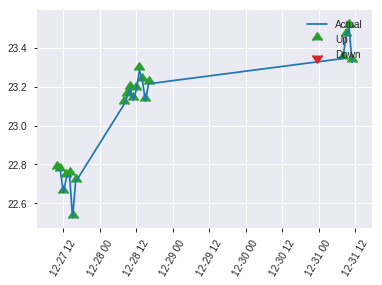


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2478602872022257
RMSE: 0.49785568913313194
LogLoss: 0.6888579491814165
Mean Per-Class Error: 0.4381600660066006
AUC: 0.5431518151815181
pr_auc: 0.5825515990100211
Gini: 0.08630363036303623
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5053102962895148: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    99   0.9802   (99.0/101.0)
1      0    120  0        (0.0/120.0)
Total  2    219  0.448    (99.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50531      0.707965  218
max f2                       0.50531      0.858369  218
max f0point5                 0.526001     0.606936  142
max accuracy                 0.527338     0.570136  132
max precision                0.549354     1         0
max recall                   0.50531      1         218
max specificity              0.549354     1         0
max absolute_mcc             0.527338     0.125859  132
max min_per_class_accuracy   0.53023      0.544554  111
max mean_per_class_accuracy  0.527338     0.56184   132

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 53.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.548056           1.22778   1.22778            0.666667         0.548904  0.666667                    0.548904            0.0166667       0.0166667                  22.7778   22.7778
    2        0.0226244                   0.547583           0.920833  1.105              0.5              0.547797  0.6                         0.548461            0.00833333      0.025                      -7.91667  10.5
    3        0.0316742                   0.547228           0.920833  1.05238            0.5              0.547303  0.571429                    0.54813             0.00833333      0.0333333                  -7.91667  5.2381
    4        0.040724                    0.547202           1.84167   1.22778            1                0.547213  0.666667                    0.547926            0.0166667       0.05                       84.1667   22.7778
    5        0.0542986                   0.546708           1.22778   1.22778            0.666667         0.547003  0.666667                    0.547696            0.0166667       0.0666667                  22.7778   22.7778
    6        0.104072                    0.544754           1.00455   1.12101            0.545455         0.545788  0.608696                    0.546783            0.05            0.116667                   0.454545  12.1014
    7        0.153846                    0.543485           1.00455   1.08333            0.545455         0.544109  0.588235                    0.545918            0.05            0.166667                   0.454545  8.33333
    8        0.20362                     0.541031           1.50682   1.18685            0.818182         0.542158  0.644444                    0.544999            0.075           0.241667                   50.6818   18.6852
    9        0.303167                    0.537101           0.753409  1.04453            0.409091         0.538864  0.567164                    0.542984            0.075           0.316667                   -24.6591  4.45274
    10       0.402715                    0.533458           1.17197   1.07603            0.636364         0.535327  0.58427                     0.541092            0.116667        0.433333                   17.197    7.603
    11       0.502262                    0.530615           1.08826   1.07845            0.590909         0.532054  0.585586                    0.5393              0.108333        0.541667                   8.82576   7.84535
    12       0.60181                     0.527338           1.17197   1.09392            0.636364         0.528882  0.593985                    0.537577            0.116667        0.658333                   17.197    9.39223
    13       0.701357                    0.524457           0.753409  1.04559            0.409091         0.525707  0.567742                    0.535892            0.075           0.733333                   -24.6591  4.55914
    14       0.800905                    0.521762           0.585985  0.988465           0.318182         0.523489  0.536723                    0.534351            0.0583333       0.791667                   -41.4015  -1.15348
    15       0.900452                    0.513255           1.08826   0.999497           0.590909         0.517425  0.542714                    0.532479            0.108333        0.9                        8.82576   -0.0502513
    16       1                           0.504095           1.00455   1                  0.545455         0.507579  0.542986                    0.530001           

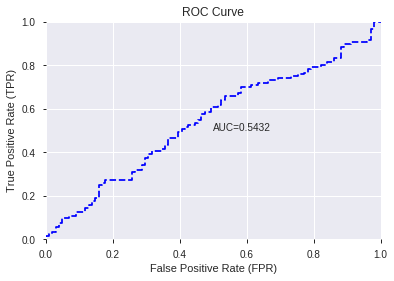

This function is available for GLM models only


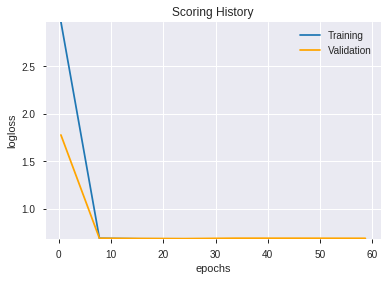

--2019-07-25 06:25:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.65.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.65.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_055731_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_055731_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190725_062552  0.551238  0.727563              0.495050  0.512492  0.262648
1  DeepLearning_grid_1_AutoML_20190725_062552_model_1  0.528960  1.346123              0.488531  0.598901  0.358683
2  DeepLearning_grid_1_AutoML_20190725_062552_model_4  0.509818  0.859070              0.495050  0.545773  0.297868
3  DeepLearning_grid_1_AutoML_20190725_062552_model_8  0.502723  0.695474              0.490099  0.501161  0.251163
4  DeepLearning_grid_1_AutoML_20190725_062552_model_9  0.500330  0.689954              0.500000  0.498401  0.248404
5  DeepLearning_grid_1_AutoML_20190725_062552_model_2  0.488201  1.245003              0.490099  0.604414  0.365316
6  DeepLearning_grid_1_AutoML_20190725_062552_model_3  0.486304  0.986046              0.500000  0.579201  0.335474
7  DeepLearning_grid_1_AutoML_20190725_062552_model_6  0.483911  0.698327              0.484365  0.502515  0.252521
8  DeepLearning_grid_1_AutoML_20190725_062552_model_7  0.483251  0.733552              0.467946  0.518084  0.268411
9  DeepLearning_grid_1_AutoML_20190725_062552_model_5  0.474752  0.712161              0.500000  0.508468  0.258540

variable  relative_importance  scaled_importance  percentage
0                 ADX_20             1.000000           1.000000    0.026463
1             weekofyear             0.997755           0.997755    0.026403
2                NATR_30             0.956597           0.956597    0.025314
3            AROONOSC_12             0.938396           0.938396    0.024832
4                  VAR_8             0.926891           0.926891    0.024528
5              dayofyear             0.914966           0.914966    0.024212
6                   SINH             0.903611           0.903611    0.023912
7           weekday_name             0.901917           0.901917    0.023867
8              CORREL_12             0.899415           0.899415    0.023801
9                  DX_20             0.881000           0.881000    0.023314
10                 DX_30             0.872404           0.872404    0.023086
11          HT_TRENDMODE             0.854407           0.854407    0.022610
12                ATR_20             0.836567           0.836567    0.022138
13               NATR_12             0.825783           0.825783    0.021852
14                ADX_12             0.824999           0.824999    0.021832
15          aroondown_12             0.817734           0.817734    0.021639
16             CORREL_14             0.811859           0.811859    0.021484
17                   DIV             0.807079           0.807079    0.021357
18         days_in_month             0.806234           0.806234    0.021335
19                  hour             0.788767           0.788767    0.020873
20               BETA_12             0.788647           0.788647    0.020870
21                  week             0.780545           0.780545    0.020655
22                 MFI_8             0.773880           0.773880    0.020479
23                   OBV             0.771960           0.771960    0.020428
24                  DX_8             0.767240           0.767240    0.020303
25          STOCHF_fastk             0.758355           0.758355    0.020068
26               ADXR_14             0.755506           0.755506    0.019993
27                 DX_24             0.754797           0.754797    0.019974
28                   day             0.740839           0.740839    0.019605
29                 month             0.726060           0.726060    0.019213
30                ADX_14             0.715589           0.715589    0.018936
31            AROONOSC_8             0.708619           0.708619    0.018752
32                 DX_14             0.698957           0.698957    0.018496
33  HT_PHASOR_quadrature             0.695759           0.695759    0.018412
34                ATR_30             0.692164           0.692164    0.018316
35                   BOP             0.673481           0.673481    0.017822
36                 DX_12             0.665762           0.665762    0.017618
37            aroonup_24             0.665407           0.665407    0.017608
38        STOCHRSI_fastd             0.656605           0.656605    0.017375
39           HT_DCPERIOD             0.624068           0.624068    0.016514
40                SAREXT             0.621705           0.621705    0.016452
41              CORREL_8             0.609904           0.609904    0.016140
42        STOCHRSI_fastk             0.609578           0.609578    0.016131
43                   COS             0.602000           0.602000    0.015930
44               ADXR_12             0.595439           0.595439    0.015757
45          aroondown_14             0.593903           0.593903    0.015716
46           aroondown_8             0.576274           0.576274    0.015250
47     HT_PHASOR_inphase             0.564627           0.564627    0.014941
48                ADX_24             0.556173           0.556173    0.014718
49        MACDEXT_signal             0.478952           0.478952    0.012674

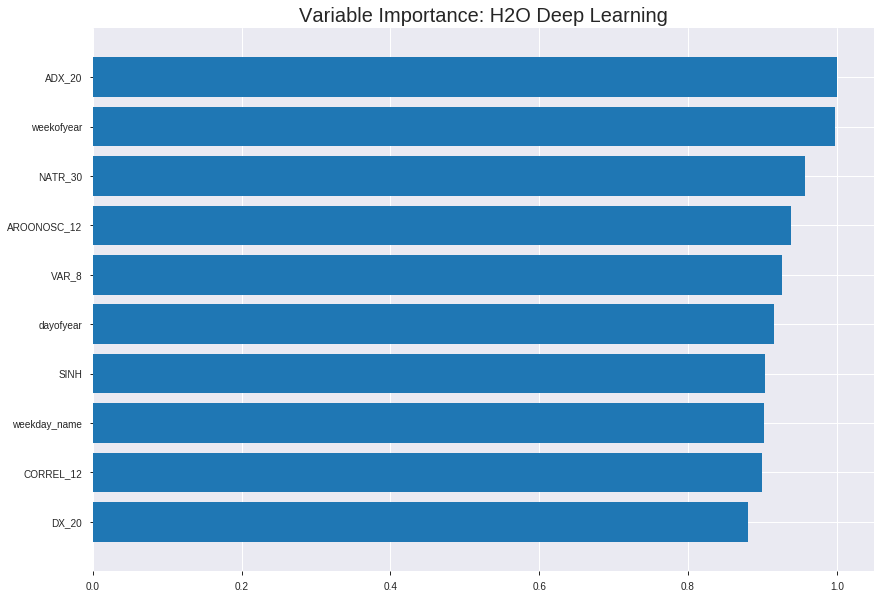

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190725_062552


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25601894979392176
RMSE: 0.5059831516897788
LogLoss: 0.7105129108795065
Mean Per-Class Error: 0.4162532883954311
AUC: 0.6074710663226284
pr_auc: 0.6211908529452989
Gini: 0.21494213264525674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16574913896586746: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      63   676   0.9147   (676.0/739.0)
1      22   783   0.0273   (22.0/805.0)
Total  85   1459  0.4521   (698.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.165749     0.691696  360
max f2                       0.0937174    0.845782  390
max f0point5                 0.26837      0.606911  297
max accuracy                 0.416898     0.582902  191
max precision                0.855455     1         0
max recall                   0.0492814    1         398
max specificity              0.855455     1         0
max absolute_mcc             0.26837      0.172211  297
max min_per_class_accuracy   0.407212     0.576455  199
max mean_per_class_accuracy  0.416898     0.583747  191

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 40.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.751866           1.79814   1.79814            0.9375           0.792971  0.9375                      0.792971            0.0186335       0.0186335                  79.8137   79.8137
    2        0.0200777                   0.69129            1.79014   1.79427            0.933333         0.71742   0.935484                    0.756414            0.0173913       0.0360248                  79.0145   79.427
    3        0.0304404                   0.664754           1.43851   1.67316            0.75             0.675727  0.87234                     0.728946            0.0149068       0.0509317                  43.8509   67.316
    4        0.0401554                   0.645326           1.53441   1.63959            0.8              0.655646  0.854839                    0.711212            0.0149068       0.0658385                  53.441    63.9591
    5        0.0505181                   0.630745           0.959006  1.49998            0.5              0.638244  0.782051                    0.696244            0.00993789      0.0757764                  -4.09938  49.9984
    6        0.100389                    0.595743           0.921642  1.21268            0.480519         0.611319  0.632258                    0.654056            0.0459627       0.121739                   -7.83577  21.2679
    7        0.150259                    0.56069            1.27037   1.23183            0.662338         0.579169  0.642241                    0.629201            0.063354        0.185093                   27.0372   23.1827
    8        0.20013                     0.535945           1.12092   1.20419            0.584416         0.548751  0.627832                    0.609154            0.0559006       0.240994                   12.0916   20.4189
    9        0.29987                     0.492515           1.17073   1.19306            0.61039          0.512989  0.62203                     0.577168            0.11677         0.357764                   17.0735   19.3062
    10       0.400259                    0.448422           1.11368   1.17315            0.580645         0.470426  0.61165                     0.550396            0.111801        0.469565                   11.3685   17.3153
    11       0.5                         0.409705           1.04619   1.14783            0.545455         0.428357  0.598446                    0.526051            0.104348        0.573913                   4.61886   14.7826
    12       0.599741                    0.36927            0.971461  1.1185             0.506494         0.388337  0.583153                    0.503149            0.0968944       0.670807                   -2.85392  11.8495
    13       0.70013                     0.321029           0.928071  1.09119            0.483871         0.346466  0.568918                    0.480682            0.0931677       0.763975                   -7.19295  9.11912
    14       0.79987                     0.262447           1.02128   1.08247            0.532468         0.293001  0.564372                    0.457279            0.101863        0.865839                   2.12793   8.24734
    15       0.899611                    0.206172           0.67255   1.03702            0.350649         0.237157  0.540677                    0.432874            0.0670807       0.932919                   -32.745   3.70247
    16       1                           0.0410704          0.668211  1                  0.348387         0.152208  0.521373                    0.404698           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2883252997246152
RMSE: 0.5369593091888949
LogLoss: 0.7896858270723608
Mean Per-Class Error: 0.47083402112908557
AUC: 0.489125949158138
pr_auc: 0.5354051817282992
Gini: -0.021748101683723986
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0678513691099972: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    207  0.9952   (207.0/208.0)
1      0    233  0        (0.0/233.0)
Total  1    440  0.4694   (207.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0678514    0.692422  398
max f2                       0.0678514    0.849125  398
max f0point5                 0.0678514    0.584546  398
max accuracy                 0.0678514    0.530612  398
max precision                0.966791     1         0
max recall                   0.0678514    1         398
max specificity              0.966791     1         0
max absolute_mcc             0.141599     0.118403  382
max min_per_class_accuracy   0.424392     0.467811  197
max mean_per_class_accuracy  0.518727     0.529166  100

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 42.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.828186           1.13562   1.13562            0.6              0.891283  0.6                         0.891283            0.0128755       0.0128755                  13.5622   13.5622
    2        0.0204082                   0.763866           1.41953   1.2618             0.75             0.780513  0.666667                    0.842052            0.0128755       0.0257511                  41.9528   26.1803
    3        0.031746                    0.742503           0.757082  1.08155            0.4              0.752545  0.571429                    0.810085            0.00858369      0.0343348                  -24.2918  8.15451
    4        0.0408163                   0.725453           0.946352  1.0515             0.5              0.73302   0.555556                    0.79296             0.00858369      0.0429185                  -5.36481  5.15021
    5        0.0521542                   0.699178           1.51416   1.15208            0.8              0.710077  0.608696                    0.774942            0.0171674       0.0600858                  51.4163   15.2081
    6        0.102041                    0.618438           1.11842   1.13562            0.590909         0.652449  0.6                         0.715056            0.055794        0.11588                    11.8416   13.5622
    7        0.151927                    0.580532           0.774288  1.01698            0.409091         0.594252  0.537313                    0.675389            0.0386266       0.154506                   -22.5712  1.69752
    8        0.201814                    0.537601           1.11842   1.04205            0.590909         0.557011  0.550562                    0.646127            0.055794        0.2103                     11.8416   4.20504
    9        0.301587                    0.499387           1.11842   1.06731            0.590909         0.516668  0.56391                     0.603298            0.111588        0.321888                   11.8416   6.73142
    10       0.401361                    0.468761           0.64524   0.962392           0.340909         0.482603  0.508475                    0.573295            0.0643777       0.386266                   -35.476   -3.76082
    11       0.501134                    0.422127           0.86032   0.94207            0.454545         0.44537   0.497738                    0.547826            0.0858369       0.472103                   -13.968   -5.79302
    12       0.600907                    0.384449           1.0754    0.964208           0.568182         0.403804  0.509434                    0.523913            0.107296        0.579399                   7.53999   -3.57924
    13       0.70068                     0.339156           1.0754    0.980041           0.568182         0.361998  0.517799                    0.500857            0.107296        0.686695                   7.53999   -1.99592
    14       0.800454                    0.276966           1.11842   0.997289           0.590909         0.309399  0.526912                    0.476993            0.111588        0.798283                   11.8416   -0.271128
    15       0.900227                    0.204273           0.989368  0.996411           0.522727         0.241906  0.526448                    0.450938            0.0987124       0.896996                   -1.06321  -0.358915
    16       1                           0.0305744          1.03238   1                  0.545455         0.148658  0.528345                    0.420778 


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:25:53  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:25:53  0.100 sec   49806 obs/sec     1         1             1544       0.551739         0.834677            -0.219893      0.488542        0.524885           1.55839          0.478627                         0.559799           0.873279              -0.25754         0.511751          0.534748             1.13562            0.464853
    2019-07-25 06:25:53  0.383 sec   54558 obs/sec     10        10            15440      0.505983         0.710513            -0.0259504     0.607471        0.621191           1.79814          0.452073                         0.536959           0.789686              -0.157019        0.489126          0.535405             1.13562            0.469388

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
ADX_20             1.0                    1.0                  0.026462601943517204
weekofyear         0.9977554678916931     0.9977554678916931   0.026403205783785636
NATR_30            0.9565971493721008     0.9565971493721008   0.025314049584137174
AROONOSC_12        0.938396155834198      0.938396155834198    0.02483240393716712
VAR_8              0.9268914461135864     0.9268914461135864   0.024527959383354864
---                ---                    ---                  ---
aroondown_14       0.5939033031463623     0.5939033031463623   0.015716226704102214
aroondown_8        0.5762735605239868     0.5762735605239868   0.015249697842719633
HT_PHASOR_inphase  0.5646265149116516     0.5646265149116516   0.014941486710862418
ADX_24             0.5561733245849609     0.5561733245849609   0.014717793300094413
MACDEXT_signal     0.478952020406723      0.478952020406723    0.012674316666066441


See the whole table with table.as_data_frame()


('accuracy', 0.5565610859728507)

('F1', 0.7058823529411764)

('auc', 0.5512376237623762)

('logloss', 0.72756317080123)

('mean_per_class_error', 0.43184818481848186)

('rmse', 0.5124921071913119)

('mse', 0.26264815993339113)

deeplearning prediction progress: |███████████████████████████████████████| 100%


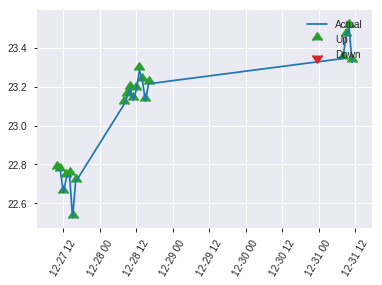


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26264815993339113
RMSE: 0.5124921071913119
LogLoss: 0.72756317080123
Mean Per-Class Error: 0.43184818481848186
AUC: 0.5512376237623762
pr_auc: 0.6095878286614967
Gini: 0.10247524752475234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04552030644248531: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    100  0.9901   (100.0/101.0)
1      0    120  0        (0.0/120.0)
Total  1    220  0.4525   (100.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0455203    0.705882  219
max f2                       0.0455203    0.857143  219
max f0point5                 0.225176     0.603814  205
max accuracy                 0.566526     0.556561  81
max precision                0.935762     1         0
max recall                   0.0455203    1         219
max specificity              0.935762     1         0
max absolute_mcc             0.65497      0.149167  34
max min_per_class_accuracy   0.511633     0.524752  110
max mean_per_class_accuracy  0.566526     0.568152  81

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.889693           1.84167   1.84167            1                0.916225  1                           0.916225            0.025           0.025                      84.1667   84.1667
    2        0.0226244                   0.836708           1.84167   1.84167            1                0.870001  1                           0.897736            0.0166667       0.0416667                  84.1667   84.1667
    3        0.0316742                   0.759276           0.920833  1.57857            0.5              0.778504  0.857143                    0.863669            0.00833333      0.05                       -7.91667  57.8571
    4        0.040724                    0.739146           0.920833  1.43241            0.5              0.753426  0.777778                    0.839171            0.00833333      0.0583333                  -7.91667  43.2407
    5        0.0542986                   0.73599            1.84167   1.53472            1                0.736461  0.833333                    0.813493            0.025           0.0833333                  84.1667   53.4722
    6        0.104072                    0.690587           0.837121  1.20109            0.454545         0.704251  0.652174                    0.761247            0.0416667       0.125                      -16.2879  20.1087
    7        0.153846                    0.656114           1.50682   1.3                0.818182         0.673105  0.705882                    0.73273             0.075           0.2                        50.6818   30
    8        0.20362                     0.638066           0.837121  1.18685            0.454545         0.644408  0.644444                    0.71114             0.0416667       0.241667                   -16.2879  18.6852
    9        0.303167                    0.589943           1.08826   1.15448            0.590909         0.611848  0.626866                    0.678537            0.108333        0.35                       8.82576   15.4478
    10       0.402715                    0.554797           0.837121  1.07603            0.454545         0.570292  0.58427                     0.65178             0.0833333       0.433333                   -16.2879  7.603
    11       0.502262                    0.511633           0.920833  1.04527            0.5              0.531389  0.567568                    0.627919            0.0916667       0.525                      -7.91667  4.52703
    12       0.60181                     0.468844           1.08826   1.05238            0.590909         0.488852  0.571429                    0.604915            0.108333        0.633333                   8.82576   5.2381
    13       0.701357                    0.41627            0.837121  1.02183            0.454545         0.43756   0.554839                    0.581162            0.0833333       0.716667                   -16.2879  2.1828
    14       0.800905                    0.358336           0.920833  1.00927            0.5              0.387779  0.548023                    0.557125            0.0916667       0.808333                   -7.91667  0.927495
    15       0.900452                    0.254922           1.00455   1.00875            0.545455         0.302303  0.547739                    0.528954            0.1             0.908333                   0.454545  0.875209
    16       1                           0.0409601          0.920833  1                  0.5              0.173887  0.542986                    0.493608            0.09

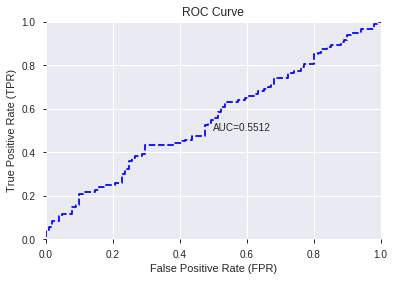

This function is available for GLM models only


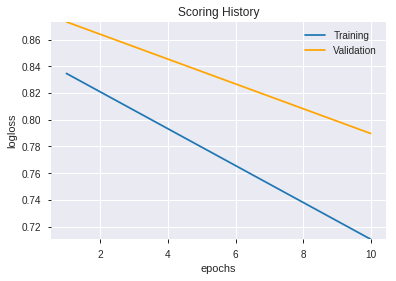

--2019-07-25 06:34:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190725_062552',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190725_062552',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_8bc5'

['ADX_20',
 'weekofyear',
 'NATR_30',
 'AROONOSC_12',
 'VAR_8',
 'dayofyear',
 'SINH',
 'weekday_name',
 'CORREL_12',
 'DX_20',
 'DX_30',
 'HT_TRENDMODE',
 'ATR_20',
 'NATR_12',
 'ADX_12',
 'aroondown_12',
 'CORREL_14',
 'DIV',
 'days_in_month',
 'hour',
 'BETA_12',
 'week',
 'MFI_8',
 'OBV',
 'DX_8',
 'STOCHF_fastk',
 'ADXR_14',
 'DX_24',
 'day',
 'month',
 'ADX_14',
 'AROONOSC_8',
 'DX_14',
 'HT_PHASOR_quadrature',
 'ATR_30',
 'BOP',
 'DX_12',
 'aroonup_24',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'SAREXT',
 'CORREL_8',
 'STOCHRSI_fastk',
 'COS',
 'ADXR_12',
 'aroondown_14',
 'aroondown_8',
 'HT_PHASOR_inphase',
 'ADX_24',
 'MACDEXT_signal']

In [0]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_063447_model_1  0.485396  0.694904               0.49505  0.500808  0.250808

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature             0.042429           1.000000    0.057039
1         MACDEXT_signal             0.036268           0.854786    0.048756
2                    OBV             0.033471           0.788864    0.044996
3            AROONOSC_12             0.028363           0.668467    0.038129
4           HT_TRENDMODE             0.027526           0.648745    0.037004
5             weekofyear             0.027352           0.644654    0.036771
6                   week             0.027318           0.643855    0.036725
7              dayofyear             0.026661           0.628361    0.035841
8                  month             0.025063           0.590700    0.033693
9               CORREL_8             0.022523           0.530825    0.030278
10                  SINH             0.022328           0.526230    0.030016
11                ADX_24             0.022030           0.519226    0.029616
12                 VAR_8             0.021464           0.505868    0.028854
13            aroonup_24             0.021403           0.504450    0.028774
14             CORREL_12             0.019997           0.471298    0.026883
15                SAREXT             0.018870           0.444732    0.025367
16                   day             0.018051           0.425436    0.024267
17                ADX_20             0.017957           0.423212    0.024140
18               NATR_12             0.017584           0.414421    0.023638
19                ADX_12             0.017504           0.412543    0.023531
20                ATR_20             0.017205           0.405487    0.023129
21                  DX_8             0.017147           0.404128    0.023051
22        STOCHRSI_fastk             0.015790           0.372137    0.021227
23                  hour             0.015656           0.368994    0.021047
24           aroondown_8             0.015450           0.364131    0.020770
25          aroondown_12             0.013672           0.322240    0.018380
26     HT_PHASOR_inphase             0.012826           0.302297    0.017243
27                ATR_30             0.011431           0.269406    0.015367
28               ADXR_14             0.011281           0.265875    0.015165
29          weekday_name             0.011280           0.265846    0.015164
30           HT_DCPERIOD             0.010212           0.240683    0.013728
31                 DX_30             0.009932           0.234072    0.013351
32               ADXR_12             0.009423           0.222077    0.012667
33            AROONOSC_8             0.009081           0.214020    0.012208
34                   DIV             0.008302           0.195656    0.011160
35                 DX_14             0.007321           0.172544    0.009842
36                ADX_14             0.006633           0.156336    0.008917
37               NATR_30             0.006205           0.146253    0.008342
38                   COS             0.006103           0.143841    0.008205
39                 DX_24             0.005654           0.133259    0.007601
40          aroondown_14             0.004989           0.117594    0.006707
41        STOCHRSI_fastd             0.004986           0.117515    0.006703
42                   BOP             0.004820           0.113609    0.006480
43             CORREL_14             0.004080           0.096149    0.005484
44                 MFI_8             0.003886           0.091582    0.005224
45                 DX_12             0.003569           0.084105    0.004797
46                 DX_20             0.001423           0.033539    0.001913
47               BETA_12             0.000738           0.017398    0.000992
48          STOCHF_fastk             0.000334           0.007875    0.000449
49         days_in_month             0.000272           0.006417    0.000366

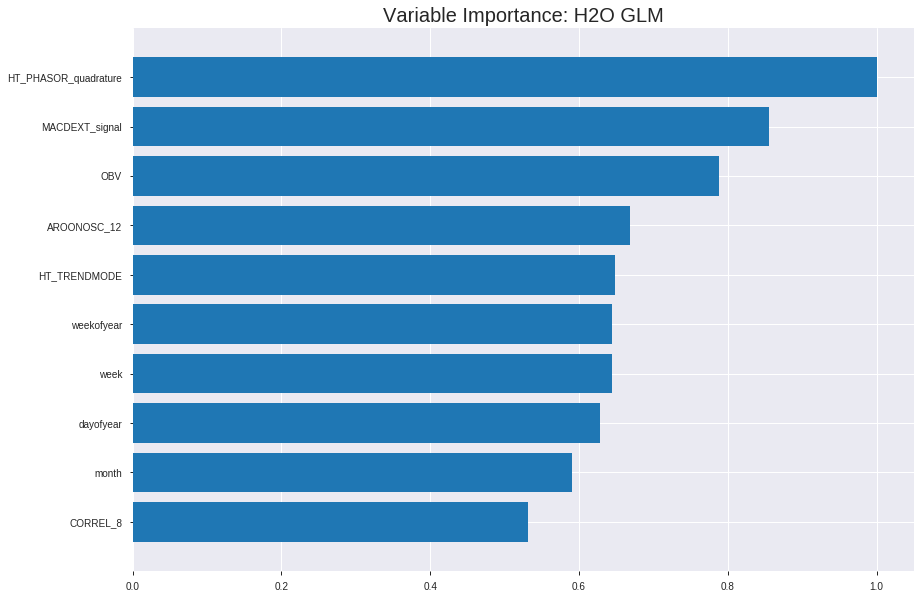

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_063447_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2466424844604925
RMSE: 0.4966311352105227
LogLoss: 0.6863960237175913
Null degrees of freedom: 1543
Residual degrees of freedom: 1493
Null deviance: 2137.6163902402923
Residual deviance: 2119.590921239922
AIC: 2221.590921239922
AUC: 0.5702619790046983
pr_auc: 0.58593282592606
Gini: 0.14052395800939665
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4406844454773061: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    735   0.9946   (735.0/739.0)
1      1    804   0.0012   (1.0/805.0)
Total  5    1539  0.4767   (736.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440684     0.686007  395
max f2                       0.429339     0.845233  397
max f0point5                 0.505388     0.588355  263
max accuracy                 0.50948      0.562824  249
max precision                0.618045     1         0
max recall                   0.429339     1         397
max specificity              0.618045     1         0
max absolute_mcc             0.50948      0.118856  249
max min_per_class_accuracy   0.521388     0.55528   209
max mean_per_class_accuracy  0.517764     0.558957  220

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.595987           1.43851   1.43851            0.75             0.606498  0.75                        0.606498            0.0149068       0.0149068                  43.8509   43.8509
    2        0.0200777                   0.587824           1.15081   1.2993             0.6              0.591223  0.677419                    0.599107            0.0111801       0.026087                   15.0807   29.9299
    3        0.0304404                   0.583571           1.19876   1.26507            0.625            0.585829  0.659574                    0.594587            0.0124224       0.0385093                  19.8758   26.5072
    4        0.0401554                   0.579027           1.40654   1.2993             0.733333         0.581229  0.677419                    0.591355            0.0136646       0.0521739                  40.6542   29.9299
    5        0.0505181                   0.576878           0.83913   1.20491            0.4375           0.578039  0.628205                    0.588624            0.00869565      0.0608696                  -16.087   20.4905
    6        0.100389                    0.564533           1.27037   1.23743            0.662338         0.570475  0.645161                    0.579608            0.063354        0.124224                   27.0372   23.7427
    7        0.150259                    0.557184           1.27037   1.24836            0.662338         0.561077  0.650862                    0.573458            0.063354        0.187578                   27.0372   24.8362
    8        0.20013                     0.551061           1.09601   1.2104             0.571429         0.554065  0.631068                    0.568625            0.0546584       0.242236                   9.60071   21.0396
    9        0.29987                     0.540668           0.959006  1.12678            0.5              0.545217  0.587473                    0.560839            0.0956522       0.337888                   -4.09938  12.6781
    10       0.400259                    0.529989           1.08894   1.11729            0.567742         0.53512   0.582524                    0.554389            0.109317        0.447205                   8.89361   11.7289
    11       0.5                         0.521467           1.0711    1.10807            0.558442         0.525406  0.57772                     0.548607            0.106832        0.554037                   7.10978   10.8075
    12       0.599741                    0.511716           0.983915  1.08743            0.512987         0.516219  0.566955                    0.543221            0.0981366       0.652174                   -1.60845  8.7426
    13       0.70013                     0.502306           0.890948  1.05925            0.464516         0.507006  0.552266                    0.538028            0.089441        0.741615                   -10.9052  5.92539
    14       0.79987                     0.491386           0.797096  1.02656            0.415584         0.496801  0.535223                    0.532887            0.0795031       0.821118                   -20.2904  2.65637
    15       0.899611                    0.478348           0.896733  1.01217            0.467532         0.485528  0.527718                    0.527637            0.089441        0.910559                   -10.3267  1.21693
    16       1                           0.422594           0.890948  1                  0.464516         0.465244  0.521373                    0.521373          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2469926715858302
RMSE: 0.49698357275249067
LogLoss: 0.6870693631860656
Null degrees of freedom: 440
Residual degrees of freedom: 390
Null deviance: 610.0237499842223
Residual deviance: 605.9951783301099
AIC: 707.9951783301099
AUC: 0.5654919115219544
pr_auc: 0.5885695835048452
Gini: 0.13098382304390888
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47649582386193423: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    205  0.9856   (205.0/208.0)
1      0    233  0        (0.0/233.0)
Total  3    438  0.4649   (205.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476496     0.694486  396
max f2                       0.476496     0.850365  396
max f0point5                 0.546477     0.595533  227
max accuracy                 0.547284     0.571429  225
max precision                0.629224     0.75      3
max recall                   0.476496     1         396
max specificity              0.664044     0.995192  0
max absolute_mcc             0.547284     0.138209  225
max min_per_class_accuracy   0.550198     0.557692  208
max mean_per_class_accuracy  0.547284     0.568886  225

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 55.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.628609           1.13562   1.13562            0.6              0.645433  0.6                         0.645433            0.0128755       0.0128755                  13.5622   13.5622
    2        0.0204082                   0.626021           1.41953   1.2618             0.75             0.627548  0.666667                    0.637484            0.0128755       0.0257511                  41.9528   26.1803
    3        0.031746                    0.618228           1.51416   1.35193            0.8              0.622165  0.714286                    0.632013            0.0171674       0.0429185                  51.4163   35.1931
    4        0.0408163                   0.615047           1.41953   1.36695            0.75             0.615579  0.722222                    0.628361            0.0128755       0.055794                   41.9528   36.6953
    5        0.0521542                   0.612435           1.13562   1.31666            0.6              0.613751  0.695652                    0.625185            0.0128755       0.0686695                  13.5622   31.6664
    6        0.102041                    0.598915           1.20445   1.2618             0.636364         0.604971  0.666667                    0.615302            0.0600858       0.128755                   20.4448   26.1803
    7        0.151927                    0.587818           1.29048   1.27122            0.681818         0.592466  0.671642                    0.607804            0.0643777       0.193133                   29.048    27.1219
    8        0.201814                    0.580323           0.86032   1.16965            0.454545         0.584193  0.617978                    0.601967            0.0429185       0.236052                   -13.968   16.9648
    9        0.301587                    0.571918           0.903336  1.08155            0.477273         0.575877  0.571429                    0.593336            0.0901288       0.32618                    -9.66641  8.15451
    10       0.401361                    0.561501           1.11842   1.09071            0.590909         0.566119  0.576271                    0.58657             0.111588        0.437768                   11.8416   9.07107
    11       0.501134                    0.55049            1.16143   1.10479            0.613636         0.556461  0.58371                     0.580576            0.11588         0.553648                   16.1432   10.4791
    12       0.600907                    0.542507           0.989368  1.08563            0.522727         0.546732  0.573585                    0.574956            0.0987124       0.652361                   -1.06321  8.56264
    13       0.70068                     0.535234           0.86032   1.05354            0.454545         0.538697  0.556634                    0.569793            0.0858369       0.738197                   -13.968   5.35439
    14       0.800454                    0.524045           0.774288  1.01874            0.409091         0.529628  0.538244                    0.564787            0.0772532       0.815451                   -22.5712  1.87358
    15       0.900227                    0.513466           1.0754    1.02502            0.568182         0.518537  0.541562                    0.559661            0.107296        0.922747                   7.53999   2.50159
    16       1                           0.464798           0.774288  1                  0.409091         0.499421  0.528345                    0.55365          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 06:34:47  0.000 sec   2            2.5       51            1.38091           1.37914
    2019-07-25 06:34:47  0.039 sec   4            1.5       51            1.3797            1.37792
    2019-07-25 06:34:47  0.064 sec   6            0.95      51            1.37829           1.37669
    2019-07-25 06:34:47  0.089 sec   8            0.59      51            1.37668           1.37556
    2019-07-25 06:34:48  0.110 sec   10           0.36      51            1.37485           1.37464
    2019-07-25 06:34:48  0.136 sec   12           0.23      51            1.37279           1.37414
    2019-07-25 06:34:48  0.162 sec   14           0.14      51            1.37056           1.37426
    2019-07-25 06:34:48  0.185 sec   16           0.087     51            1.36825           1.37521
    2019-07-25 06:34:48  0.209 sec   18           0.054     51            1.366             1.37703
    2019-07-25 06:34:48  0.228 sec   20           0.034     51            1.36397           1.37941
    2019-07-25 06:34:48  0.243 sec   22           0.021     51            1.36221           1.38176

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5475113122171946)

('F1', 0.7058823529411764)

('auc', 0.4853960396039604)

('logloss', 0.6949042666094756)

('mean_per_class_error', 0.4745874587458746)

('rmse', 0.5008078211627582)

('mse', 0.2508084737377892)

glm prediction progress: |████████████████████████████████████████████████| 100%


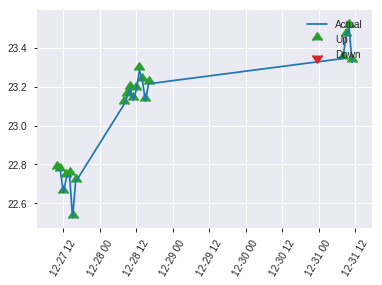


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2508084737377892
RMSE: 0.5008078211627582
LogLoss: 0.6949042666094756
Null degrees of freedom: 220
Residual degrees of freedom: 170
Null deviance: 305.1498983064551
Residual deviance: 307.1476858413882
AIC: 409.1476858413882
AUC: 0.4853960396039604
pr_auc: 0.5175676527834155
Gini: -0.029207920792079234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49024393625253115: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    100  0.9901   (100.0/101.0)
1      0    120  0        (0.0/120.0)
Total  1    220  0.4525   (100.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490244     0.705882  219
max f2                       0.490244     0.857143  219
max f0point5                 0.490244     0.6       219
max accuracy                 0.497516     0.547511  215
max precision                0.627061     0.666667  2
max recall                   0.490244     1         219
max specificity              0.647288     0.990099  0
max absolute_mcc             0.602515     0.144218  16
max min_per_class_accuracy   0.561124     0.508333  109
max mean_per_class_accuracy  0.565575     0.525413  97

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 56.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.627034           1.22778   1.22778            0.666667         0.637058  0.666667                    0.637058            0.0166667       0.0166667                  22.7778   22.7778
    2        0.0226244                   0.62235            0         0.736667           0                0.626399  0.4                         0.632794            0               0.0166667                  -100      -26.3333
    3        0.0316742                   0.613772           0.920833  0.789286           0.5              0.616069  0.428571                    0.628016            0.00833333      0.025                      -7.91667  -21.0714
    4        0.040724                    0.611018           0         0.613889           0                0.612304  0.333333                    0.624524            0               0.025                      -100      -38.6111
    5        0.0542986                   0.607468           0         0.460417           0                0.608608  0.25                        0.620545            0               0.025                      -100      -53.9583
    6        0.104072                    0.598765           0.837121  0.64058            0.454545         0.602456  0.347826                    0.611894            0.0416667       0.0666667                  -16.2879  -35.942
    7        0.153846                    0.591309           1.17197   0.8125             0.636364         0.594882  0.441176                    0.60639             0.0583333       0.125                      17.197    -18.75
    8        0.20362                     0.584551           1.50682   0.982222           0.818182         0.587371  0.533333                    0.601741            0.075           0.2                        50.6818   -1.77778
    9        0.303167                    0.575993           1.00455   0.989552           0.545455         0.578645  0.537313                    0.594157            0.1             0.3                        0.454545  -1.04478
    10       0.402715                    0.568866           1.08826   1.01395            0.590909         0.573138  0.550562                    0.588961            0.108333        0.408333                   8.82576   1.39513
    11       0.502262                    0.561078           1.00455   1.01209            0.545455         0.564305  0.54955                     0.584074            0.1             0.508333                   0.454545  1.20871
    12       0.60181                     0.554495           1.00455   1.01084            0.545455         0.557799  0.548872                    0.579728            0.1             0.608333                   0.454545  1.08396
    13       0.701357                    0.548072           0.837121  0.986183           0.454545         0.55175   0.535484                    0.575757            0.0833333       0.691667                   -16.2879  -1.38172
    14       0.800905                    0.539041           1.08826   0.99887            0.590909         0.543785  0.542373                    0.571783            0.108333        0.8                        8.82576   -0.112994
    15       0.900452                    0.523319           0.753409  0.971734           0.409091         0.530723  0.527638                    0.567244            0.075           0.875                      -24.6591  -2.82663
    16       1                           0.489134           1.25568   1                  0.681818         0.507779  0.542986                    0.561324

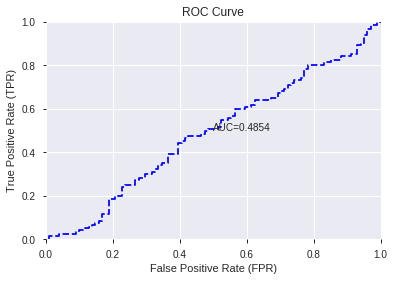

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


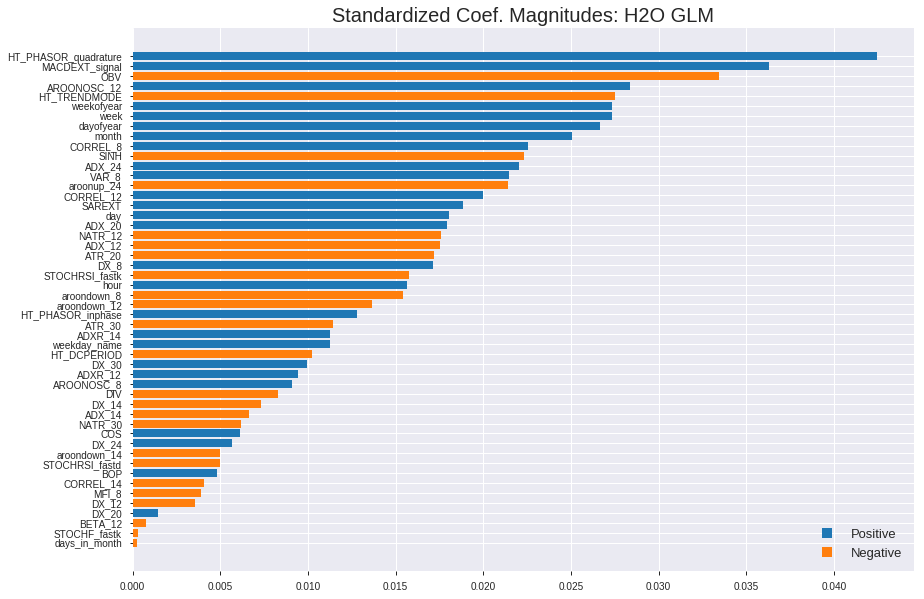

'log_likelihood'
--2019-07-25 06:34:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_063447_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_063447_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['HT_PHASOR_quadrature',
 'MACDEXT_signal',
 'OBV',
 'AROONOSC_12',
 'HT_TRENDMODE',
 'weekofyear',
 'week',
 'dayofyear',
 'month',
 'CORREL_8',
 'SINH',
 'ADX_24',
 'VAR_8',
 'aroonup_24',
 'CORREL_12',
 'SAREXT',
 'day',
 'ADX_20',
 'NATR_12',
 'ADX_12',
 'ATR_20',
 'DX_8',
 'STOCHRSI_fastk',
 'hour',
 'aroondown_8',
 'aroondown_12',
 'HT_PHASOR_inphase',
 'ATR_30',
 'ADXR_14',
 'weekday_name',
 'HT_DCPERIOD',
 'DX_30',
 'ADXR_12',
 'AROONOSC_8',
 'DIV',
 'DX_14',
 'ADX_14',
 'NATR_30',
 'COS',
 'DX_24',
 'aroondown_14',
 'STOCHRSI_fastd',
 'BOP',
 'CORREL_14',
 'MFI_8',
 'DX_12',
 'DX_20',
 'BETA_12',
 'STOCHF_fastk',
 'days_in_month']

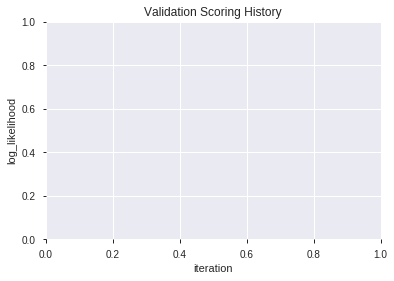

In [0]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_063500_model_1  0.574257  0.689527              0.461427  0.498070  0.248074
1  XGBoost_grid_1_AutoML_20190725_063500_model_7  0.561139  0.688655              0.480198  0.497678  0.247683
2  XGBoost_grid_1_AutoML_20190725_063500_model_4  0.552723  0.688007              0.495050  0.497373  0.247380
3               XGBoost_3_AutoML_20190725_063500  0.545050  0.693848              0.470297  0.500383  0.250384
4  XGBoost_grid_1_AutoML_20190725_063500_model_2  0.539521  0.691176              0.462995  0.498986  0.248987
5  XGBoost_grid_1_AutoML_20190725_063500_model_3  0.535149  0.695330              0.500000  0.501012  0.251013
6  XGBoost_grid_1_AutoML_20190725_063500_model_6  0.528053  0.693310              0.490099  0.500072  0.250072
7               XGBoost_1_AutoML_20190725_063500  0.512211  0.702906              0.495050  0.504771  0.254794
8  XGBoost_grid_1_AutoML_20190725_063500_model_5  0.502063  0.738638              0.500000  0.520175  0.270582
9               XGBoost_2_AutoML_20190725_063500  0.495462  0.705383              0.500000  0.505823  0.255857

variable  relative_importance  scaled_importance  percentage
0                    BOP           260.538391           1.000000    0.070086
1                    OBV           234.394012           0.899652    0.063053
2                  MFI_8           233.812820           0.897422    0.062896
3            HT_DCPERIOD           214.536255           0.823434    0.057711
4           STOCHF_fastk           174.038559           0.667996    0.046817
5   HT_PHASOR_quadrature           164.406250           0.631025    0.044226
6               CORREL_8           157.563217           0.604760    0.042385
7                    DIV           140.377029           0.538796    0.037762
8      HT_PHASOR_inphase           138.348740           0.531011    0.037216
9                   DX_8           126.681358           0.486229    0.034078
10                 DX_12           120.705147           0.463291    0.032470
11               NATR_30           116.046005           0.445408    0.031217
12             dayofyear           110.841888           0.425434    0.029817
13                 VAR_8           100.030067           0.383936    0.026908
14                  SINH            96.842834           0.371703    0.026051
15               BETA_12            95.700974           0.367320    0.025744
16                   COS            90.332649           0.346715    0.024300
17                ADX_12            83.661415           0.321110    0.022505
18                 DX_24            75.632668           0.290294    0.020345
19             CORREL_12            73.889809           0.283604    0.019877
20                 DX_14            68.344093           0.262319    0.018385
21             CORREL_14            61.206230           0.234922    0.016465
22               NATR_12            60.176201           0.230969    0.016188
23        STOCHRSI_fastd            59.673920           0.229041    0.016052
24               ADXR_14            59.419788           0.228065    0.015984
25                SAREXT            58.252769           0.223586    0.015670
26                   day            56.327480           0.216196    0.015152
27                 DX_30            47.156071           0.180995    0.012685
28                ATR_20            45.501366           0.174644    0.012240
29               ADXR_12            41.771038           0.160326    0.011237
30                ATR_30            39.586941           0.151943    0.010649
31        MACDEXT_signal            38.107265           0.146264    0.010251
32                  hour            33.112068           0.127091    0.008907
33          HT_TRENDMODE            30.427181           0.116786    0.008185
34                ADX_14            28.682493           0.110089    0.007716
35           AROONOSC_12            27.012238           0.103679    0.007266
36          weekday_name            23.330278           0.089546    0.006276
37                 DX_20            22.196949           0.085196    0.005971
38                ADX_20            21.802742           0.083683    0.005865
39            AROONOSC_8            19.546856           0.075025    0.005258
40           aroondown_8            15.248373           0.058526    0.004102
41                ADX_24            14.488824           0.055611    0.003898
42          aroondown_12            11.135964           0.042742    0.002996
43            aroonup_24             8.921267           0.034242    0.002400
44        STOCHRSI_fastk             7.880747           0.030248    0.002120
45            weekofyear             6.159210           0.023640    0.001657
46                 month             3.579145           0.013737    0.000963

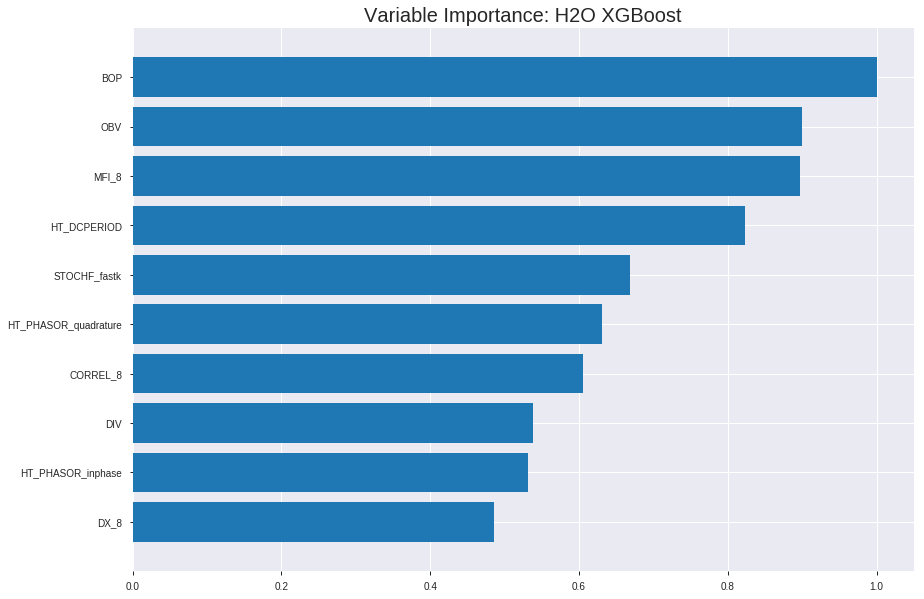

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_063500_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19243026290143017
RMSE: 0.4386687393711001
LogLoss: 0.5750433940563352
Mean Per-Class Error: 0.16294556182183406
AUC: 0.905218567982585
pr_auc: 0.910906102057767
Gini: 0.8104371359651701
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5074433286984762: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      584  155  0.2097   (155.0/739.0)
1      96   709  0.1193   (96.0/805.0)
Total  680  864  0.1626   (251.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507443     0.849611  215
max f2                       0.471894     0.890603  256
max f0point5                 0.542396     0.85295   174
max accuracy                 0.510063     0.838083  212
max precision                0.793525     1         0
max recall                   0.362362     1         355
max specificity              0.793525     1         0
max absolute_mcc             0.510063     0.675955  212
max min_per_class_accuracy   0.519922     0.832206  200
max mean_per_class_accuracy  0.517608     0.837054  203

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.723226           1.91801    1.91801            1                0.753792  1                           0.753792            0.0198758       0.0198758                  91.8012   91.8012
    2        0.0200777                   0.698543           1.91801    1.91801            1                0.713661  1                           0.734374            0.0186335       0.0385093                  91.8012   91.8012
    3        0.0304404                   0.687564           1.91801    1.91801            1                0.692667  1                           0.720176            0.0198758       0.0583851                  91.8012   91.8012
    4        0.0401554                   0.680858           1.91801    1.91801            1                0.683903  1                           0.7114              0.0186335       0.0770186                  91.8012   91.8012
    5        0.0505181                   0.671951           1.91801    1.91801            1                0.675996  1                           0.704138            0.0198758       0.0968944                  91.8012   91.8012
    6        0.100389                    0.646484           1.81838    1.86852            0.948052         0.658317  0.974194                    0.681375            0.0906832       0.187578                   81.8375   86.8515
    7        0.150259                    0.626116           1.86819    1.86841            0.974026         0.635967  0.974138                    0.666304            0.0931677       0.280745                   86.8194   86.8409
    8        0.20013                     0.606447           1.79347    1.84973            0.935065         0.616628  0.964401                    0.653925            0.089441        0.370186                   79.3466   84.9734
    9        0.29987                     0.5791             1.6191     1.77302            0.844156         0.592309  0.924406                    0.633431            0.161491        0.531677                   61.9101   77.3022
    10       0.400259                    0.55133            1.54678    1.71628            0.806452         0.565379  0.894822                    0.616363            0.15528         0.686957                   54.6784   71.628
    11       0.5                         0.522945           1.25792    1.62484            0.655844         0.535885  0.84715                     0.600309            0.125466        0.812422                   25.7917   62.4845
    12       0.599741                    0.495606           0.934097   1.50997            0.487013         0.509716  0.787257                    0.585243            0.0931677       0.90559                    -6.5903   50.9969
    13       0.70013                     0.467521           0.4331     1.35556            0.225806         0.481604  0.706753                    0.570382            0.0434783       0.949068                   -56.69    35.5561
    14       0.79987                     0.430911           0.286456   1.22225            0.149351         0.450678  0.637247                    0.555456            0.0285714       0.97764                    -71.3544  22.2248
    15       0.899611                    0.387033           0.137001   1.10193            0.0714286        0.41025   0.574514                    0.539357            0.0136646       0.991304                   -86.2999  10.1925
    16       1                           0.217115           0.0866199  1                  0.0451613        0.343666  0.521373                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25343131309994743
RMSE: 0.5034196193037648
LogLoss: 0.7002923824195191
Mean Per-Class Error: 0.4600425057774844
AUC: 0.5275565368108286
pr_auc: 0.5527306554607494
Gini: 0.05511307362165718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33301618695259094: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    202  0.9712   (202.0/208.0)
1      2    231  0.0086   (2.0/233.0)
Total  8    433  0.4626   (204.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.333016     0.693694   391
max f2                       0.238136     0.848507   399
max f0point5                 0.333016     0.587786   391
max accuracy                 0.481038     0.54195    215
max precision                0.792065     1          0
max recall                   0.238136     1          399
max specificity              0.792065     1          0
max absolute_mcc             0.713887     0.0903947  3
max min_per_class_accuracy   0.485879     0.532189   201
max mean_per_class_accuracy  0.481038     0.539957   215

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.704992           1.51416   1.51416            0.8              0.743656  0.8                         0.743656            0.0171674       0.0171674                  51.4163   51.4163
    2        0.0204082                   0.658179           0.946352  1.2618             0.5              0.676204  0.666667                    0.713677            0.00858369      0.0257511                  -5.36481  26.1803
    3        0.031746                    0.638206           0.757082  1.08155            0.4              0.647236  0.571429                    0.689948            0.00858369      0.0343348                  -24.2918  8.15451
    4        0.0408163                   0.63151            1.41953   1.15665            0.75             0.635774  0.611111                    0.677909            0.0128755       0.0472103                  41.9528   15.6652
    5        0.0521542                   0.627174           0.757082  1.06979            0.4              0.628396  0.565217                    0.667146            0.00858369      0.055794                   -24.2918  6.97891
    6        0.102041                    0.583058           0.946352  1.00944            0.5              0.602065  0.533333                    0.635328            0.0472103       0.103004                   -5.36481  0.944206
    7        0.151927                    0.570202           1.03238   1.01698            0.545455         0.576704  0.537313                    0.616079            0.0515021       0.154506                   3.23839   1.69752
    8        0.201814                    0.554453           1.20445   1.06332            0.636364         0.561141  0.561798                    0.602499            0.0600858       0.214592                   20.4448   6.33168
    9        0.301587                    0.522077           1.0754    1.06731            0.568182         0.539701  0.56391                     0.581724            0.107296        0.321888                   7.53999   6.73142
    10       0.401361                    0.505111           0.989368  1.04794            0.522727         0.514419  0.553672                    0.564992            0.0987124       0.420601                   -1.06321  4.79377
    11       0.501134                    0.485851           1.11842   1.06197            0.590909         0.493833  0.561086                    0.550825            0.111588        0.532189                   11.8416   6.19696
    12       0.600907                    0.46885            0.989368  1.04991            0.522727         0.477169  0.554717                    0.538595            0.0987124       0.630901                   -1.06321  4.9915
    13       0.70068                     0.445999           0.946352  1.03517            0.5              0.456806  0.546926                    0.526949            0.0944206       0.725322                   -5.36481  3.51681
    14       0.800454                    0.422806           0.774288  1.00265            0.409091         0.434393  0.529745                    0.515412            0.0772532       0.802575                   -22.5712  0.265049
    15       0.900227                    0.390687           0.86032   0.986876           0.454545         0.408137  0.521411                    0.503523            0.0858369       0.888412                   -13.968   -1.31242
    16       1                           0.238136           1.11842   1                  0.590909         0.353616  0.528345                    0.488566       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:35:05  0.030 sec   0                  0.5              0.693147            0.5             0                  1                0.478627                         0.5                0.693147              0.5               0                    1                  0.471655
    2019-07-25 06:35:05  0.099 sec   5                  0.490787         0.674859            0.733914        0.736103           1.80519          0.365933                         0.499642           0.692429              0.507315          0.532683             1.41953            0.46712
    2019-07-25 06:35:05  0.156 sec   10                 0.482223         0.658042            0.778131        0.782853           1.91801          0.318653                         0.499187           0.691507              0.515032          0.537906             1.08155            0.464853
    2019-07-25 06:35:05  0.210 sec   15                 0.475009         0.643996            0.808907        0.814698           1.91801          0.275259                         0.499133           0.691388              0.517508          0.539654             1.13562            0.462585
    2019-07-25 06:35:05  0.276 sec   20                 0.468432         0.631307            0.836694        0.842906           1.91801          0.24158                          0.498976           0.691057              0.523636          0.550352             1.8927             0.464853
    2019-07-25 06:35:05  0.333 sec   25                 0.463211         0.621314            0.853877        0.859115           1.91801          0.243523                         0.499194           0.691452              0.523388          0.546882             1.51416            0.462585
    2019-07-25 06:35:05  0.393 sec   30                 0.459481         0.614146            0.859194        0.864243           1.91801          0.215026                         0.499192           0.691458              0.53582           0.555636             1.51416            0.460317
    2019-07-25 06:35:05  0.450 sec   35                 0.455393         0.606317            0.866967        0.870417           1.91801          0.20272                          0.500213           0.693516              0.530105          0.550069             1.51416            0.462585
    2019-07-25 06:35:05  0.532 sec   40                 0.448448         0.593236            0.883144        0.889013           1.91801          0.189119                         0.50046            0.694042              0.536233          0.554164             1.51416            0.462585
    2019-07-25 06:35:05  0.606 sec   45                 0.442484         0.582163            0.898228        0.903232           1.91801          0.169041                         0.502304           0.697938              0.530022          0.552452             1.51416            0.462585
    2019-07-25 06:35:05  0.670 sec   50                 0.438669         0.575043            0.905219        0.910906           1.91801          0.162565                         0.50342            0.700292              0.527557          0.552731             1.51416            0.462585

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             260.53839111328125     1.0                   0.07008566676287399
OBV             234.39401245117188     0.8996524905585147    0.0630527446556737
MFI_8           233.8128204345703      0.8974217559089372    0.06289640213038702
HT_DCPERIOD     214.5362548828125      0.8234343275326853    0.057710943880567016
STOCHF_fastk    174.03855895996094     0.6679958305426456    0.046816933178401104
---             ---                    ---                   ---
aroondown_12    11.135964393615723     0.04274212466743084   0.0029956103061787743
aroonup_24      8.921266555786133      0.034241658274105156  0.002399849451207141
STOCHRSI_fastk  7.880747318267822      0.03024793115745195   0.002119946423367531
weekofyear      6.159210205078125      0.02364031718611527   0.0016568473924747178
month           3.5791449546813965     0.013737495420109491  0.0009628015261703014


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5972850678733032)

('F1', 0.7098765432098766)

('auc', 0.5742574257425742)

('logloss', 0.6895267206730069)

('mean_per_class_error', 0.4105198019801981)

('rmse', 0.4980700606045881)

('mse', 0.24807378527065807)

xgboost prediction progress: |████████████████████████████████████████████| 100%


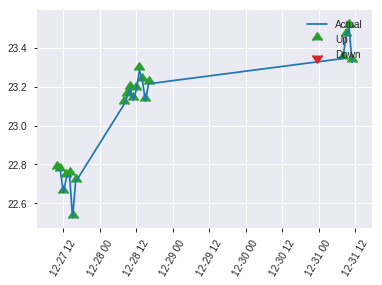


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24807378527065807
RMSE: 0.4980700606045881
LogLoss: 0.6895267206730069
Mean Per-Class Error: 0.4105198019801981
AUC: 0.5742574257425742
pr_auc: 0.5715404540874135
Gini: 0.14851485148514842
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38203638792037964: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      12   89   0.8812   (89.0/101.0)
1      5    115  0.0417   (5.0/120.0)
Total  17   204  0.4253   (94.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382036     0.709877  203
max f2                       0.296112     0.858369  218
max f0point5                 0.456227     0.628492  148
max accuracy                 0.456227     0.597285  148
max precision                0.598173     0.666667  17
max recall                   0.296112     1         218
max specificity              0.709101     0.990099  0
max absolute_mcc             0.429859     0.178486  174
max min_per_class_accuracy   0.493757     0.583333  111
max mean_per_class_accuracy  0.496041     0.58948   108

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 49.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.677889           0         0                  0                0.689259  0                           0.689259            0               0                          -100      -100
    2        0.0226244                   0.652038           0.920833  0.368333           0.5              0.662927  0.2                         0.678726            0.00833333      0.00833333                 -7.91667  -63.1667
    3        0.0316742                   0.640138           0.920833  0.52619            0.5              0.646433  0.285714                    0.6695              0.00833333      0.0166667                  -7.91667  -47.381
    4        0.040724                    0.633079           0.920833  0.613889           0.5              0.636539  0.333333                    0.662175            0.00833333      0.025                      -7.91667  -38.6111
    5        0.0542986                   0.620355           1.84167   0.920833           1                0.624632  0.5                         0.652789            0.025           0.05                       84.1667   -7.91667
    6        0.104072                    0.592889           1.33939   1.12101            0.727273         0.601586  0.608696                    0.628301            0.0666667       0.116667                   33.9394   12.1014
    7        0.153846                    0.576892           0.837121  1.02917            0.454545         0.583077  0.558824                    0.61367             0.0416667       0.158333                   -16.2879  2.91667
    8        0.20362                     0.559079           1.17197   1.06407            0.636364         0.567537  0.577778                    0.602393            0.0583333       0.216667                   17.197    6.40741
    9        0.303167                    0.535897           1.08826   1.07201            0.590909         0.547926  0.58209                     0.584508            0.108333        0.325                      8.82576   7.20149
    10       0.402715                    0.513867           1.08826   1.07603            0.590909         0.524262  0.58427                     0.569616            0.108333        0.433333                   8.82576   7.603
    11       0.502262                    0.495457           1.42311   1.14482            0.772727         0.502204  0.621622                    0.556255            0.141667        0.575                      42.3106   14.482
    12       0.60181                     0.477717           0.837121  1.09392            0.454545         0.486757  0.593985                    0.544759            0.0833333       0.658333                   -16.2879  9.39223
    13       0.701357                    0.450303           1.08826   1.09312            0.590909         0.462994  0.593548                    0.533154            0.108333        0.766667                   8.82576   9.31183
    14       0.800905                    0.42913            0.920833  1.0717             0.5              0.437459  0.581921                    0.521259            0.0916667       0.858333                   -7.91667  7.17043
    15       0.900452                    0.384596           0.837121  1.04577            0.454545         0.40839   0.567839                    0.508781            0.0833333       0.941667                   -16.2879  4.57705
    16       1                           0.248916           0.585985  1                  0.318182         0.347675  0.542986                    0.492744            

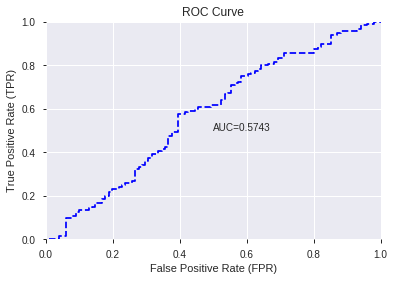

This function is available for GLM models only


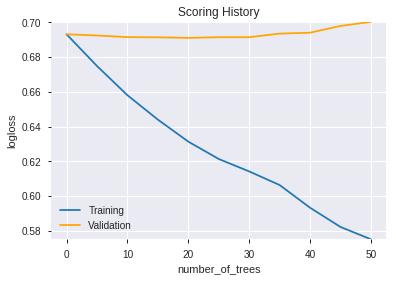

--2019-07-25 06:35:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_063500_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_063500_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'OBV',
 'MFI_8',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'DIV',
 'HT_PHASOR_inphase',
 'DX_8',
 'DX_12',
 'NATR_30',
 'dayofyear',
 'VAR_8',
 'SINH',
 'BETA_12',
 'COS',
 'ADX_12',
 'DX_24',
 'CORREL_12',
 'DX_14',
 'CORREL_14',
 'NATR_12',
 'STOCHRSI_fastd',
 'ADXR_14',
 'SAREXT',
 'day',
 'DX_30',
 'ATR_20',
 'ADXR_12',
 'ATR_30',
 'MACDEXT_signal',
 'hour',
 'HT_TRENDMODE',
 'ADX_14',
 'AROONOSC_12',
 'weekday_name',
 'DX_20',
 'ADX_20',
 'AROONOSC_8',
 'aroondown_8',
 'ADX_24',
 'aroondown_12',
 'aroonup_24',
 'STOCHRSI_fastk',
 'weekofyear',
 'month']

In [0]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_063525_model_1  0.494967  0.692384              0.480198  0.499564  0.249564

variable  relative_importance  scaled_importance    percentage
0                    CORREL_30         2.358853e-02           1.000000  1.433574e-02
1               CDL3LINESTRIKE         2.014073e-02           0.853836  1.224037e-02
2                  CDLMARUBOZU         1.965418e-02           0.833209  1.194467e-02
3           CDLMORNINGDOJISTAR         1.909814e-02           0.809637  1.160674e-02
4                  CDLLONGLINE         1.809537e-02           0.767126  1.099732e-02
...                        ...                  ...                ...           ...
1030                   MA_20_5         1.441756e-06           0.000061  8.762158e-07
1031  BBANDS_middleband_20_5_5         1.392469e-06           0.000059  8.462618e-07
1032  BBANDS_middleband_20_5_2         8.583660e-07           0.000036  5.216650e-07
1033  BBANDS_middleband_14_3_2         1.832379e-07           0.000008  1.113614e-07
1034   BBANDS_lowerband_12_1_4         7.981714e-08           0.000003  4.850822e-08

[1035 rows x 4 columns]

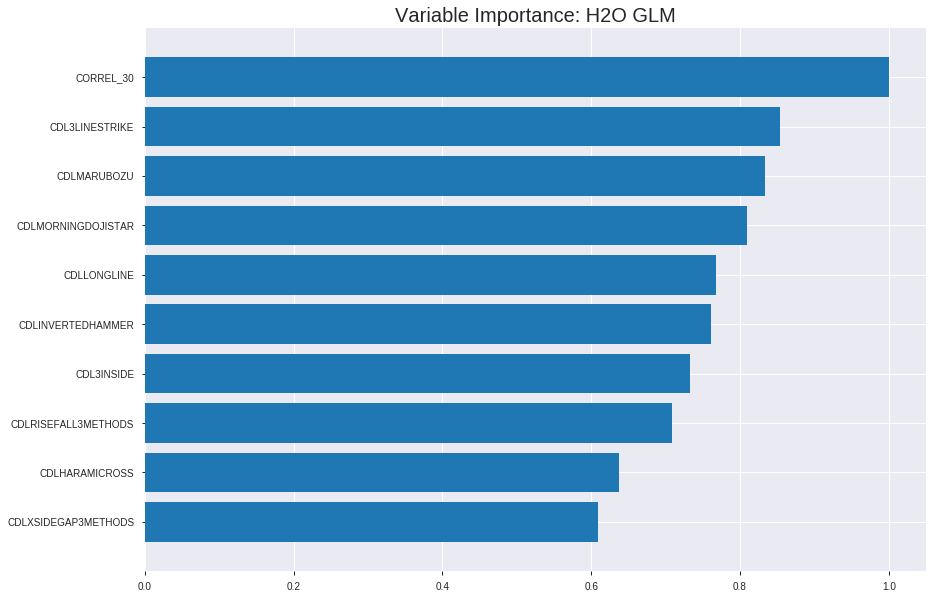

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_063525_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24291505604554592
RMSE: 0.492864135483143
LogLoss: 0.6788552194776347
Null degrees of freedom: 1543
Residual degrees of freedom: 508
Null deviance: 2137.6163902402923
Residual deviance: 2096.304917746936
AIC: 4168.304917746937
AUC: 0.6121525647383151
pr_auc: 0.618750588364273
Gini: 0.22430512947663028
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45845488637547804: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      60   679   0.9188   (679.0/739.0)
1      22   783   0.0273   (22.0/805.0)
Total  82   1462  0.454    (701.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458455     0.690781  353
max f2                       0.429621     0.845976  382
max f0point5                 0.49881      0.605065  266
max accuracy                 0.508902     0.584197  237
max precision                0.691888     1         0
max recall                   0.400961     1         394
max specificity              0.691888     1         0
max absolute_mcc             0.53712      0.167111  158
max min_per_class_accuracy   0.518786     0.577808  207
max mean_per_class_accuracy  0.518329     0.579986  209

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.622401           1.43851   1.43851            0.75             0.636565  0.75                        0.636565            0.0149068       0.0149068                  43.8509   43.8509
    2        0.0200777                   0.606742           1.27867   1.36117            0.666667         0.614647  0.709677                    0.62596             0.0124224       0.0273292                  27.8675   36.117
    3        0.0304404                   0.596445           1.31863   1.34669            0.6875           0.601281  0.702128                    0.617559            0.0136646       0.0409938                  31.8634   34.669
    4        0.0401554                   0.593312           1.27867   1.33023            0.666667         0.594643  0.693548                    0.612015            0.0124224       0.0534161                  27.8675   33.0234
    5        0.0505181                   0.59038            1.31863   1.32785            0.6875           0.591675  0.692308                    0.607842            0.0136646       0.0670807                  31.8634   32.7855
    6        0.100389                    0.577923           1.29528   1.31167            0.675325         0.583621  0.683871                    0.59581             0.0645963       0.131677                   29.5281   31.1673
    7        0.150259                    0.566519           1.19564   1.27316            0.623377         0.571637  0.663793                    0.587787            0.0596273       0.191304                   19.5644   27.3163
    8        0.20013                     0.556979           1.19564   1.25385            0.623377         0.561502  0.653722                    0.581237            0.0596273       0.250932                   19.5644   25.3846
    9        0.29987                     0.53999            1.2081    1.23863            0.62987          0.548126  0.645788                    0.570224            0.120497        0.371429                   20.8099   23.863
    10       0.400259                    0.5294             1.01469   1.18246            0.529032         0.534175  0.616505                    0.561183            0.101863        0.473292                   1.46904   18.2464
    11       0.5                         0.518831           1.00882   1.14783            0.525974         0.524214  0.598446                    0.553808            0.100621        0.573913                   0.882472  14.7826
    12       0.599741                    0.509936           0.971461  1.1185             0.506494         0.514467  0.583153                    0.547265            0.0968944       0.670807                   -2.85392  11.8495
    13       0.70013                     0.499476           0.977568  1.09829            0.509677         0.504562  0.572618                    0.541142            0.0981366       0.768944                   -2.24324  9.82883
    14       0.79987                     0.488081           0.809551  1.06228            0.422078         0.494136  0.553846                    0.535281            0.0807453       0.849689                   -19.0449  6.22838
    15       0.899611                    0.470978           0.871824  1.04117            0.454545         0.480405  0.542837                    0.529197            0.0869565       0.936646                   -12.8176  4.11673
    16       1                           0.30446            0.631088  1                  0.329032         0.451263  0.521373                    0.521373            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24651191738265904
RMSE: 0.4964996650378115
LogLoss: 0.6860863150427787
Null degrees of freedom: 440
Residual degrees of freedom: -595
Null deviance: 610.0237499842223
Residual deviance: 605.1281298677309
AIC: 2677.128129867731
AUC: 0.5624896830637174
pr_auc: 0.5960814921610385
Gini: 0.12497936612743477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49049249314565746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   198  0.9519   (198.0/208.0)
1      3    230  0.0129   (3.0/233.0)
Total  13   428  0.4558   (201.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490492     0.695915  386
max f2                       0.378873     0.848507  399
max f0point5                 0.490492     0.59126   386
max accuracy                 0.535243     0.562358  238
max precision                0.649575     1         0
max recall                   0.378873     1         399
max specificity              0.649575     1         0
max absolute_mcc             0.609013     0.146551  22
max min_per_class_accuracy   0.543808     0.540773  202
max mean_per_class_accuracy  0.535243     0.557465  238

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 54.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.629277           1.51416   1.51416            0.8              0.63596   0.8                         0.63596             0.0171674       0.0171674                  51.4163   51.4163
    2        0.0204082                   0.621286           0.473176  1.0515             0.25             0.624508  0.555556                    0.63087             0.00429185      0.0214592                  -52.6824  5.15021
    3        0.031746                    0.615849           1.8927    1.35193            1                0.618591  0.714286                    0.626485            0.0214592       0.0429185                  89.2704   35.1931
    4        0.0408163                   0.611242           1.41953   1.36695            0.75             0.613375  0.722222                    0.623571            0.0128755       0.055794                   41.9528   36.6953
    5        0.0521542                   0.60943            1.8927    1.48125            1                0.610107  0.782609                    0.620645            0.0214592       0.0772532                  89.2704   48.1247
    6        0.102041                    0.59813            1.11842   1.30386            0.590909         0.603818  0.688889                    0.612418            0.055794        0.133047                   11.8416   30.3863
    7        0.151927                    0.591102           1.20445   1.27122            0.636364         0.593749  0.671642                    0.606288            0.0600858       0.193133                   20.4448   27.1219
    8        0.201814                    0.578388           0.946352  1.19091            0.5              0.582654  0.629213                    0.600446            0.0472103       0.240343                   -5.36481  19.0915
    9        0.301587                    0.563494           0.946352  1.11001            0.5              0.56983   0.586466                    0.590317            0.0944206       0.334764                   -5.36481  11.0007
    10       0.401361                    0.552763           0.989368  1.08002            0.522727         0.55781   0.570621                    0.582237            0.0987124       0.433476                   -1.06321  8.00175
    11       0.501134                    0.543808           1.0754    1.0791             0.568182         0.548617  0.570136                    0.575543            0.107296        0.540773                   7.53999   7.90981
    12       0.600907                    0.534491           1.0754    1.07848            0.568182         0.538941  0.569811                    0.569466            0.107296        0.648069                   7.53999   7.84841
    13       0.70068                     0.527724           0.86032   1.04742            0.454545         0.530722  0.553398                    0.563949            0.0858369       0.733906                   -13.968   4.74186
    14       0.800454                    0.518324           0.774288  1.01337            0.409091         0.522582  0.535411                    0.558793            0.0772532       0.811159                   -22.5712  1.3374
    15       0.900227                    0.505573           1.03238   1.01548            0.545455         0.512242  0.536524                    0.553633            0.103004        0.914163                   3.23839   1.54809
    16       1                           0.378873           0.86032   1                  0.454545         0.487612  0.528345                    0.547046          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 06:35:28  0.000 sec   2            4         1036          1.3742            1.37414
    2019-07-25 06:35:30  1.867 sec   4            2.9       1036          1.37197           1.37356
    2019-07-25 06:35:32  3.703 sec   6            2.1       1036          1.36927           1.373
    2019-07-25 06:35:34  5.575 sec   8            1.6       1036          1.36601           1.37254
    2019-07-25 06:35:36  7.406 sec   10           1.1       1036          1.36217           1.37224
    2019-07-25 06:35:37  9.233 sec   12           0.83      1036          1.35771           1.37217
    2019-07-25 06:35:39  11.119 sec  14           0.6       1036          1.35265           1.37239
    2019-07-25 06:35:41  12.943 sec  16           0.44      1036          1.34704           1.37296
    2019-07-25 06:35:43  14.851 sec  18           0.32      1036          1.34095           1.37399
    2019-07-25 06:35:45  16.748 sec  20           0.23      1036          1.3345            1.37553
    2019-07-25 06:35:47  18.690 sec  22           0.17      1036          1.32783           1.37763

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.583710407239819)

('F1', 0.712166172106825)

('auc', 0.49496699669967)

('logloss', 0.6923841450134572)

('mean_per_class_error', 0.4421204620462047)

('rmse', 0.499564043271228)

('mse', 0.24956423332949734)

glm prediction progress: |████████████████████████████████████████████████| 100%


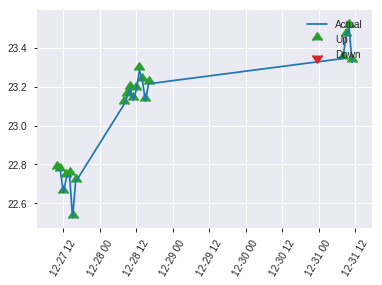


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24956423332949734
RMSE: 0.499564043271228
LogLoss: 0.6923841450134572
Null degrees of freedom: 220
Residual degrees of freedom: -815
Null deviance: 305.1498983064551
Residual deviance: 306.0337920959481
AIC: 2378.0337920959482
AUC: 0.49496699669967
pr_auc: 0.5148728161620789
Gini: -0.010066006600660038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49905503779470584: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    97   0.9604   (97.0/101.0)
1      0    120  0        (0.0/120.0)
Total  4    217  0.4389   (97.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499055     0.712166  216
max f2                       0.499055     0.860832  216
max f0point5                 0.525468     0.619048  179
max accuracy                 0.527161     0.58371   177
max precision                0.639729     1         0
max recall                   0.499055     1         216
max specificity              0.639729     1         0
max absolute_mcc             0.499055     0.147989  216
max min_per_class_accuracy   0.546371     0.475248  110
max mean_per_class_accuracy  0.527161     0.55788   177

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 55.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.628261           0.613889  0.613889           0.333333         0.632599  0.333333                    0.632599            0.00833333      0.00833333                 -38.6111  -38.6111
    2        0.0226244                   0.620573           0.920833  0.736667           0.5              0.624533  0.4                         0.629373            0.00833333      0.0166667                  -7.91667  -26.3333
    3        0.0316742                   0.614909           1.84167   1.05238            1                0.617963  0.571429                    0.626113            0.0166667       0.0333333                  84.1667   5.2381
    4        0.040724                    0.608939           0.920833  1.02315            0.5              0.612592  0.555556                    0.623108            0.00833333      0.0416667                  -7.91667  2.31481
    5        0.0542986                   0.605452           0         0.767361           0                0.607035  0.416667                    0.61909             0               0.0416667                  -100      -23.2639
    6        0.104072                    0.589726           0.837121  0.800725           0.454545         0.595694  0.434783                    0.607901            0.0416667       0.0833333                  -16.2879  -19.9275
    7        0.153846                    0.583458           1.00455   0.866667           0.545455         0.585945  0.470588                    0.600797            0.05            0.133333                   0.454545  -13.3333
    8        0.20362                     0.577565           0.837121  0.859444           0.454545         0.580001  0.466667                    0.595714            0.0416667       0.175                      -16.2879  -14.0556
    9        0.303167                    0.566351           1.08826   0.934577           0.590909         0.571039  0.507463                    0.587612            0.108333        0.283333                   8.82576   -6.54229
    10       0.402715                    0.554854           0.837121  0.910487           0.454545         0.560653  0.494382                    0.580948            0.0833333       0.366667                   -16.2879  -8.95131
    11       0.502262                    0.546371           1.17197   0.962312           0.636364         0.549371  0.522523                    0.574689            0.116667        0.483333                   17.197    -3.76877
    12       0.60181                     0.540064           1.25568   1.01084            0.681818         0.543311  0.548872                    0.569499            0.125           0.608333                   25.5682   1.08396
    13       0.701357                    0.534982           1.25568   1.04559            0.681818         0.537536  0.567742                    0.564962            0.125           0.733333                   25.5682   4.55914
    14       0.800905                    0.527569           1.17197   1.0613             0.636364         0.530935  0.576271                    0.560733            0.116667        0.85                       17.197    6.12994
    15       0.900452                    0.51808            0.669697  1.01801            0.363636         0.522276  0.552764                    0.556481            0.0666667       0.916667                   -33.0303  1.80067
    16       1                           0.488559           0.837121  1                  0.454545         0.507284  0.542986                    0.551584 

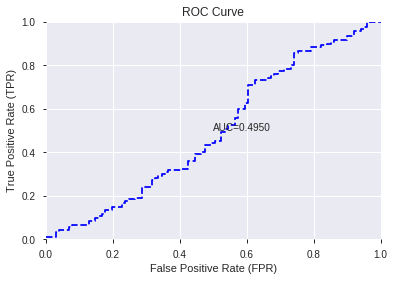

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


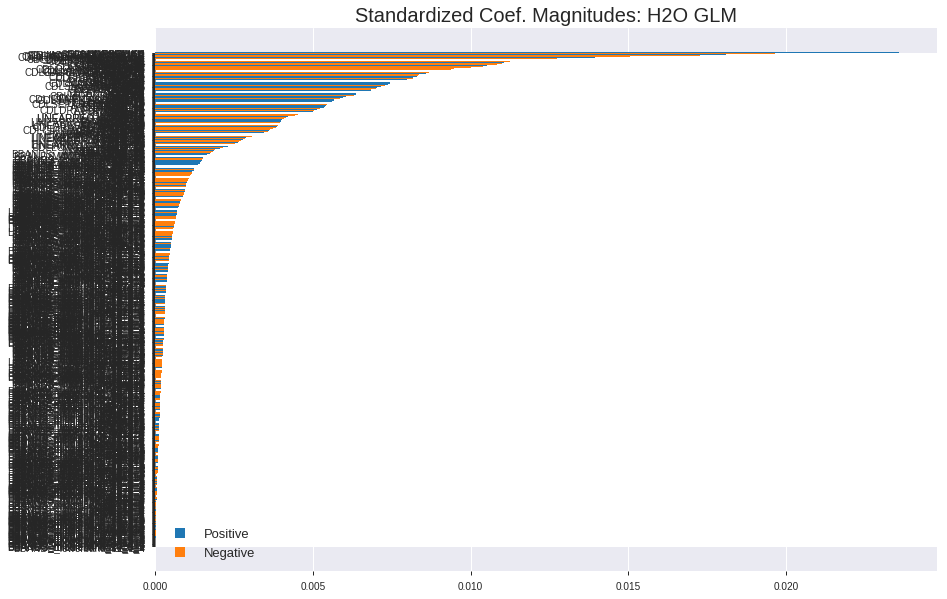

'log_likelihood'
--2019-07-25 06:36:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_063525_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_063525_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

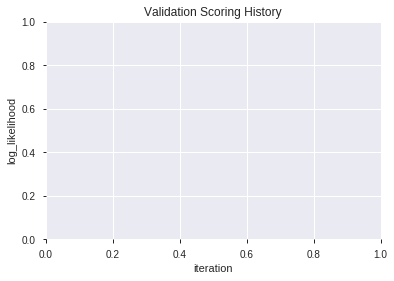

In [0]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [0]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [0]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [0]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190725_063618  0.508498  0.700529              0.490099  0.503503  0.253515
1  XGBoost_grid_1_AutoML_20190725_063618_model_2  0.506931  0.693943              0.479414  0.500395  0.250395
2  XGBoost_grid_1_AutoML_20190725_063618_model_6  0.506106  0.700182              0.500000  0.503245  0.253255
3  XGBoost_grid_1_AutoML_20190725_063618_model_4  0.503342  0.697266              0.489315  0.501975  0.251979
4  XGBoost_grid_1_AutoML_20190725_063618_model_5  0.494884  0.726856              0.500000  0.515167  0.265397
5               XGBoost_2_AutoML_20190725_063618  0.493647  0.704829              0.500000  0.505668  0.255700
6  XGBoost_grid_1_AutoML_20190725_063618_model_1  0.484901  0.709113              0.500000  0.507429  0.257485
7  XGBoost_grid_1_AutoML_20190725_063618_model_7  0.480776  0.721270              0.500000  0.512941  0.263108
8               XGBoost_1_AutoML_20190725_063618  0.471040  0.708142              0.494266  0.507101  0.257151
9  XGBoost_grid_1_AutoML_20190725_063618_model_3  0.438366  0.716402              0.495050  0.511211  0.261336

variable  relative_importance  scaled_importance  percentage
0                      MFI_8           101.362007           1.000000    0.020934
1                        BOP            83.252426           0.821338    0.017194
2                  CORREL_30            78.063354           0.770144    0.016122
3                    BETA_30            73.047348           0.720658    0.015086
4                        OBV            68.323959           0.674059    0.014111
..                       ...                  ...                ...         ...
294  BBANDS_upperband_24_2_5             1.029424           0.010156    0.000213
295               aroonup_12             0.860748           0.008492    0.000178
296   BBANDS_lowerband_8_7_4             0.856314           0.008448    0.000177
297  BBANDS_upperband_24_2_4             0.328224           0.003238    0.000068
298                   CMO_12             0.130664           0.001289    0.000027

[299 rows x 4 columns]

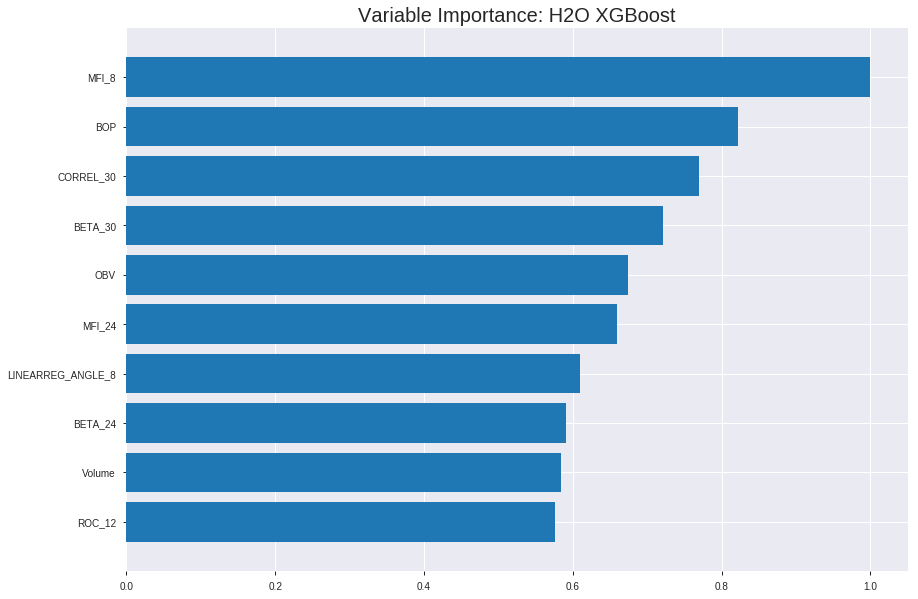

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190725_063618


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17801201838629713
RMSE: 0.4219147051079129
LogLoss: 0.5452785613046465
Mean Per-Class Error: 0.11162474050042448
AUC: 0.9558611183486161
pr_auc: 0.9597026966554465
Gini: 0.9117222366972322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5157768428325653: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      644  95   0.1286   (95.0/739.0)
1      79   726  0.0981   (79.0/805.0)
Total  723  821  0.1127   (174.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.515777     0.892989  207
max f2                       0.479715     0.93087   243
max f0point5                 0.534588     0.905207  188
max accuracy                 0.531469     0.887306  192
max precision                0.798536     1         0
max recall                   0.400115     1         317
max specificity              0.798536     1         0
max absolute_mcc             0.531469     0.776151  192
max min_per_class_accuracy   0.521556     0.883627  202
max mean_per_class_accuracy  0.531469     0.888375  192

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 52.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.719381           1.91801    1.91801            1                0.748005  1                           0.748005            0.0198758       0.0198758                  91.8012   91.8012
    2        0.0200777                   0.71109            1.91801    1.91801            1                0.715517  1                           0.732285            0.0186335       0.0385093                  91.8012   91.8012
    3        0.0304404                   0.702486           1.91801    1.91801            1                0.706688  1                           0.723571            0.0198758       0.0583851                  91.8012   91.8012
    4        0.0401554                   0.692708           1.91801    1.91801            1                0.697733  1                           0.71732             0.0186335       0.0770186                  91.8012   91.8012
    5        0.0505181                   0.685869           1.91801    1.91801            1                0.688978  1                           0.711506            0.0198758       0.0968944                  91.8012   91.8012
    6        0.100389                    0.661319           1.91801    1.91801            1                0.672583  1                           0.69217             0.0956522       0.192547                   91.8012   91.8012
    7        0.150259                    0.639296           1.91801    1.91801            1                0.648673  1                           0.677734            0.0956522       0.288199                   91.8012   91.8012
    8        0.20013                     0.619106           1.91801    1.91801            1                0.62921   1                           0.665642            0.0956522       0.383851                   91.8012   91.8012
    9        0.29987                     0.590859           1.79347    1.87659            0.935065         0.605498  0.978402                    0.645637            0.178882        0.562733                   79.3466   87.6587
    10       0.400259                    0.559065           1.6829     1.82801            0.877419         0.574872  0.953074                    0.627889            0.168944        0.731677                   68.2901   82.8009
    11       0.5                         0.527475           1.39492    1.74161            0.727273         0.542262  0.908031                    0.610808            0.13913         0.870807                   39.4918   74.1615
    12       0.599741                    0.48963            0.797096   1.58454            0.415584         0.508351  0.826134                    0.593769            0.0795031       0.950311                   -20.2904  58.4535
    13       0.70013                     0.454592           0.309357   1.40169            0.16129          0.472794  0.730805                    0.576422            0.0310559       0.981366                   -69.0643  40.1693
    14       0.79987                     0.419175           0.124546   1.24244            0.0649351        0.436941  0.647773                    0.55903             0.0124224       0.993789                   -87.5454  24.2437
    15       0.899611                    0.372211           0.0622731  1.11159            0.0324675        0.396867  0.579554                    0.541051            0.00621118      1                          -93.7727  11.1591
    16       1                           0.223461           0          1                  0                0.332705  0.521373                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.250947010020739
RMSE: 0.500946114887359
LogLoss: 0.6951047171749941
Mean Per-Class Error: 0.4627661769560911
AUC: 0.5202315120501816
pr_auc: 0.5514302387197519
Gini: 0.040463024100363176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3801968991756439: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    205  0.9856   (205.0/208.0)
1      1    232  0.0043   (1.0/233.0)
Total  4    437  0.4671   (206.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.380197     0.692537   395
max f2                       0.369096     0.849125   398
max f0point5                 0.464287     0.588235   298
max accuracy                 0.464287     0.55102    298
max precision                0.675255     1          0
max recall                   0.369096     1          398
max specificity              0.675255     1          0
max absolute_mcc             0.592836     0.0927865  38
max min_per_class_accuracy   0.506117     0.506438   192
max mean_per_class_accuracy  0.543092     0.537234   106

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.654291           0.757082  0.757082           0.4              0.662825  0.4                         0.662825            0.00858369      0.00858369                 -24.2918  -24.2918
    2        0.0204082                   0.644313           0.946352  0.841202           0.5              0.647088  0.444444                    0.655831            0.00858369      0.0171674                  -5.36481  -15.8798
    3        0.031746                    0.630383           1.51416   1.08155            0.8              0.638153  0.571429                    0.649517            0.0171674       0.0343348                  51.4163   8.15451
    4        0.0408163                   0.619785           1.41953   1.15665            0.75             0.626269  0.611111                    0.644351            0.0128755       0.0472103                  41.9528   15.6652
    5        0.0521542                   0.616818           1.13562   1.15208            0.6              0.617926  0.608696                    0.638607            0.0128755       0.0600858                  13.5622   15.2081
    6        0.102041                    0.58647            1.20445   1.17768            0.636364         0.60168   0.622222                    0.620554            0.0600858       0.120172                   20.4448   17.7682
    7        0.151927                    0.56898            1.03238   1.12997            0.545455         0.577513  0.597015                    0.606421            0.0515021       0.171674                   3.23839   12.9972
    8        0.201814                    0.558233           1.03238   1.10585            0.545455         0.563045  0.58427                     0.595699            0.0515021       0.223176                   3.23839   10.5849
    9        0.301587                    0.538168           1.03238   1.08155            0.545455         0.546277  0.571429                    0.579349            0.103004        0.32618                    3.23839   8.15451
    10       0.401361                    0.51979            0.688256  0.983778           0.363636         0.529032  0.519774                    0.566841            0.0686695       0.39485                    -31.1744  -1.62217
    11       0.501134                    0.505546           1.11842   1.01058            0.590909         0.51209   0.533937                    0.55594             0.111588        0.506438                   11.8416   1.0584
    12       0.600907                    0.489561           1.0754    1.02135            0.568182         0.49768   0.539623                    0.546267            0.107296        0.613734                   7.53999   2.13459
    13       0.70068                     0.474913           0.946352  1.01067            0.5              0.48209   0.533981                    0.537128            0.0944206       0.708155                   -5.36481  1.06671
    14       0.800454                    0.457494           1.11842   1.0241             0.590909         0.466287  0.541076                    0.528298            0.111588        0.819742                   11.8416   2.40976
    15       0.900227                    0.434769           0.817304  1.00118            0.431818         0.445101  0.528967                    0.519077            0.0815451       0.901288                   -18.2696  0.117837
    16       1                           0.357572           0.989368  1                  0.522727         0.408693  0.528345                    0.508064      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:36:28  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.478627                         0.5                0.693147              0.5               0                    1                  0.471655
    2019-07-25 06:36:29  0.695 sec   5                  0.489309         0.671952            0.788696        0.798376           1.91801          0.303756                         0.499751           0.692649              0.515393          0.53018              0.378541           0.462585
    2019-07-25 06:36:29  0.896 sec   10                 0.481773         0.657201            0.826586        0.83498            1.91801          0.25842                          0.499972           0.69309               0.504447          0.530199             1.2618             0.469388
    2019-07-25 06:36:30  1.137 sec   15                 0.471676         0.637667            0.851513        0.857295           1.91801          0.240285                         0.501559           0.696285              0.483369          0.519211             1.13562            0.469388
    2019-07-25 06:36:30  1.328 sec   20                 0.463369         0.621809            0.881362        0.885631           1.91801          0.194948                         0.502111           0.697445              0.489951          0.517569             0.757082           0.46712
    2019-07-25 06:36:30  1.519 sec   25                 0.45634          0.608516            0.901604        0.906025           1.91801          0.192358                         0.501805           0.696859              0.495388          0.525097             0.378541           0.471655
    2019-07-25 06:36:30  1.734 sec   30                 0.448252         0.59336             0.919055        0.92373            1.91801          0.170337                         0.501201           0.695615              0.503941          0.540654             1.13562            0.471655
    2019-07-25 06:36:30  1.929 sec   35                 0.441785         0.581333            0.927963        0.932391           1.91801          0.158679                         0.501288           0.695798              0.50587           0.530359             0.757082           0.471655
    2019-07-25 06:36:31  2.113 sec   40                 0.435755         0.570317            0.939128        0.942907           1.91801          0.141192                         0.500693           0.69459               0.515135          0.539582             0.757082           0.464853
    2019-07-25 06:36:31  2.303 sec   45                 0.429247         0.558492            0.948487        0.952767           1.91801          0.126295                         0.500396           0.693951              0.520159          0.558484             1.51416            0.469388
    2019-07-25 06:36:31  2.495 sec   50                 0.421915         0.545279            0.955861        0.959703           1.91801          0.112694                         0.500946           0.695105              0.520232          0.55143              0.757082           0.46712

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
MFI_8                    101.36200714111328     1.0                    0.020934007726131288
BOP                      83.25242614746094      0.8213375849154141     0.01719388734838129
CORREL_30                78.0633544921875       0.770144126916409      0.016122203103102743
BETA_30                  73.04734802246094      0.7206580659039882     0.01508626151953292
OBV                      68.32395935058594      0.6740588636476711     0.014110753459467624
---                      ---                    ---                    ---
BBANDS_upperband_24_2_5  1.0294241905212402     0.010155917582493264   0.0002126040571378666
aroonup_12               0.860748291015625      0.008491823665422449   0.00017776790222089807
BBANDS_lowerband_8_7_4   0.8563137054443359     0.008448073687532653   0.000176852039845735
BBANDS_upperband_24_2_4  0.32822418212890625    0.0032381381484678172  6.778720901830576e-05
CMO_12                   0.13066387176513672    0.0012890813377760982  2.6985638684616496e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.583710407239819)

('F1', 0.7079646017699115)

('auc', 0.5084983498349835)

('logloss', 0.7005285166435911)

('mean_per_class_error', 0.4429042904290429)

('rmse', 0.5035032267682622)

('mse', 0.2535154993660521)

xgboost prediction progress: |████████████████████████████████████████████| 100%


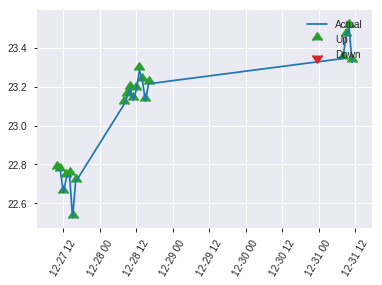


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2535154993660521
RMSE: 0.5035032267682622
LogLoss: 0.7005285166435911
Mean Per-Class Error: 0.4429042904290429
AUC: 0.5084983498349835
pr_auc: 0.5259027264400422
Gini: 0.016996699669967086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37602466344833374: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    99   0.9802   (99.0/101.0)
1      0    120  0        (0.0/120.0)
Total  2    219  0.448    (99.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376025     0.707965  218
max f2                       0.376025     0.858369  218
max f0point5                 0.450825     0.619048  179
max accuracy                 0.450825     0.58371   179
max precision                0.695366     0.666667  2
max recall                   0.376025     1         218
max specificity              0.720408     0.990099  0
max absolute_mcc             0.450825     0.146338  179
max min_per_class_accuracy   0.505775     0.49505   110
max mean_per_class_accuracy  0.450825     0.557096  179

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.693357           1.22778   1.22778            0.666667         0.707343  0.666667                    0.707343            0.0166667       0.0166667                  22.7778   22.7778
    2        0.0226244                   0.684034           0         0.736667           0                0.68527   0.4                         0.698514            0               0.0166667                  -100      -26.3333
    3        0.0316742                   0.673862           0.920833  0.789286           0.5              0.68091   0.428571                    0.693484            0.00833333      0.025                      -7.91667  -21.0714
    4        0.040724                    0.659128           0.920833  0.818519           0.5              0.668044  0.444444                    0.687831            0.00833333      0.0333333                  -7.91667  -18.1481
    5        0.0542986                   0.650582           0.613889  0.767361           0.333333         0.653447  0.416667                    0.679235            0.00833333      0.0416667                  -38.6111  -23.2639
    6        0.104072                    0.578011           0.669697  0.720652           0.363636         0.604715  0.391304                    0.643595            0.0333333       0.075                      -33.0303  -27.9348
    7        0.153846                    0.55975            1.00455   0.8125             0.545455         0.564574  0.441176                    0.618029            0.05            0.125                      0.454545  -18.75
    8        0.20362                     0.5492             1.17197   0.90037            0.636364         0.552724  0.488889                    0.602066            0.0583333       0.183333                   17.197    -9.96296
    9        0.303167                    0.531391           1.08826   0.962065           0.590909         0.53919   0.522388                    0.58142             0.108333        0.291667                   8.82576   -3.79353
    10       0.402715                    0.519377           0.837121  0.93118            0.454545         0.524496  0.505618                    0.567349            0.0833333       0.375                      -16.2879  -6.88202
    11       0.502262                    0.505775           1.25568   0.995495           0.681818         0.512135  0.540541                    0.556406            0.125           0.5                        25.5682   -0.45045
    12       0.60181                     0.489037           1.25568   1.03853            0.681818         0.497365  0.56391                     0.546639            0.125           0.625                      25.5682   3.85338
    13       0.701357                    0.473431           1.17197   1.05747            0.636364         0.479203  0.574194                    0.537068            0.116667        0.741667                   17.197    5.74731
    14       0.800905                    0.456195           1.00455   1.05089            0.545455         0.463308  0.570621                    0.5279              0.1             0.841667                   0.454545  5.08945
    15       0.900452                    0.433689           0.920833  1.03652            0.5              0.444183  0.562814                    0.518645            0.0916667       0.933333                   -7.91667  3.65159
    16       1                           0.273676           0.669697  1                  0.363636         0.406464  0.542986                    0.507477 

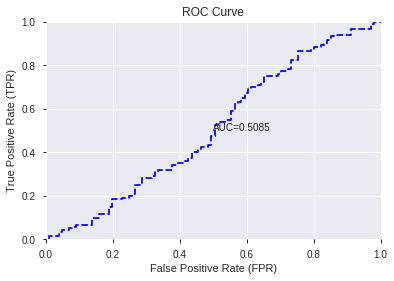

This function is available for GLM models only


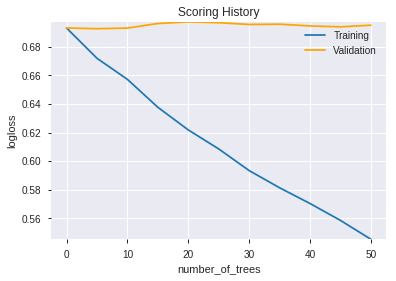

--2019-07-25 06:37:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190725_063618',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190725_063618',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_8bc5',
   'type

In [0]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190725_063712  0.528300  0.779964              0.495050  0.533256  0.284362
1  DeepLearning_grid_1_AutoML_20190725_063712_model_7  0.515512  0.880294              0.482797  0.547768  0.300049
2  DeepLearning_grid_1_AutoML_20190725_063712_model_1  0.504002  2.393770              0.500000  0.658963  0.434232
3  DeepLearning_grid_1_AutoML_20190725_063712_model_4  0.503960  0.882711              0.478630  0.561759  0.315573
4  DeepLearning_grid_1_AutoML_20190725_063712_model_3  0.501485  1.049180              0.500000  0.588539  0.346378
5  DeepLearning_grid_1_AutoML_20190725_063712_model_8  0.500000  0.693592              0.500000  0.500222  0.250222
6  DeepLearning_grid_1_AutoML_20190725_063712_model_5  0.493812  0.696396              0.490099  0.501594  0.251597
7  DeepLearning_grid_1_AutoML_20190725_063712_model_2  0.490594  1.812401              0.490099  0.640489  0.410227
8  DeepLearning_grid_1_AutoML_20190725_063712_model_6  0.472442  0.697554              0.482797  0.502087  0.252091
9  DeepLearning_grid_1_AutoML_20190725_063712_model_9  0.466419  0.698933              0.500000  0.502880  0.252888

variable  relative_importance  scaled_importance  percentage
0            AROONOSC_12             1.000000           1.000000    0.028064
1                 ADX_20             0.997354           0.997354    0.027990
2             weekofyear             0.900529           0.900529    0.025272
3              CORREL_12             0.893024           0.893024    0.025062
4              dayofyear             0.882191           0.882191    0.024758
5                  VAR_8             0.867757           0.867757    0.024353
6                NATR_30             0.853257           0.853257    0.023946
7                 ATR_20             0.838355           0.838355    0.023527
8                  DX_20             0.795218           0.795218    0.022317
9           weekday_name             0.794644           0.794644    0.022301
10                 DX_30             0.786968           0.786968    0.022085
11                   day             0.780188           0.780188    0.021895
12               NATR_12             0.775262           0.775262    0.021757
13                  SINH             0.760594           0.760594    0.021345
14                  DX_8             0.756977           0.756977    0.021244
15                ADX_12             0.755376           0.755376    0.021199
16                  week             0.752414           0.752414    0.021116
17            AROONOSC_8             0.748366           0.748366    0.021002
18          HT_TRENDMODE             0.737902           0.737902    0.020708
19               ADXR_14             0.736084           0.736084    0.020657
20                 DX_24             0.733444           0.733444    0.020583
21                   DIV             0.728972           0.728972    0.020458
22          aroondown_12             0.728895           0.728895    0.020456
23               BETA_12             0.709638           0.709638    0.019915
24                 month             0.708258           0.708258    0.019876
25             CORREL_14             0.704152           0.704152    0.019761
26                   BOP             0.699704           0.699704    0.019636
27            aroonup_24             0.695664           0.695664    0.019523
28         days_in_month             0.689596           0.689596    0.019353
29  HT_PHASOR_quadrature             0.687533           0.687533    0.019295
30                 DX_12             0.686353           0.686353    0.019262
31          STOCHF_fastk             0.680884           0.680884    0.019108
32                   OBV             0.678012           0.678012    0.019028
33                ADX_14             0.666411           0.666411    0.018702
34                 DX_14             0.665694           0.665694    0.018682
35                 MFI_8             0.650232           0.650232    0.018248
36                  hour             0.648488           0.648488    0.018199
37                ATR_30             0.643052           0.643052    0.018046
38           HT_DCPERIOD             0.630962           0.630962    0.017707
39     HT_PHASOR_inphase             0.604416           0.604416    0.016962
40          aroondown_14             0.597983           0.597983    0.016782
41                SAREXT             0.590581           0.590581    0.016574
42        STOCHRSI_fastd             0.589761           0.589761    0.016551
43              CORREL_8             0.581831           0.581831    0.016328
44               ADXR_12             0.556444           0.556444    0.015616
45                   COS             0.556144           0.556144    0.015608
46        STOCHRSI_fastk             0.550685           0.550685    0.015454
47        MACDEXT_signal             0.545587           0.545587    0.015311
48                ADX_24             0.512317           0.512317    0.014378
49           aroondown_8             0.498976           0.498976    0.014003

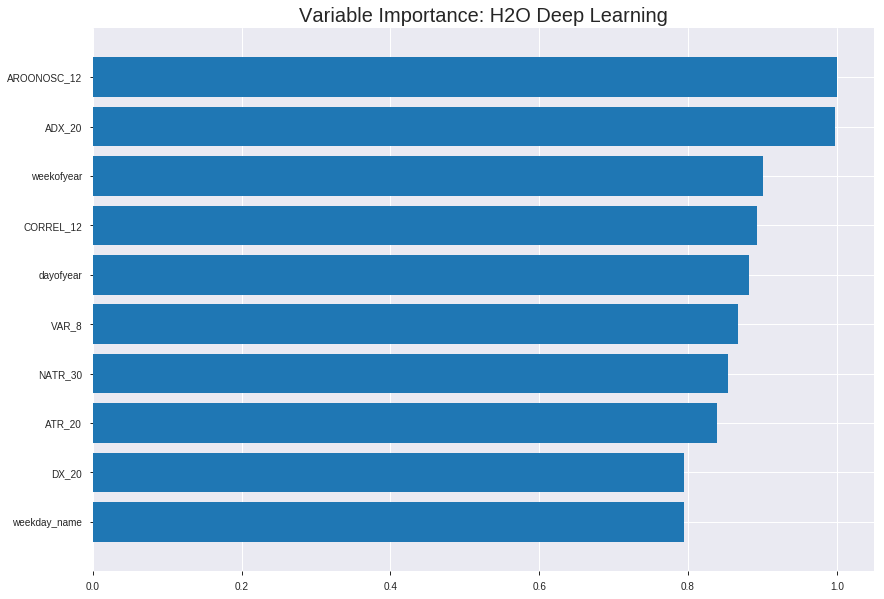

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190725_063712


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24023301286760745
RMSE: 0.49013570862324185
LogLoss: 0.6723834214262476
Mean Per-Class Error: 0.41610956555358514
AUC: 0.6109153716202019
pr_auc: 0.6365265650490379
Gini: 0.22183074324040386
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28276080304968954: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      31   708   0.9581   (708.0/739.0)
1      3    802   0.0037   (3.0/805.0)
Total  34   1510  0.4605   (711.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282761     0.692873  373
max f2                       0.282761     0.84778   373
max f0point5                 0.523435     0.602602  218
max accuracy                 0.542458     0.584845  203
max precision                0.96049      1         0
max recall                   0.08006      1         398
max specificity              0.96049      1         0
max absolute_mcc             0.657775     0.177126  110
max min_per_class_accuracy   0.549054     0.575101  198
max mean_per_class_accuracy  0.542458     0.58389   203

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 54.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.852391           1.67826   1.67826            0.875            0.8981    0.875                       0.8981              0.0173913       0.0173913                  67.8261   67.8261
    2        0.0200777                   0.812257           1.53441   1.60866            0.8              0.82801   0.83871                     0.864186            0.0149068       0.0322981                  53.441    60.8656
    3        0.0304404                   0.786488           1.31863   1.50992            0.6875           0.799391  0.787234                    0.842128            0.0136646       0.0459627                  31.8634   50.9925
    4        0.0401554                   0.775032           1.40654   1.48491            0.733333         0.780673  0.774194                    0.82726             0.0136646       0.0596273                  40.6542   48.4913
    5        0.0505181                   0.762494           1.55839   1.49998            0.8125           0.768288  0.782051                    0.815163            0.0161491       0.0757764                  55.8385   49.9984
    6        0.100389                    0.71511            1.39492   1.44779            0.727273         0.736716  0.754839                    0.776193            0.0695652       0.145342                   39.4918   44.779
    7        0.150259                    0.679993           1.24546   1.38064            0.649351         0.697113  0.719828                    0.749947            0.0621118       0.207453                   24.5463   38.0638
    8        0.20013                     0.656387           1.17073   1.32833            0.61039          0.667903  0.692557                    0.729502            0.0583851       0.265839                   17.0735   32.8332
    9        0.29987                     0.614852           0.971461  1.20963            0.506494         0.635109  0.63067                     0.698105            0.0968944       0.362733                   -2.85392  20.9632
    10       0.400259                    0.58286            1.11368   1.18557            0.580645         0.59908   0.618123                    0.673269            0.111801        0.474534                   11.3685   18.5568
    11       0.5                         0.550204           0.971461  1.14286            0.506494         0.56681   0.595855                    0.652032            0.0968944       0.571429                   -2.85392  14.2857
    12       0.599741                    0.51601            0.971461  1.11435            0.506494         0.533302  0.580994                    0.632287            0.0968944       0.668323                   -2.85392  11.4353
    13       0.70013                     0.481679           0.853825  1.077              0.445161         0.499867  0.561517                    0.613299            0.0857143       0.754037                   -14.6175  7.69968
    14       0.79987                     0.437113           0.871824  1.05141            0.454545         0.459454  0.548178                    0.594115            0.0869565       0.840994                   -12.8176  5.14125
    15       0.899611                    0.374223           0.909188  1.03564            0.474026         0.407162  0.539957                    0.573388            0.0906832       0.931677                   -9.08123  3.56439
    16       1                           0.0415838          0.680585  1                  0.354839         0.309502  0.521373                    0.546897          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2907043307369803
RMSE: 0.5391700387975766
LogLoss: 0.7984283743295798
Mean Per-Class Error: 0.4928709970287224
AUC: 0.459196517002311
pr_auc: 0.495525492847279
Gini: -0.08160696599537798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14165123472997218: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    207  0.9952   (207.0/208.0)
1      0    233  0        (0.0/233.0)
Total  1    440  0.4694   (207.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.141651     0.692422  398
max f2                       0.141651     0.849125  398
max f0point5                 0.359747     0.58475   386
max accuracy                 0.380773     0.53288   380
max precision                0.974033     1         0
max recall                   0.141651     1         398
max specificity              0.974033     1         0
max absolute_mcc             0.805425     0.103512  53
max min_per_class_accuracy   0.628043     0.467811  204
max mean_per_class_accuracy  0.380773     0.507129  380

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 62.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.915236           0.378541  0.378541           0.2              0.950202  0.2                         0.950202            0.00429185      0.00429185                 -62.1459  -62.1459
    2        0.0204082                   0.901279           0.946352  0.630901           0.5              0.906162  0.333333                    0.930629            0.00858369      0.0128755                  -5.36481  -36.9099
    3        0.031746                    0.872622           1.8927    1.08155            1                0.88806   0.571429                    0.915426            0.0214592       0.0343348                  89.2704   8.15451
    4        0.0408163                   0.858084           0.946352  1.0515             0.5              0.864257  0.555556                    0.904055            0.00858369      0.0429185                  -5.36481  5.15021
    5        0.0521542                   0.848903           0.757082  0.987498           0.4              0.853702  0.521739                    0.893109            0.00858369      0.0515021                  -24.2918  -1.25023
    6        0.102041                    0.81639            0.688256  0.841202           0.363636         0.828383  0.444444                    0.861465            0.0343348       0.0858369                  -31.1744  -15.8798
    7        0.151927                    0.791104           0.86032   0.847479           0.454545         0.805199  0.447761                    0.84299             0.0429185       0.128755                   -13.968   -15.2521
    8        0.201814                    0.759691           1.03238   0.893186           0.545455         0.772802  0.47191                     0.82564             0.0515021       0.180258                   3.23839   -10.6814
    9        0.301587                    0.719863           1.03238   0.939237           0.545455         0.740874  0.496241                    0.797597            0.103004        0.283262                   3.23839   -6.07635
    10       0.401361                    0.676877           0.903336  0.930312           0.477273         0.698645  0.491525                    0.772999            0.0901288       0.373391                   -9.66641  -6.96879
    11       0.501134                    0.627754           0.989368  0.94207            0.522727         0.652017  0.497738                    0.748912            0.0987124       0.472103                   -1.06321  -5.79302
    12       0.600907                    0.584171           0.989368  0.949923           0.522727         0.606402  0.501887                    0.72525             0.0987124       0.570815                   -1.06321  -5.00769
    13       0.70068                     0.527777           1.11842   0.973916           0.590909         0.552834  0.514563                    0.700699            0.111588        0.682403                   11.8416   -2.60844
    14       0.800454                    0.486424           0.86032   0.959756           0.454545         0.507311  0.507082                    0.676594            0.0858369       0.76824                    -13.968   -4.02437
    15       0.900227                    0.431048           1.29048   0.996411           0.681818         0.463305  0.526448                    0.652955            0.128755        0.896996                   29.048    -0.358915
    16       1                           0.133463           1.03238   1                  0.545455         0.363628  0.528345                    0.6


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:37:13  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:37:13  0.184 sec   81263 obs/sec     1         1             1544       0.568287         0.898176            -0.294167      0.480958        0.514183           0.83913          0.478627                         0.569074           0.898334              -0.299559        0.484504          0.510584             0.757082           0.460317
    2019-07-25 06:37:13  0.429 sec   63020 obs/sec     10        10            15440      0.490136         0.672383            0.0373089      0.610915        0.636527           1.67826          0.460492                         0.53917            0.798428              -0.166566        0.459197          0.495525             0.378541           0.469388

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
AROONOSC_12     1.0                    1.0                  0.028063771284797798
ADX_20          0.9973539113998413     0.9973539113998413   0.027989512059523634
weekofyear      0.9005287289619446     0.9005287289619446   0.02527223228497768
CORREL_12       0.8930241465568542     0.8930241465568542   0.025061625400773307
dayofyear       0.8821905851364136     0.8821905851364136   0.02475759481087025
---             ---                    ---                  ---
COS             0.5561444759368896     0.5561444759368896   0.015607511373996604
STOCHRSI_fastk  0.5506851673126221     0.5506851673126221   0.015454302585392035
MACDEXT_signal  0.5455873608589172     0.5455873608589172   0.015311238911021097
ADX_24          0.5123171210289001     0.5123171210289001   0.014377550509841127
aroondown_8     0.49897584319114685    0.49897584319114685  0.014003143939955477


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5475113122171946)

('F1', 0.7058823529411764)

('auc', 0.5283003300330034)

('logloss', 0.7799641358358821)

('mean_per_class_error', 0.4464521452145215)

('rmse', 0.5332562947649875)

('mse', 0.2843622759064832)

deeplearning prediction progress: |███████████████████████████████████████| 100%


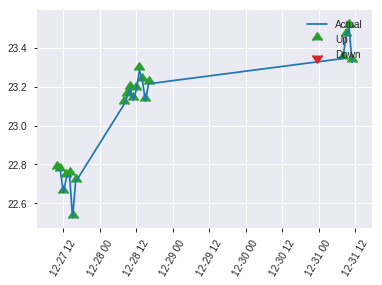


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2843622759064832
RMSE: 0.5332562947649875
LogLoss: 0.7799641358358821
Mean Per-Class Error: 0.4464521452145215
AUC: 0.5283003300330034
pr_auc: 0.5987603997622064
Gini: 0.056600660066006725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3235081766665362: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    100  0.9901   (100.0/101.0)
1      0    120  0        (0.0/120.0)
Total  1    220  0.4525   (100.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323508     0.705882  219
max f2                       0.323508     0.857143  219
max f0point5                 0.323508     0.6       219
max accuracy                 0.732135     0.547511  95
max precision                0.966995     1         0
max recall                   0.323508     1         219
max specificity              0.966995     1         0
max absolute_mcc             0.901781     0.156022  9
max min_per_class_accuracy   0.713342     0.533333  109
max mean_per_class_accuracy  0.732135     0.553548  95

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 68.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.940929           1.84167   1.84167            1                0.954071  1                           0.954071            0.025           0.025                      84.1667   84.1667
    2        0.0226244                   0.924989           0.920833  1.47333            0.5              0.930852  0.8                         0.944783            0.00833333      0.0333333                  -7.91667  47.3333
    3        0.0316742                   0.903848           1.84167   1.57857            1                0.91157   0.857143                    0.935294            0.0166667       0.05                       84.1667   57.8571
    4        0.040724                    0.902022           1.84167   1.63704            1                0.9033    0.888889                    0.928184            0.0166667       0.0666667                  84.1667   63.7037
    5        0.0542986                   0.896091           0.613889  1.38125            0.333333         0.899139  0.75                        0.920923            0.00833333      0.075                      -38.6111  38.125
    6        0.104072                    0.856114           1.00455   1.20109            0.545455         0.875504  0.652174                    0.899201            0.05            0.125                      0.454545  20.1087
    7        0.153846                    0.826813           1.33939   1.24583            0.727273         0.840266  0.676471                    0.880134            0.0666667       0.191667                   33.9394   24.5833
    8        0.20362                     0.809005           0.837121  1.14593            0.454545         0.817474  0.622222                    0.864817            0.0416667       0.233333                   -16.2879  14.5926
    9        0.303167                    0.773992           1.08826   1.12699            0.590909         0.789151  0.61194                     0.839971            0.108333        0.341667                   8.82576   12.699
    10       0.402715                    0.739102           0.920833  1.07603            0.5              0.753973  0.58427                     0.818713            0.0916667       0.433333                   -7.91667  7.603
    11       0.502262                    0.710053           1.00455   1.06186            0.545455         0.725551  0.576577                    0.800249            0.1             0.533333                   0.454545  6.18619
    12       0.60181                     0.683907           0.669697  0.996992           0.363636         0.694331  0.541353                    0.782729            0.0666667       0.6                        -33.0303  -0.300752
    13       0.701357                    0.621631           1.17197   1.02183            0.636364         0.64878   0.554839                    0.763717            0.116667        0.716667                   17.197    2.1828
    14       0.800905                    0.555621           0.669697  0.97806            0.363636         0.591407  0.531073                    0.7423              0.0666667       0.783333                   -33.0303  -2.19397
    15       0.900452                    0.476799           0.920833  0.971734           0.5              0.51548   0.527638                    0.717224            0.0916667       0.875                      -7.91667  -2.82663
    16       1                           0.200525           1.25568   1                  0.681818         0.414249  0.542986                    0.687064          

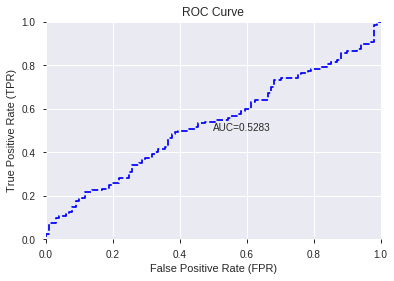

This function is available for GLM models only


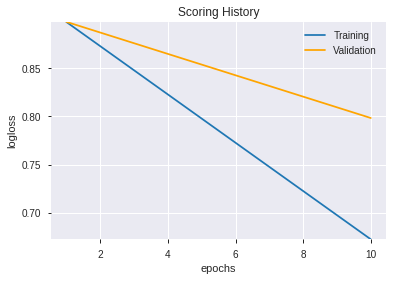

--2019-07-25 06:45:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190725_063712',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190725_063712',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_8bc5'

['AROONOSC_12',
 'ADX_20',
 'weekofyear',
 'CORREL_12',
 'dayofyear',
 'VAR_8',
 'NATR_30',
 'ATR_20',
 'DX_20',
 'weekday_name',
 'DX_30',
 'day',
 'NATR_12',
 'SINH',
 'DX_8',
 'ADX_12',
 'week',
 'AROONOSC_8',
 'HT_TRENDMODE',
 'ADXR_14',
 'DX_24',
 'DIV',
 'aroondown_12',
 'BETA_12',
 'month',
 'CORREL_14',
 'BOP',
 'aroonup_24',
 'days_in_month',
 'HT_PHASOR_quadrature',
 'DX_12',
 'STOCHF_fastk',
 'OBV',
 'ADX_14',
 'DX_14',
 'MFI_8',
 'hour',
 'ATR_30',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'aroondown_14',
 'SAREXT',
 'STOCHRSI_fastd',
 'CORREL_8',
 'ADXR_12',
 'COS',
 'STOCHRSI_fastk',
 'MACDEXT_signal',
 'ADX_24',
 'aroondown_8']

In [0]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_064557_model_1  0.485396  0.694904               0.49505  0.500808  0.250808

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature             0.042429           1.000000    0.057039
1         MACDEXT_signal             0.036268           0.854786    0.048756
2                    OBV             0.033471           0.788864    0.044996
3            AROONOSC_12             0.028363           0.668467    0.038129
4           HT_TRENDMODE             0.027526           0.648745    0.037004
5             weekofyear             0.027352           0.644654    0.036771
6                   week             0.027318           0.643855    0.036725
7              dayofyear             0.026661           0.628361    0.035841
8                  month             0.025063           0.590700    0.033693
9               CORREL_8             0.022523           0.530825    0.030278
10                  SINH             0.022328           0.526230    0.030016
11                ADX_24             0.022030           0.519226    0.029616
12                 VAR_8             0.021464           0.505868    0.028854
13            aroonup_24             0.021403           0.504450    0.028774
14             CORREL_12             0.019997           0.471298    0.026883
15                SAREXT             0.018870           0.444732    0.025367
16                   day             0.018051           0.425436    0.024267
17                ADX_20             0.017957           0.423212    0.024140
18               NATR_12             0.017584           0.414421    0.023638
19                ADX_12             0.017504           0.412543    0.023531
20                ATR_20             0.017205           0.405487    0.023129
21                  DX_8             0.017147           0.404128    0.023051
22        STOCHRSI_fastk             0.015790           0.372137    0.021227
23                  hour             0.015656           0.368994    0.021047
24           aroondown_8             0.015450           0.364131    0.020770
25          aroondown_12             0.013672           0.322240    0.018380
26     HT_PHASOR_inphase             0.012826           0.302297    0.017243
27                ATR_30             0.011431           0.269406    0.015367
28               ADXR_14             0.011281           0.265875    0.015165
29          weekday_name             0.011280           0.265846    0.015164
30           HT_DCPERIOD             0.010212           0.240683    0.013728
31                 DX_30             0.009932           0.234072    0.013351
32               ADXR_12             0.009423           0.222077    0.012667
33            AROONOSC_8             0.009081           0.214020    0.012208
34                   DIV             0.008302           0.195656    0.011160
35                 DX_14             0.007321           0.172544    0.009842
36                ADX_14             0.006633           0.156336    0.008917
37               NATR_30             0.006205           0.146253    0.008342
38                   COS             0.006103           0.143841    0.008205
39                 DX_24             0.005654           0.133259    0.007601
40          aroondown_14             0.004989           0.117594    0.006707
41        STOCHRSI_fastd             0.004986           0.117515    0.006703
42                   BOP             0.004820           0.113609    0.006480
43             CORREL_14             0.004080           0.096149    0.005484
44                 MFI_8             0.003886           0.091582    0.005224
45                 DX_12             0.003569           0.084105    0.004797
46                 DX_20             0.001423           0.033539    0.001913
47               BETA_12             0.000738           0.017398    0.000992
48          STOCHF_fastk             0.000334           0.007875    0.000449
49         days_in_month             0.000272           0.006417    0.000366

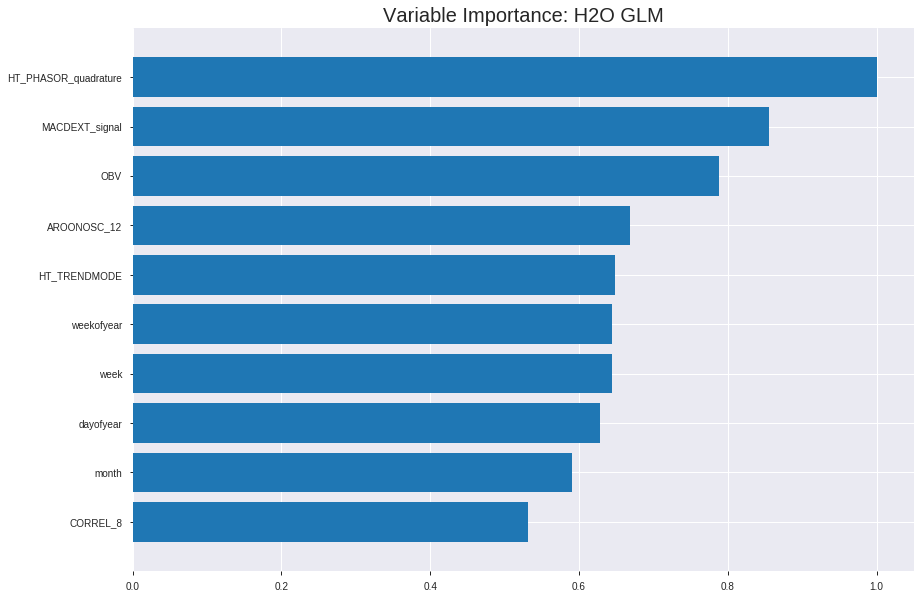

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_064557_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2466424844604925
RMSE: 0.4966311352105227
LogLoss: 0.6863960237175913
Null degrees of freedom: 1543
Residual degrees of freedom: 1493
Null deviance: 2137.6163902402923
Residual deviance: 2119.590921239922
AIC: 2221.590921239922
AUC: 0.5702619790046983
pr_auc: 0.58593282592606
Gini: 0.14052395800939665
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4406844454773061: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    735   0.9946   (735.0/739.0)
1      1    804   0.0012   (1.0/805.0)
Total  5    1539  0.4767   (736.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440684     0.686007  395
max f2                       0.429339     0.845233  397
max f0point5                 0.505388     0.588355  263
max accuracy                 0.50948      0.562824  249
max precision                0.618045     1         0
max recall                   0.429339     1         397
max specificity              0.618045     1         0
max absolute_mcc             0.50948      0.118856  249
max min_per_class_accuracy   0.521388     0.55528   209
max mean_per_class_accuracy  0.517764     0.558957  220

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.595987           1.43851   1.43851            0.75             0.606498  0.75                        0.606498            0.0149068       0.0149068                  43.8509   43.8509
    2        0.0200777                   0.587824           1.15081   1.2993             0.6              0.591223  0.677419                    0.599107            0.0111801       0.026087                   15.0807   29.9299
    3        0.0304404                   0.583571           1.19876   1.26507            0.625            0.585829  0.659574                    0.594587            0.0124224       0.0385093                  19.8758   26.5072
    4        0.0401554                   0.579027           1.40654   1.2993             0.733333         0.581229  0.677419                    0.591355            0.0136646       0.0521739                  40.6542   29.9299
    5        0.0505181                   0.576878           0.83913   1.20491            0.4375           0.578039  0.628205                    0.588624            0.00869565      0.0608696                  -16.087   20.4905
    6        0.100389                    0.564533           1.27037   1.23743            0.662338         0.570475  0.645161                    0.579608            0.063354        0.124224                   27.0372   23.7427
    7        0.150259                    0.557184           1.27037   1.24836            0.662338         0.561077  0.650862                    0.573458            0.063354        0.187578                   27.0372   24.8362
    8        0.20013                     0.551061           1.09601   1.2104             0.571429         0.554065  0.631068                    0.568625            0.0546584       0.242236                   9.60071   21.0396
    9        0.29987                     0.540668           0.959006  1.12678            0.5              0.545217  0.587473                    0.560839            0.0956522       0.337888                   -4.09938  12.6781
    10       0.400259                    0.529989           1.08894   1.11729            0.567742         0.53512   0.582524                    0.554389            0.109317        0.447205                   8.89361   11.7289
    11       0.5                         0.521467           1.0711    1.10807            0.558442         0.525406  0.57772                     0.548607            0.106832        0.554037                   7.10978   10.8075
    12       0.599741                    0.511716           0.983915  1.08743            0.512987         0.516219  0.566955                    0.543221            0.0981366       0.652174                   -1.60845  8.7426
    13       0.70013                     0.502306           0.890948  1.05925            0.464516         0.507006  0.552266                    0.538028            0.089441        0.741615                   -10.9052  5.92539
    14       0.79987                     0.491386           0.797096  1.02656            0.415584         0.496801  0.535223                    0.532887            0.0795031       0.821118                   -20.2904  2.65637
    15       0.899611                    0.478348           0.896733  1.01217            0.467532         0.485528  0.527718                    0.527637            0.089441        0.910559                   -10.3267  1.21693
    16       1                           0.422594           0.890948  1                  0.464516         0.465244  0.521373                    0.521373          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2469926715858302
RMSE: 0.49698357275249067
LogLoss: 0.6870693631860656
Null degrees of freedom: 440
Residual degrees of freedom: 390
Null deviance: 610.0237499842223
Residual deviance: 605.9951783301099
AIC: 707.9951783301099
AUC: 0.5654919115219544
pr_auc: 0.5885695835048452
Gini: 0.13098382304390888
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47649582386193423: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    205  0.9856   (205.0/208.0)
1      0    233  0        (0.0/233.0)
Total  3    438  0.4649   (205.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476496     0.694486  396
max f2                       0.476496     0.850365  396
max f0point5                 0.546477     0.595533  227
max accuracy                 0.547284     0.571429  225
max precision                0.629224     0.75      3
max recall                   0.476496     1         396
max specificity              0.664044     0.995192  0
max absolute_mcc             0.547284     0.138209  225
max min_per_class_accuracy   0.550198     0.557692  208
max mean_per_class_accuracy  0.547284     0.568886  225

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 55.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.628609           1.13562   1.13562            0.6              0.645433  0.6                         0.645433            0.0128755       0.0128755                  13.5622   13.5622
    2        0.0204082                   0.626021           1.41953   1.2618             0.75             0.627548  0.666667                    0.637484            0.0128755       0.0257511                  41.9528   26.1803
    3        0.031746                    0.618228           1.51416   1.35193            0.8              0.622165  0.714286                    0.632013            0.0171674       0.0429185                  51.4163   35.1931
    4        0.0408163                   0.615047           1.41953   1.36695            0.75             0.615579  0.722222                    0.628361            0.0128755       0.055794                   41.9528   36.6953
    5        0.0521542                   0.612435           1.13562   1.31666            0.6              0.613751  0.695652                    0.625185            0.0128755       0.0686695                  13.5622   31.6664
    6        0.102041                    0.598915           1.20445   1.2618             0.636364         0.604971  0.666667                    0.615302            0.0600858       0.128755                   20.4448   26.1803
    7        0.151927                    0.587818           1.29048   1.27122            0.681818         0.592466  0.671642                    0.607804            0.0643777       0.193133                   29.048    27.1219
    8        0.201814                    0.580323           0.86032   1.16965            0.454545         0.584193  0.617978                    0.601967            0.0429185       0.236052                   -13.968   16.9648
    9        0.301587                    0.571918           0.903336  1.08155            0.477273         0.575877  0.571429                    0.593336            0.0901288       0.32618                    -9.66641  8.15451
    10       0.401361                    0.561501           1.11842   1.09071            0.590909         0.566119  0.576271                    0.58657             0.111588        0.437768                   11.8416   9.07107
    11       0.501134                    0.55049            1.16143   1.10479            0.613636         0.556461  0.58371                     0.580576            0.11588         0.553648                   16.1432   10.4791
    12       0.600907                    0.542507           0.989368  1.08563            0.522727         0.546732  0.573585                    0.574956            0.0987124       0.652361                   -1.06321  8.56264
    13       0.70068                     0.535234           0.86032   1.05354            0.454545         0.538697  0.556634                    0.569793            0.0858369       0.738197                   -13.968   5.35439
    14       0.800454                    0.524045           0.774288  1.01874            0.409091         0.529628  0.538244                    0.564787            0.0772532       0.815451                   -22.5712  1.87358
    15       0.900227                    0.513466           1.0754    1.02502            0.568182         0.518537  0.541562                    0.559661            0.107296        0.922747                   7.53999   2.50159
    16       1                           0.464798           0.774288  1                  0.409091         0.499421  0.528345                    0.55365          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 06:45:57  0.000 sec   2            2.5       51            1.38091           1.37914
    2019-07-25 06:45:57  0.013 sec   4            1.5       51            1.3797            1.37792
    2019-07-25 06:45:57  0.023 sec   6            0.95      51            1.37829           1.37669
    2019-07-25 06:45:57  0.035 sec   8            0.59      51            1.37668           1.37556
    2019-07-25 06:45:57  0.046 sec   10           0.36      51            1.37485           1.37464
    2019-07-25 06:45:57  0.058 sec   12           0.23      51            1.37279           1.37414
    2019-07-25 06:45:57  0.076 sec   14           0.14      51            1.37056           1.37426
    2019-07-25 06:45:57  0.094 sec   16           0.087     51            1.36825           1.37521
    2019-07-25 06:45:57  0.104 sec   18           0.054     51            1.366             1.37703
    2019-07-25 06:45:57  0.116 sec   20           0.034     51            1.36397           1.37941
    2019-07-25 06:45:57  0.126 sec   22           0.021     51            1.36221           1.38176

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5475113122171946)

('F1', 0.7058823529411764)

('auc', 0.4853960396039604)

('logloss', 0.6949042666094756)

('mean_per_class_error', 0.4745874587458746)

('rmse', 0.5008078211627582)

('mse', 0.2508084737377892)

glm prediction progress: |████████████████████████████████████████████████| 100%


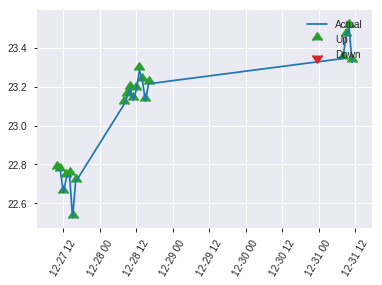


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2508084737377892
RMSE: 0.5008078211627582
LogLoss: 0.6949042666094756
Null degrees of freedom: 220
Residual degrees of freedom: 170
Null deviance: 305.1498983064551
Residual deviance: 307.1476858413882
AIC: 409.1476858413882
AUC: 0.4853960396039604
pr_auc: 0.5175676527834155
Gini: -0.029207920792079234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49024393625253115: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    100  0.9901   (100.0/101.0)
1      0    120  0        (0.0/120.0)
Total  1    220  0.4525   (100.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490244     0.705882  219
max f2                       0.490244     0.857143  219
max f0point5                 0.490244     0.6       219
max accuracy                 0.497516     0.547511  215
max precision                0.627061     0.666667  2
max recall                   0.490244     1         219
max specificity              0.647288     0.990099  0
max absolute_mcc             0.602515     0.144218  16
max min_per_class_accuracy   0.561124     0.508333  109
max mean_per_class_accuracy  0.565575     0.525413  97

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 56.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.627034           1.22778   1.22778            0.666667         0.637058  0.666667                    0.637058            0.0166667       0.0166667                  22.7778   22.7778
    2        0.0226244                   0.62235            0         0.736667           0                0.626399  0.4                         0.632794            0               0.0166667                  -100      -26.3333
    3        0.0316742                   0.613772           0.920833  0.789286           0.5              0.616069  0.428571                    0.628016            0.00833333      0.025                      -7.91667  -21.0714
    4        0.040724                    0.611018           0         0.613889           0                0.612304  0.333333                    0.624524            0               0.025                      -100      -38.6111
    5        0.0542986                   0.607468           0         0.460417           0                0.608608  0.25                        0.620545            0               0.025                      -100      -53.9583
    6        0.104072                    0.598765           0.837121  0.64058            0.454545         0.602456  0.347826                    0.611894            0.0416667       0.0666667                  -16.2879  -35.942
    7        0.153846                    0.591309           1.17197   0.8125             0.636364         0.594882  0.441176                    0.60639             0.0583333       0.125                      17.197    -18.75
    8        0.20362                     0.584551           1.50682   0.982222           0.818182         0.587371  0.533333                    0.601741            0.075           0.2                        50.6818   -1.77778
    9        0.303167                    0.575993           1.00455   0.989552           0.545455         0.578645  0.537313                    0.594157            0.1             0.3                        0.454545  -1.04478
    10       0.402715                    0.568866           1.08826   1.01395            0.590909         0.573138  0.550562                    0.588961            0.108333        0.408333                   8.82576   1.39513
    11       0.502262                    0.561078           1.00455   1.01209            0.545455         0.564305  0.54955                     0.584074            0.1             0.508333                   0.454545  1.20871
    12       0.60181                     0.554495           1.00455   1.01084            0.545455         0.557799  0.548872                    0.579728            0.1             0.608333                   0.454545  1.08396
    13       0.701357                    0.548072           0.837121  0.986183           0.454545         0.55175   0.535484                    0.575757            0.0833333       0.691667                   -16.2879  -1.38172
    14       0.800905                    0.539041           1.08826   0.99887            0.590909         0.543785  0.542373                    0.571783            0.108333        0.8                        8.82576   -0.112994
    15       0.900452                    0.523319           0.753409  0.971734           0.409091         0.530723  0.527638                    0.567244            0.075           0.875                      -24.6591  -2.82663
    16       1                           0.489134           1.25568   1                  0.681818         0.507779  0.542986                    0.561324

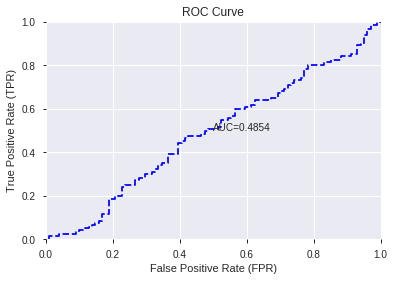

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


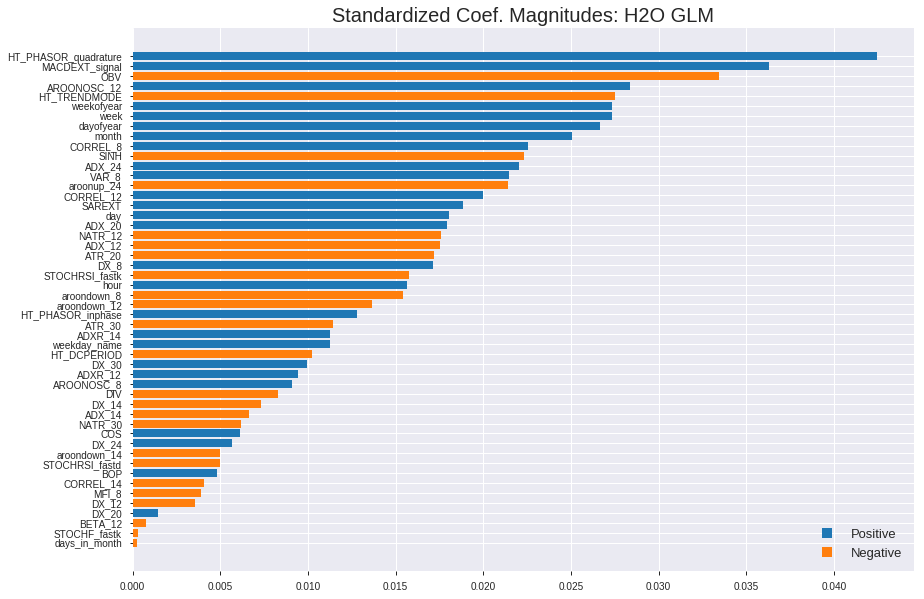

'log_likelihood'
--2019-07-25 06:46:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.140
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.140|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_064557_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_064557_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['HT_PHASOR_quadrature',
 'MACDEXT_signal',
 'OBV',
 'AROONOSC_12',
 'HT_TRENDMODE',
 'weekofyear',
 'week',
 'dayofyear',
 'month',
 'CORREL_8',
 'SINH',
 'ADX_24',
 'VAR_8',
 'aroonup_24',
 'CORREL_12',
 'SAREXT',
 'day',
 'ADX_20',
 'NATR_12',
 'ADX_12',
 'ATR_20',
 'DX_8',
 'STOCHRSI_fastk',
 'hour',
 'aroondown_8',
 'aroondown_12',
 'HT_PHASOR_inphase',
 'ATR_30',
 'ADXR_14',
 'weekday_name',
 'HT_DCPERIOD',
 'DX_30',
 'ADXR_12',
 'AROONOSC_8',
 'DIV',
 'DX_14',
 'ADX_14',
 'NATR_30',
 'COS',
 'DX_24',
 'aroondown_14',
 'STOCHRSI_fastd',
 'BOP',
 'CORREL_14',
 'MFI_8',
 'DX_12',
 'DX_20',
 'BETA_12',
 'STOCHF_fastk',
 'days_in_month']

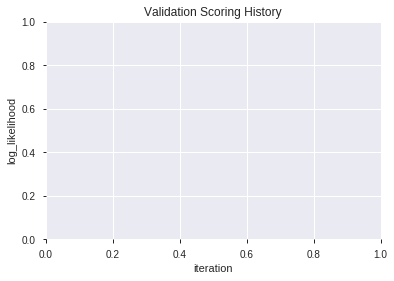

In [0]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_064611_model_1  0.574257  0.689527              0.461427  0.498070  0.248074
1  XGBoost_grid_1_AutoML_20190725_064611_model_7  0.561139  0.688655              0.480198  0.497678  0.247683
2  XGBoost_grid_1_AutoML_20190725_064611_model_4  0.552723  0.688007              0.495050  0.497373  0.247380
3               XGBoost_3_AutoML_20190725_064611  0.545050  0.693848              0.470297  0.500383  0.250384
4  XGBoost_grid_1_AutoML_20190725_064611_model_2  0.539521  0.691176              0.462995  0.498986  0.248987
5  XGBoost_grid_1_AutoML_20190725_064611_model_3  0.535149  0.695330              0.500000  0.501012  0.251013
6  XGBoost_grid_1_AutoML_20190725_064611_model_6  0.528053  0.693310              0.490099  0.500072  0.250072
7               XGBoost_1_AutoML_20190725_064611  0.512211  0.702906              0.495050  0.504771  0.254794
8  XGBoost_grid_1_AutoML_20190725_064611_model_5  0.502063  0.738638              0.500000  0.520175  0.270582
9               XGBoost_2_AutoML_20190725_064611  0.495462  0.705383              0.500000  0.505823  0.255857

variable  relative_importance  scaled_importance  percentage
0                    BOP           260.538391           1.000000    0.070086
1                    OBV           234.394012           0.899652    0.063053
2                  MFI_8           233.812820           0.897422    0.062896
3            HT_DCPERIOD           214.536255           0.823434    0.057711
4           STOCHF_fastk           174.038559           0.667996    0.046817
5   HT_PHASOR_quadrature           164.406250           0.631025    0.044226
6               CORREL_8           157.563217           0.604760    0.042385
7                    DIV           140.377029           0.538796    0.037762
8      HT_PHASOR_inphase           138.348740           0.531011    0.037216
9                   DX_8           126.681358           0.486229    0.034078
10                 DX_12           120.705147           0.463291    0.032470
11               NATR_30           116.046005           0.445408    0.031217
12             dayofyear           110.841888           0.425434    0.029817
13                 VAR_8           100.030067           0.383936    0.026908
14                  SINH            96.842834           0.371703    0.026051
15               BETA_12            95.700974           0.367320    0.025744
16                   COS            90.332649           0.346715    0.024300
17                ADX_12            83.661415           0.321110    0.022505
18                 DX_24            75.632668           0.290294    0.020345
19             CORREL_12            73.889809           0.283604    0.019877
20                 DX_14            68.344093           0.262319    0.018385
21             CORREL_14            61.206230           0.234922    0.016465
22               NATR_12            60.176201           0.230969    0.016188
23        STOCHRSI_fastd            59.673920           0.229041    0.016052
24               ADXR_14            59.419788           0.228065    0.015984
25                SAREXT            58.252769           0.223586    0.015670
26                   day            56.327480           0.216196    0.015152
27                 DX_30            47.156071           0.180995    0.012685
28                ATR_20            45.501366           0.174644    0.012240
29               ADXR_12            41.771038           0.160326    0.011237
30                ATR_30            39.586941           0.151943    0.010649
31        MACDEXT_signal            38.107265           0.146264    0.010251
32                  hour            33.112068           0.127091    0.008907
33          HT_TRENDMODE            30.427181           0.116786    0.008185
34                ADX_14            28.682493           0.110089    0.007716
35           AROONOSC_12            27.012238           0.103679    0.007266
36          weekday_name            23.330278           0.089546    0.006276
37                 DX_20            22.196949           0.085196    0.005971
38                ADX_20            21.802742           0.083683    0.005865
39            AROONOSC_8            19.546856           0.075025    0.005258
40           aroondown_8            15.248373           0.058526    0.004102
41                ADX_24            14.488824           0.055611    0.003898
42          aroondown_12            11.135964           0.042742    0.002996
43            aroonup_24             8.921267           0.034242    0.002400
44        STOCHRSI_fastk             7.880747           0.030248    0.002120
45            weekofyear             6.159210           0.023640    0.001657
46                 month             3.579145           0.013737    0.000963

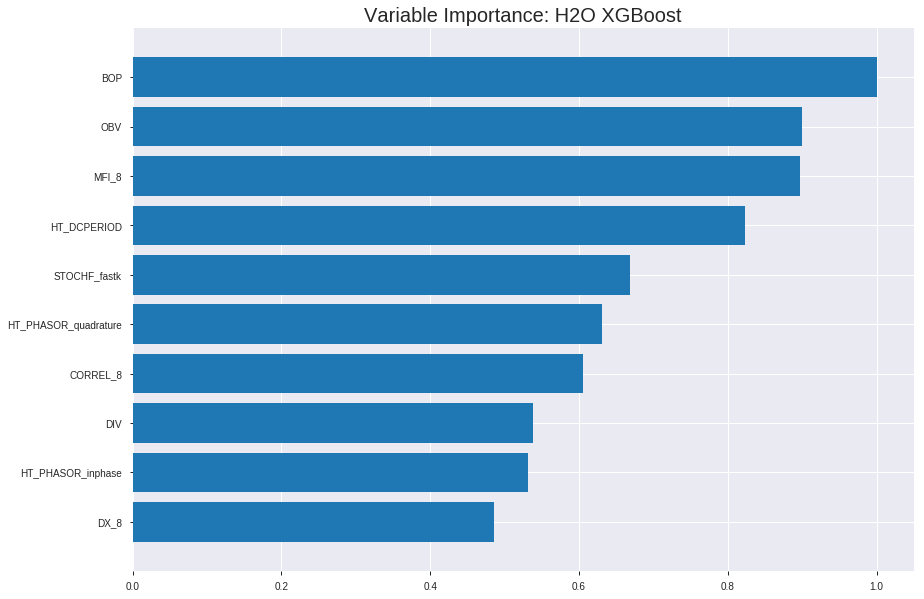

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_064611_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19243026290143017
RMSE: 0.4386687393711001
LogLoss: 0.5750433940563352
Mean Per-Class Error: 0.16294556182183406
AUC: 0.905218567982585
pr_auc: 0.910906102057767
Gini: 0.8104371359651701
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5074433286984762: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      584  155  0.2097   (155.0/739.0)
1      96   709  0.1193   (96.0/805.0)
Total  680  864  0.1626   (251.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507443     0.849611  215
max f2                       0.471894     0.890603  256
max f0point5                 0.542396     0.85295   174
max accuracy                 0.510063     0.838083  212
max precision                0.793525     1         0
max recall                   0.362362     1         355
max specificity              0.793525     1         0
max absolute_mcc             0.510063     0.675955  212
max min_per_class_accuracy   0.519922     0.832206  200
max mean_per_class_accuracy  0.517608     0.837054  203

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.723226           1.91801    1.91801            1                0.753792  1                           0.753792            0.0198758       0.0198758                  91.8012   91.8012
    2        0.0200777                   0.698543           1.91801    1.91801            1                0.713661  1                           0.734374            0.0186335       0.0385093                  91.8012   91.8012
    3        0.0304404                   0.687564           1.91801    1.91801            1                0.692667  1                           0.720176            0.0198758       0.0583851                  91.8012   91.8012
    4        0.0401554                   0.680858           1.91801    1.91801            1                0.683903  1                           0.7114              0.0186335       0.0770186                  91.8012   91.8012
    5        0.0505181                   0.671951           1.91801    1.91801            1                0.675996  1                           0.704138            0.0198758       0.0968944                  91.8012   91.8012
    6        0.100389                    0.646484           1.81838    1.86852            0.948052         0.658317  0.974194                    0.681375            0.0906832       0.187578                   81.8375   86.8515
    7        0.150259                    0.626116           1.86819    1.86841            0.974026         0.635967  0.974138                    0.666304            0.0931677       0.280745                   86.8194   86.8409
    8        0.20013                     0.606447           1.79347    1.84973            0.935065         0.616628  0.964401                    0.653925            0.089441        0.370186                   79.3466   84.9734
    9        0.29987                     0.5791             1.6191     1.77302            0.844156         0.592309  0.924406                    0.633431            0.161491        0.531677                   61.9101   77.3022
    10       0.400259                    0.55133            1.54678    1.71628            0.806452         0.565379  0.894822                    0.616363            0.15528         0.686957                   54.6784   71.628
    11       0.5                         0.522945           1.25792    1.62484            0.655844         0.535885  0.84715                     0.600309            0.125466        0.812422                   25.7917   62.4845
    12       0.599741                    0.495606           0.934097   1.50997            0.487013         0.509716  0.787257                    0.585243            0.0931677       0.90559                    -6.5903   50.9969
    13       0.70013                     0.467521           0.4331     1.35556            0.225806         0.481604  0.706753                    0.570382            0.0434783       0.949068                   -56.69    35.5561
    14       0.79987                     0.430911           0.286456   1.22225            0.149351         0.450678  0.637247                    0.555456            0.0285714       0.97764                    -71.3544  22.2248
    15       0.899611                    0.387033           0.137001   1.10193            0.0714286        0.41025   0.574514                    0.539357            0.0136646       0.991304                   -86.2999  10.1925
    16       1                           0.217115           0.0866199  1                  0.0451613        0.343666  0.521373                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25343131309994743
RMSE: 0.5034196193037648
LogLoss: 0.7002923824195191
Mean Per-Class Error: 0.4600425057774844
AUC: 0.5275565368108286
pr_auc: 0.5527306554607494
Gini: 0.05511307362165718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33301618695259094: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    202  0.9712   (202.0/208.0)
1      2    231  0.0086   (2.0/233.0)
Total  8    433  0.4626   (204.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.333016     0.693694   391
max f2                       0.238136     0.848507   399
max f0point5                 0.333016     0.587786   391
max accuracy                 0.481038     0.54195    215
max precision                0.792065     1          0
max recall                   0.238136     1          399
max specificity              0.792065     1          0
max absolute_mcc             0.713887     0.0903947  3
max min_per_class_accuracy   0.485879     0.532189   201
max mean_per_class_accuracy  0.481038     0.539957   215

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.704992           1.51416   1.51416            0.8              0.743656  0.8                         0.743656            0.0171674       0.0171674                  51.4163   51.4163
    2        0.0204082                   0.658179           0.946352  1.2618             0.5              0.676204  0.666667                    0.713677            0.00858369      0.0257511                  -5.36481  26.1803
    3        0.031746                    0.638206           0.757082  1.08155            0.4              0.647236  0.571429                    0.689948            0.00858369      0.0343348                  -24.2918  8.15451
    4        0.0408163                   0.63151            1.41953   1.15665            0.75             0.635774  0.611111                    0.677909            0.0128755       0.0472103                  41.9528   15.6652
    5        0.0521542                   0.627174           0.757082  1.06979            0.4              0.628396  0.565217                    0.667146            0.00858369      0.055794                   -24.2918  6.97891
    6        0.102041                    0.583058           0.946352  1.00944            0.5              0.602065  0.533333                    0.635328            0.0472103       0.103004                   -5.36481  0.944206
    7        0.151927                    0.570202           1.03238   1.01698            0.545455         0.576704  0.537313                    0.616079            0.0515021       0.154506                   3.23839   1.69752
    8        0.201814                    0.554453           1.20445   1.06332            0.636364         0.561141  0.561798                    0.602499            0.0600858       0.214592                   20.4448   6.33168
    9        0.301587                    0.522077           1.0754    1.06731            0.568182         0.539701  0.56391                     0.581724            0.107296        0.321888                   7.53999   6.73142
    10       0.401361                    0.505111           0.989368  1.04794            0.522727         0.514419  0.553672                    0.564992            0.0987124       0.420601                   -1.06321  4.79377
    11       0.501134                    0.485851           1.11842   1.06197            0.590909         0.493833  0.561086                    0.550825            0.111588        0.532189                   11.8416   6.19696
    12       0.600907                    0.46885            0.989368  1.04991            0.522727         0.477169  0.554717                    0.538595            0.0987124       0.630901                   -1.06321  4.9915
    13       0.70068                     0.445999           0.946352  1.03517            0.5              0.456806  0.546926                    0.526949            0.0944206       0.725322                   -5.36481  3.51681
    14       0.800454                    0.422806           0.774288  1.00265            0.409091         0.434393  0.529745                    0.515412            0.0772532       0.802575                   -22.5712  0.265049
    15       0.900227                    0.390687           0.86032   0.986876           0.454545         0.408137  0.521411                    0.503523            0.0858369       0.888412                   -13.968   -1.31242
    16       1                           0.238136           1.11842   1                  0.590909         0.353616  0.528345                    0.488566       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:46:14  0.015 sec   0                  0.5              0.693147            0.5             0                  1                0.478627                         0.5                0.693147              0.5               0                    1                  0.471655
    2019-07-25 06:46:14  0.083 sec   5                  0.490787         0.674859            0.733914        0.736103           1.80519          0.365933                         0.499642           0.692429              0.507315          0.532683             1.41953            0.46712
    2019-07-25 06:46:14  0.119 sec   10                 0.482223         0.658042            0.778131        0.782853           1.91801          0.318653                         0.499187           0.691507              0.515032          0.537906             1.08155            0.464853
    2019-07-25 06:46:14  0.153 sec   15                 0.475009         0.643996            0.808907        0.814698           1.91801          0.275259                         0.499133           0.691388              0.517508          0.539654             1.13562            0.462585
    2019-07-25 06:46:14  0.191 sec   20                 0.468432         0.631307            0.836694        0.842906           1.91801          0.24158                          0.498976           0.691057              0.523636          0.550352             1.8927             0.464853
    2019-07-25 06:46:15  0.323 sec   25                 0.463211         0.621314            0.853877        0.859115           1.91801          0.243523                         0.499194           0.691452              0.523388          0.546882             1.51416            0.462585
    2019-07-25 06:46:15  0.357 sec   30                 0.459481         0.614146            0.859194        0.864243           1.91801          0.215026                         0.499192           0.691458              0.53582           0.555636             1.51416            0.460317
    2019-07-25 06:46:15  0.392 sec   35                 0.455393         0.606317            0.866967        0.870417           1.91801          0.20272                          0.500213           0.693516              0.530105          0.550069             1.51416            0.462585
    2019-07-25 06:46:15  0.431 sec   40                 0.448448         0.593236            0.883144        0.889013           1.91801          0.189119                         0.50046            0.694042              0.536233          0.554164             1.51416            0.462585
    2019-07-25 06:46:15  0.470 sec   45                 0.442484         0.582163            0.898228        0.903232           1.91801          0.169041                         0.502304           0.697938              0.530022          0.552452             1.51416            0.462585
    2019-07-25 06:46:15  0.514 sec   50                 0.438669         0.575043            0.905219        0.910906           1.91801          0.162565                         0.50342            0.700292              0.527557          0.552731             1.51416            0.462585

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             260.53839111328125     1.0                   0.07008566676287399
OBV             234.39401245117188     0.8996524905585147    0.0630527446556737
MFI_8           233.8128204345703      0.8974217559089372    0.06289640213038702
HT_DCPERIOD     214.5362548828125      0.8234343275326853    0.057710943880567016
STOCHF_fastk    174.03855895996094     0.6679958305426456    0.046816933178401104
---             ---                    ---                   ---
aroondown_12    11.135964393615723     0.04274212466743084   0.0029956103061787743
aroonup_24      8.921266555786133      0.034241658274105156  0.002399849451207141
STOCHRSI_fastk  7.880747318267822      0.03024793115745195   0.002119946423367531
weekofyear      6.159210205078125      0.02364031718611527   0.0016568473924747178
month           3.5791449546813965     0.013737495420109491  0.0009628015261703014


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5972850678733032)

('F1', 0.7098765432098766)

('auc', 0.5742574257425742)

('logloss', 0.6895267206730069)

('mean_per_class_error', 0.4105198019801981)

('rmse', 0.4980700606045881)

('mse', 0.24807378527065807)

xgboost prediction progress: |████████████████████████████████████████████| 100%


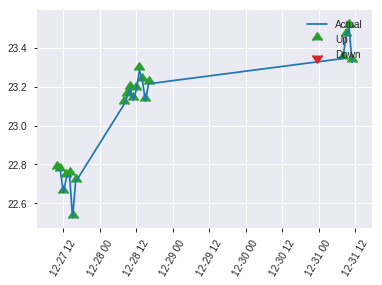


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24807378527065807
RMSE: 0.4980700606045881
LogLoss: 0.6895267206730069
Mean Per-Class Error: 0.4105198019801981
AUC: 0.5742574257425742
pr_auc: 0.5715404540874135
Gini: 0.14851485148514842
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38203638792037964: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      12   89   0.8812   (89.0/101.0)
1      5    115  0.0417   (5.0/120.0)
Total  17   204  0.4253   (94.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382036     0.709877  203
max f2                       0.296112     0.858369  218
max f0point5                 0.456227     0.628492  148
max accuracy                 0.456227     0.597285  148
max precision                0.598173     0.666667  17
max recall                   0.296112     1         218
max specificity              0.709101     0.990099  0
max absolute_mcc             0.429859     0.178486  174
max min_per_class_accuracy   0.493757     0.583333  111
max mean_per_class_accuracy  0.496041     0.58948   108

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 49.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.677889           0         0                  0                0.689259  0                           0.689259            0               0                          -100      -100
    2        0.0226244                   0.652038           0.920833  0.368333           0.5              0.662927  0.2                         0.678726            0.00833333      0.00833333                 -7.91667  -63.1667
    3        0.0316742                   0.640138           0.920833  0.52619            0.5              0.646433  0.285714                    0.6695              0.00833333      0.0166667                  -7.91667  -47.381
    4        0.040724                    0.633079           0.920833  0.613889           0.5              0.636539  0.333333                    0.662175            0.00833333      0.025                      -7.91667  -38.6111
    5        0.0542986                   0.620355           1.84167   0.920833           1                0.624632  0.5                         0.652789            0.025           0.05                       84.1667   -7.91667
    6        0.104072                    0.592889           1.33939   1.12101            0.727273         0.601586  0.608696                    0.628301            0.0666667       0.116667                   33.9394   12.1014
    7        0.153846                    0.576892           0.837121  1.02917            0.454545         0.583077  0.558824                    0.61367             0.0416667       0.158333                   -16.2879  2.91667
    8        0.20362                     0.559079           1.17197   1.06407            0.636364         0.567537  0.577778                    0.602393            0.0583333       0.216667                   17.197    6.40741
    9        0.303167                    0.535897           1.08826   1.07201            0.590909         0.547926  0.58209                     0.584508            0.108333        0.325                      8.82576   7.20149
    10       0.402715                    0.513867           1.08826   1.07603            0.590909         0.524262  0.58427                     0.569616            0.108333        0.433333                   8.82576   7.603
    11       0.502262                    0.495457           1.42311   1.14482            0.772727         0.502204  0.621622                    0.556255            0.141667        0.575                      42.3106   14.482
    12       0.60181                     0.477717           0.837121  1.09392            0.454545         0.486757  0.593985                    0.544759            0.0833333       0.658333                   -16.2879  9.39223
    13       0.701357                    0.450303           1.08826   1.09312            0.590909         0.462994  0.593548                    0.533154            0.108333        0.766667                   8.82576   9.31183
    14       0.800905                    0.42913            0.920833  1.0717             0.5              0.437459  0.581921                    0.521259            0.0916667       0.858333                   -7.91667  7.17043
    15       0.900452                    0.384596           0.837121  1.04577            0.454545         0.40839   0.567839                    0.508781            0.0833333       0.941667                   -16.2879  4.57705
    16       1                           0.248916           0.585985  1                  0.318182         0.347675  0.542986                    0.492744            

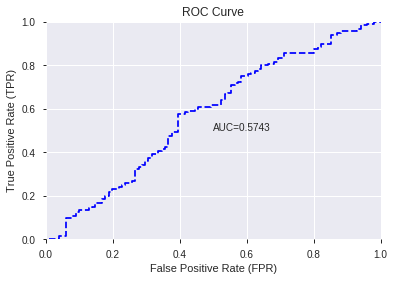

This function is available for GLM models only


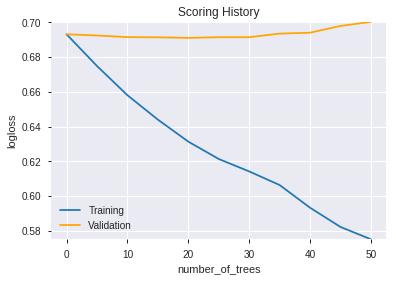

--2019-07-25 06:46:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_064611_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_064611_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'OBV',
 'MFI_8',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'DIV',
 'HT_PHASOR_inphase',
 'DX_8',
 'DX_12',
 'NATR_30',
 'dayofyear',
 'VAR_8',
 'SINH',
 'BETA_12',
 'COS',
 'ADX_12',
 'DX_24',
 'CORREL_12',
 'DX_14',
 'CORREL_14',
 'NATR_12',
 'STOCHRSI_fastd',
 'ADXR_14',
 'SAREXT',
 'day',
 'DX_30',
 'ATR_20',
 'ADXR_12',
 'ATR_30',
 'MACDEXT_signal',
 'hour',
 'HT_TRENDMODE',
 'ADX_14',
 'AROONOSC_12',
 'weekday_name',
 'DX_20',
 'ADX_20',
 'AROONOSC_8',
 'aroondown_8',
 'ADX_24',
 'aroondown_12',
 'aroonup_24',
 'STOCHRSI_fastk',
 'weekofyear',
 'month']

In [0]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 933] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_064634_model_4  0.544472  1.209662              0.479414  0.593754  0.352544
1  DeepLearning_grid_1_AutoML_20190725_064634_model_5  0.536304  0.690182              0.495050  0.498516  0.248518
2  DeepLearning_grid_1_AutoML_20190725_064634_model_1  0.518152  2.639972              0.495050  0.624077  0.389472
3               DeepLearning_1_AutoML_20190725_064634  0.513036  0.687791              0.500000  0.497340  0.247347
4  DeepLearning_grid_1_AutoML_20190725_064634_model_7  0.501444  0.710159              0.500000  0.508375  0.258445
5  DeepLearning_grid_1_AutoML_20190725_064634_model_3  0.501403  0.763891              0.485149  0.532441  0.283494
6  DeepLearning_grid_1_AutoML_20190725_064634_model_9  0.500000  0.689866              0.500000  0.498358  0.248361
7  DeepLearning_grid_1_AutoML_20190725_064634_model_8  0.500000  0.696022              0.500000  0.501435  0.251437
8  DeepLearning_grid_1_AutoML_20190725_064634_model_6  0.475825  0.698160              0.484365  0.502497  0.252504
9  DeepLearning_grid_1_AutoML_20190725_064634_model_2  0.474752  0.936154              0.495050  0.588675  0.346538

variable  relative_importance  scaled_importance  percentage
0              CDLLADDERBOTTOM             1.000000           1.000000    0.002668
1             CDLCOUNTERATTACK             0.945577           0.945577    0.002522
2               CDL3BLACKCROWS             0.900003           0.900003    0.002401
3           CDLEVENINGDOJISTAR             0.899211           0.899211    0.002399
4           CDLIDENTICAL3CROWS             0.894304           0.894304    0.002386
...                        ...                  ...                ...         ...
1030  BBANDS_middleband_24_6_4             0.321318           0.321318    0.000857
1031    BBANDS_upperband_8_8_2             0.320436           0.320436    0.000855
1032  BBANDS_middleband_20_3_5             0.319284           0.319284    0.000852
1033   BBANDS_lowerband_14_3_3             0.318481           0.318481    0.000850
1034                    SMA_14             0.317914           0.317914    0.000848

[1035 rows x 4 columns]

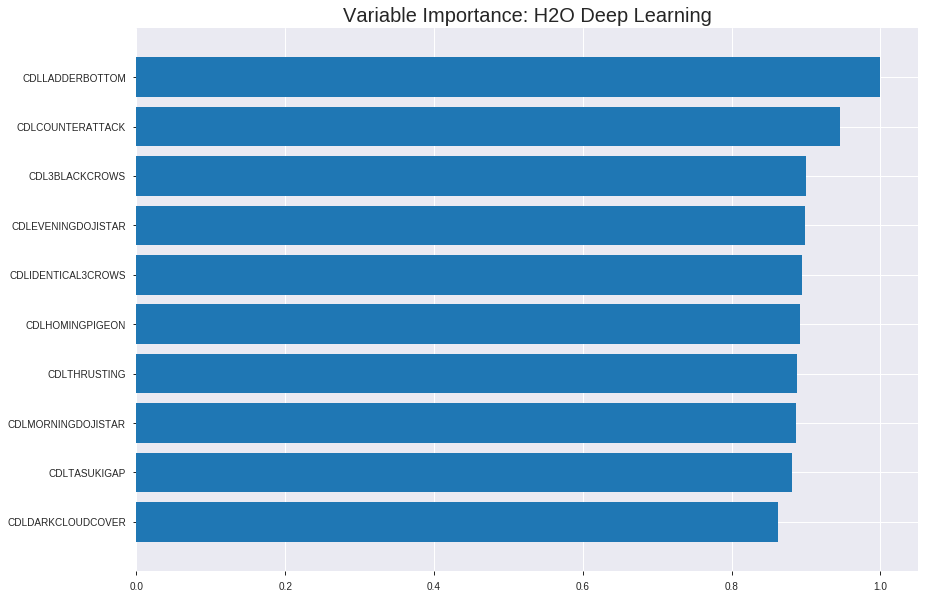

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_064634_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28337485058681056
RMSE: 0.5323296446627884
LogLoss: 0.8456208247776649
Mean Per-Class Error: 0.39704317568646563
AUC: 0.6343590045302112
pr_auc: 0.6592356795423134
Gini: 0.2687180090604224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.024507532526407805: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      45   694   0.9391   (694.0/739.0)
1      15   790   0.0186   (15.0/805.0)
Total  60   1484  0.4592   (709.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0245075    0.690258  386
max f2                       0.000195573  0.844878  399
max f0point5                 0.271128     0.619866  253
max accuracy                 0.271128     0.603627  253
max precision                0.997181     1         0
max recall                   0.000195573  1         399
max specificity              0.997181     1         0
max absolute_mcc             0.49071      0.210258  162
max min_per_class_accuracy   0.287325     0.595399  246
max mean_per_class_accuracy  0.271128     0.602957  253

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 35.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.957897           1.43851   1.43851            0.75             0.976763   0.75                        0.976763            0.0149068       0.0149068                  43.8509   43.8509
    2        0.0200777                   0.924297           1.79014   1.60866            0.933333         0.940083   0.83871                     0.959015            0.0173913       0.0322981                  79.0145   60.8656
    3        0.0304404                   0.906991           1.67826   1.63235            0.875            0.916329   0.851064                    0.944483            0.0173913       0.0496894                  67.8261   63.2351
    4        0.0401554                   0.880434           1.91801   1.70146            1                0.895737   0.887097                    0.93269             0.0186335       0.068323                   91.8012   70.1463
    5        0.0505181                   0.856405           1.67826   1.6967             0.875            0.868452   0.884615                    0.919513            0.0173913       0.0857143                  67.8261   69.6703
    6        0.100389                    0.763019           1.29528   1.49729            0.675325         0.80997    0.780645                    0.865095            0.0645963       0.150311                   29.5281   49.7287
    7        0.150259                    0.679745           1.27037   1.42197            0.662338         0.721205   0.741379                    0.817338            0.063354        0.213665                   27.0372   42.1975
    8        0.20013                     0.601797           1.22055   1.37178            0.636364         0.637694   0.71521                     0.772572            0.0608696       0.274534                   22.0553   37.1782
    9        0.29987                     0.48827            1.17073   1.30491            0.61039          0.550093   0.680346                    0.698573            0.11677         0.391304                   17.0735   30.4911
    10       0.400259                    0.388515           0.940445  1.2135             0.490323         0.441358   0.632686                    0.634061            0.0944099       0.485714                   -5.95552  21.35
    11       0.5                         0.289975           1.05864   1.18261            0.551948         0.336923   0.61658                     0.574787            0.10559         0.591304                   5.86432   18.2609
    12       0.599741                    0.215521           0.896733  1.13507            0.467532         0.248725   0.591793                    0.520561            0.089441        0.680745                   -10.3267  13.5066
    13       0.70013                     0.161719           0.890948  1.10006            0.464516         0.188692   0.573543                    0.472976            0.089441        0.770186                   -10.9052  10.0063
    14       0.79987                     0.1017             0.83446   1.06694            0.435065         0.130268   0.556275                    0.430241            0.0832298       0.853416                   -16.554   6.69429
    15       0.899611                    0.0533448          0.784641  1.03564            0.409091         0.0782432  0.539957                    0.391215            0.0782609       0.931677                   -21.5359  3.56439
    16       1                           7.64464e-12        0.680585  1                  0.354839         0.028506   0.521373                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3702824269748503
RMSE: 0.6085083622883504
LogLoss: 1.1557504547119137
Mean Per-Class Error: 0.4835238527566854
AUC: 0.4633542423241994
pr_auc: 0.5064769900410415
Gini: -0.07329151535160117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.014148378027722246: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    202  0.9712   (202.0/208.0)
1      2    231  0.0086   (2.0/233.0)
Total  8    433  0.4626   (204.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0141484    0.693694  391
max f2                       0.00311626   0.849125  398
max f0point5                 0.0141484    0.587786  391
max accuracy                 0.0141484    0.537415  391
max precision                0.998761     1         0
max recall                   0.00311626   1         398
max specificity              0.998761     1         0
max absolute_mcc             0.609543     0.105488  150
max min_per_class_accuracy   0.508312     0.466346  197
max mean_per_class_accuracy  0.971788     0.516476  22

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.994543           1.51416   1.51416            0.8              0.996578   0.8                         0.996578            0.0171674       0.0171674                  51.4163   51.4163
    2        0.0204082                   0.991999           0.946352  1.2618             0.5              0.993764   0.666667                    0.995328            0.00858369      0.0257511                  -5.36481  26.1803
    3        0.031746                    0.985092           0.378541  0.946352           0.2              0.989298   0.5                         0.993174            0.00429185      0.0300429                  -62.1459  -5.36481
    4        0.0408163                   0.982318           0.946352  0.946352           0.5              0.983083   0.5                         0.990932            0.00858369      0.0386266                  -5.36481  -5.36481
    5        0.0521542                   0.977914           1.51416   1.06979            0.8              0.979968   0.565217                    0.988548            0.0171674       0.055794                   51.4163   6.97891
    6        0.102041                    0.951196           0.774288  0.925322           0.409091         0.965978   0.488889                    0.977514            0.0386266       0.0944206                  -22.5712  -7.46781
    7        0.151927                    0.907197           0.602224  0.81923            0.318182         0.930721   0.432836                    0.962149            0.0300429       0.124464                   -39.7776  -18.077
    8        0.201814                    0.856199           0.946352  0.850653           0.5              0.883012   0.449438                    0.942587            0.0472103       0.171674                   -5.36481  -14.9347
    9        0.301587                    0.728154           1.03238   0.910775           0.545455         0.790985   0.481203                    0.892433            0.103004        0.274678                   3.23839   -8.92252
    10       0.401361                    0.596659           0.903336  0.908926           0.477273         0.650419   0.480226                    0.832271            0.0901288       0.364807                   -9.66641  -9.10744
    11       0.501134                    0.503024           1.03238   0.933506           0.545455         0.551187   0.493213                    0.776309            0.103004        0.467811                   3.23839   -6.64945
    12       0.600907                    0.393203           1.03238   0.949923           0.545455         0.450897   0.501887                    0.722278            0.103004        0.570815                   3.23839   -5.00769
    13       0.70068                     0.265815           1.29048   0.998417           0.681818         0.327805   0.527508                    0.666107            0.128755        0.699571                   29.048    -0.15834
    14       0.800454                    0.149269           0.903336  0.986565           0.477273         0.199822   0.521246                    0.607987            0.0901288       0.7897                     -9.66641  -1.34348
    15       0.900227                    0.0749796          1.0754    0.996411           0.568182         0.117452   0.526448                    0.55362             0.107296        0.896996                   7.53999   -0.358915
    16       1                           0.00118708         1.03238   1                  0.545455         0.0318823  0.528345       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:52:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 06:52:50  7.210 sec         145 obs/sec       0.411917  1             636        0.666868         2.82251             -0.78211       0.526173        0.530409           1.55839          0.478627                         0.627339           1.72906               -0.579293        0.539163          0.571719             1.13562            0.471655
    2019-07-25 06:53:19  35.915 sec        152 obs/sec       3.02073   7             4664       0.607104         1.29717             -0.477001      0.545132        0.551185           1.55839          0.466969                         0.628457           1.44834               -0.584926        0.474538          0.503338             0.757082           0.471655
    2019-07-25 06:53:45  1 min  2.168 sec  160 obs/sec       5.63666   13            8703       0.593499         1.82979             -0.411542      0.569467        0.46584            0.959006         0.472798                         0.603484           1.27494               -0.461467        0.496699          0.516064             1.13562            0.45805
    2019-07-25 06:54:13  1 min 29.887 sec  168 obs/sec       8.64184   20            13343      0.691832         2.9094              -0.918033      0.563582        0.613752           1.79814          0.478627                         0.676937           2.2203                -0.838884        0.490477          0.507117             0.757082           0.464853
    2019-07-25 06:54:40  1 min 56.539 sec  174 obs/sec       11.6762   27            18028      0.550097         0.928903            -0.212644      0.598233        0.621613           1.55839          0.474741                         0.604803           1.26309               -0.467862        0.442277          0.484377             0.757082           0.45805
    2019-07-25 06:55:05  2 min 22.519 sec  178 obs/sec       14.6924   34            22685      0.53233          0.845621            -0.135574      0.634359        0.659236           1.43851          0.459197                         0.608508           1.15575               -0.485905        0.463354          0.506477             1.51416            0.462585

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLLADDERBOTTOM           1.0                    1.0                  0.0026675965594249377
CDLCOUNTERATTACK          0.9455770254135132     0.9455770254135132   0.0025224180196643546
CDL3BLACKCROWS            0.9000027775764465     0.9000027775764465   0.0024008443129358162
CDLEVENINGDOJISTAR        0.8992109298706055     0.8992109298706055   0.002398731982720126
CDLIDENTICAL3CROWS        0.8943043351173401     0.8943043351173401   0.002385643167437823
---                       ---                    ---                  ---
BBANDS_middleband_24_6_4  0.32131779193878174    0.32131779193878174  0.0008571462362579121
BBANDS_upperband_8_8_2    0.32043567299842834    0.32043567299842834  0.0008547930988076219
BBANDS_middleband_20_3_5  0.3192842900753021     0.3192842900753021   0.0008517216736833097
BBANDS_lowerband_14_3_3   0.3184812664985657     0.3184812664985657   0.0008495795307528704
SMA_14                    0.3179144263267517     0.3179144263267517   0.0008480674298607957


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5927601809954751)

('F1', 0.7104477611940299)

('auc', 0.5444719471947195)

('logloss', 1.2096617129660767)

('mean_per_class_error', 0.41340759075907596)

('rmse', 0.5937540843737199)

('mse', 0.3525439127104745)

deeplearning prediction progress: |███████████████████████████████████████| 100%


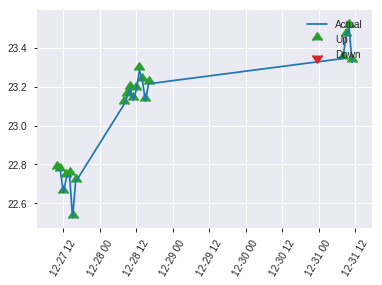


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3525439127104745
RMSE: 0.5937540843737199
LogLoss: 1.2096617129660767
Mean Per-Class Error: 0.41340759075907596
AUC: 0.5444719471947195
pr_auc: 0.5531793107932249
Gini: 0.08894389438943895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.023751534839231963: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      5    96   0.9505   (96.0/101.0)
1      1    119  0.0083   (1.0/120.0)
Total  6    215  0.4389   (97.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0237515    0.710448  214
max f2                       0.00852097   0.857143  219
max f0point5                 0.262414     0.625     127
max accuracy                 0.262414     0.59276   127
max precision                0.999353     1         0
max recall                   0.00852097   1         219
max specificity              0.999353     1         0
max absolute_mcc             0.262414     0.174749  127
max min_per_class_accuracy   0.330192     0.564356  111
max mean_per_class_accuracy  0.262414     0.586592  127

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 43.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.998892           1.22778   1.22778            0.666667         0.999101   0.666667                    0.999101            0.0166667       0.0166667                  22.7778   22.7778
    2        0.0226244                   0.99885            0.920833  1.105              0.5              0.998875   0.6                         0.99901             0.00833333      0.025                      -7.91667  10.5
    3        0.0316742                   0.998136           0.920833  1.05238            0.5              0.998586   0.571429                    0.998889            0.00833333      0.0333333                  -7.91667  5.2381
    4        0.040724                    0.997827           0         0.818519           0                0.997936   0.444444                    0.998677            0               0.0333333                  -100      -18.1481
    5        0.0542986                   0.996558           0.613889  0.767361           0.333333         0.997344   0.416667                    0.998344            0.00833333      0.0416667                  -38.6111  -23.2639
    6        0.104072                    0.989404           1.00455   0.880797           0.545455         0.993014   0.478261                    0.995795            0.05            0.0916667                  0.454545  -11.9203
    7        0.153846                    0.939163           0.669697  0.8125             0.363636         0.966877   0.441176                    0.986439            0.0333333       0.125                      -33.0303  -18.75
    8        0.20362                     0.809761           1.00455   0.859444           0.545455         0.879304   0.466667                    0.960251            0.05            0.175                      0.454545  -14.0556
    9        0.303167                    0.618412           1.33939   1.01704            0.727273         0.701448   0.552239                    0.875271            0.133333        0.308333                   33.9394   1.70398
    10       0.402715                    0.478788           1.42311   1.11742            0.772727         0.540604   0.606742                    0.792544            0.141667        0.45                       42.3106   11.7416
    11       0.502262                    0.330849           1.08826   1.11164            0.590909         0.397687   0.603604                    0.714284            0.108333        0.558333                   8.82576   11.1637
    12       0.60181                     0.252239           1.08826   1.10777            0.590909         0.281463   0.601504                    0.64269             0.108333        0.666667                   8.82576   10.7769
    13       0.701357                    0.165021           0.418561  1.00995            0.227273         0.206004   0.548387                    0.580709            0.0416667       0.708333                   -58.1439  0.994624
    14       0.800905                    0.116839           1.17197   1.03008            0.636364         0.133739   0.559322                    0.525153            0.116667        0.825                      17.197    3.00847
    15       0.900452                    0.0771971          1.08826   1.03652            0.590909         0.0987914  0.562814                    0.478018            0.108333        0.933333                   8.82576   3.65159
    16       1                           0.00697976         0.669697  1                  0.363636         0.0409977  0.542986                   

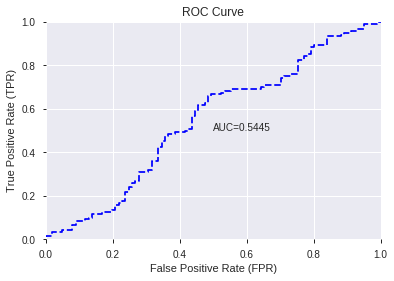

This function is available for GLM models only


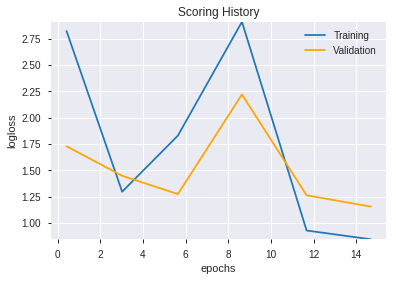

--2019-07-25 07:13:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_064634_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_064634_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLLADDERBOTTOM',
 'CDLCOUNTERATTACK',
 'CDL3BLACKCROWS',
 'CDLEVENINGDOJISTAR',
 'CDLIDENTICAL3CROWS',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLEVENINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLSTALLEDPATTERN',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_month_start',
 'CDLHANGINGMAN',
 'CDL3INSIDE',
 'CDLHAMMER',
 'CDLXSIDEGAP3METHODS',
 'is_month_end',
 'HT_TRENDMODE',
 'weekday_name',
 'CDLHARAMICROSS',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'SUB',
 'DIV',
 'CDLLONGLEGGEDDOJI',
 'hour',
 'CORREL_24',
 'CORREL_12',
 'TRANGE',
 'CORREL_14',
 'CORREL_30',
 'dayofweek',
 'EXP',
 'STOCHRSI_fastd',
 'aroondown_8',
 'Volume',
 'SINH',
 'HT_PHASOR_quadrature',
 'days_in_month',
 'CDL3OUTSIDE',
 'CDLMARUBOZU',
 'CORREL_20',
 'aroonup_12',
 'VAR_8

In [0]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_071413_model_1  0.494967  0.692384              0.480198  0.499564  0.249564

variable  relative_importance  scaled_importance    percentage
0                    CORREL_30         2.358853e-02           1.000000  1.433574e-02
1               CDL3LINESTRIKE         2.014073e-02           0.853836  1.224037e-02
2                  CDLMARUBOZU         1.965418e-02           0.833209  1.194467e-02
3           CDLMORNINGDOJISTAR         1.909814e-02           0.809637  1.160674e-02
4                  CDLLONGLINE         1.809537e-02           0.767126  1.099732e-02
...                        ...                  ...                ...           ...
1030                   MA_20_5         1.441756e-06           0.000061  8.762158e-07
1031  BBANDS_middleband_20_5_5         1.392469e-06           0.000059  8.462618e-07
1032  BBANDS_middleband_20_5_2         8.583660e-07           0.000036  5.216650e-07
1033  BBANDS_middleband_14_3_2         1.832379e-07           0.000008  1.113614e-07
1034   BBANDS_lowerband_12_1_4         7.981714e-08           0.000003  4.850822e-08

[1035 rows x 4 columns]

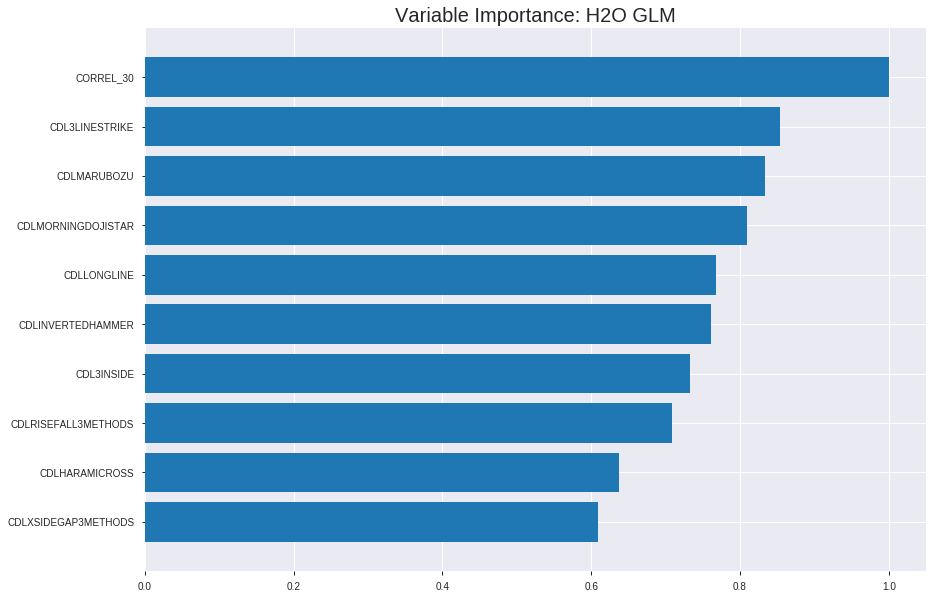

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_071413_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24291505604554592
RMSE: 0.492864135483143
LogLoss: 0.6788552194776347
Null degrees of freedom: 1543
Residual degrees of freedom: 508
Null deviance: 2137.6163902402923
Residual deviance: 2096.304917746936
AIC: 4168.304917746937
AUC: 0.6121525647383151
pr_auc: 0.618750588364273
Gini: 0.22430512947663028
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45845488637547804: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      60   679   0.9188   (679.0/739.0)
1      22   783   0.0273   (22.0/805.0)
Total  82   1462  0.454    (701.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458455     0.690781  353
max f2                       0.429621     0.845976  382
max f0point5                 0.49881      0.605065  266
max accuracy                 0.508902     0.584197  237
max precision                0.691888     1         0
max recall                   0.400961     1         394
max specificity              0.691888     1         0
max absolute_mcc             0.53712      0.167111  158
max min_per_class_accuracy   0.518786     0.577808  207
max mean_per_class_accuracy  0.518329     0.579986  209

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.622401           1.43851   1.43851            0.75             0.636565  0.75                        0.636565            0.0149068       0.0149068                  43.8509   43.8509
    2        0.0200777                   0.606742           1.27867   1.36117            0.666667         0.614647  0.709677                    0.62596             0.0124224       0.0273292                  27.8675   36.117
    3        0.0304404                   0.596445           1.31863   1.34669            0.6875           0.601281  0.702128                    0.617559            0.0136646       0.0409938                  31.8634   34.669
    4        0.0401554                   0.593312           1.27867   1.33023            0.666667         0.594643  0.693548                    0.612015            0.0124224       0.0534161                  27.8675   33.0234
    5        0.0505181                   0.59038            1.31863   1.32785            0.6875           0.591675  0.692308                    0.607842            0.0136646       0.0670807                  31.8634   32.7855
    6        0.100389                    0.577923           1.29528   1.31167            0.675325         0.583621  0.683871                    0.59581             0.0645963       0.131677                   29.5281   31.1673
    7        0.150259                    0.566519           1.19564   1.27316            0.623377         0.571637  0.663793                    0.587787            0.0596273       0.191304                   19.5644   27.3163
    8        0.20013                     0.556979           1.19564   1.25385            0.623377         0.561502  0.653722                    0.581237            0.0596273       0.250932                   19.5644   25.3846
    9        0.29987                     0.53999            1.2081    1.23863            0.62987          0.548126  0.645788                    0.570224            0.120497        0.371429                   20.8099   23.863
    10       0.400259                    0.5294             1.01469   1.18246            0.529032         0.534175  0.616505                    0.561183            0.101863        0.473292                   1.46904   18.2464
    11       0.5                         0.518831           1.00882   1.14783            0.525974         0.524214  0.598446                    0.553808            0.100621        0.573913                   0.882472  14.7826
    12       0.599741                    0.509936           0.971461  1.1185             0.506494         0.514467  0.583153                    0.547265            0.0968944       0.670807                   -2.85392  11.8495
    13       0.70013                     0.499476           0.977568  1.09829            0.509677         0.504562  0.572618                    0.541142            0.0981366       0.768944                   -2.24324  9.82883
    14       0.79987                     0.488081           0.809551  1.06228            0.422078         0.494136  0.553846                    0.535281            0.0807453       0.849689                   -19.0449  6.22838
    15       0.899611                    0.470978           0.871824  1.04117            0.454545         0.480405  0.542837                    0.529197            0.0869565       0.936646                   -12.8176  4.11673
    16       1                           0.30446            0.631088  1                  0.329032         0.451263  0.521373                    0.521373            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24651191738265904
RMSE: 0.4964996650378115
LogLoss: 0.6860863150427787
Null degrees of freedom: 440
Residual degrees of freedom: -595
Null deviance: 610.0237499842223
Residual deviance: 605.1281298677309
AIC: 2677.128129867731
AUC: 0.5624896830637174
pr_auc: 0.5960814921610385
Gini: 0.12497936612743477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49049249314565746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   198  0.9519   (198.0/208.0)
1      3    230  0.0129   (3.0/233.0)
Total  13   428  0.4558   (201.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490492     0.695915  386
max f2                       0.378873     0.848507  399
max f0point5                 0.490492     0.59126   386
max accuracy                 0.535243     0.562358  238
max precision                0.649575     1         0
max recall                   0.378873     1         399
max specificity              0.649575     1         0
max absolute_mcc             0.609013     0.146551  22
max min_per_class_accuracy   0.543808     0.540773  202
max mean_per_class_accuracy  0.535243     0.557465  238

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 54.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.629277           1.51416   1.51416            0.8              0.63596   0.8                         0.63596             0.0171674       0.0171674                  51.4163   51.4163
    2        0.0204082                   0.621286           0.473176  1.0515             0.25             0.624508  0.555556                    0.63087             0.00429185      0.0214592                  -52.6824  5.15021
    3        0.031746                    0.615849           1.8927    1.35193            1                0.618591  0.714286                    0.626485            0.0214592       0.0429185                  89.2704   35.1931
    4        0.0408163                   0.611242           1.41953   1.36695            0.75             0.613375  0.722222                    0.623571            0.0128755       0.055794                   41.9528   36.6953
    5        0.0521542                   0.60943            1.8927    1.48125            1                0.610107  0.782609                    0.620645            0.0214592       0.0772532                  89.2704   48.1247
    6        0.102041                    0.59813            1.11842   1.30386            0.590909         0.603818  0.688889                    0.612418            0.055794        0.133047                   11.8416   30.3863
    7        0.151927                    0.591102           1.20445   1.27122            0.636364         0.593749  0.671642                    0.606288            0.0600858       0.193133                   20.4448   27.1219
    8        0.201814                    0.578388           0.946352  1.19091            0.5              0.582654  0.629213                    0.600446            0.0472103       0.240343                   -5.36481  19.0915
    9        0.301587                    0.563494           0.946352  1.11001            0.5              0.56983   0.586466                    0.590317            0.0944206       0.334764                   -5.36481  11.0007
    10       0.401361                    0.552763           0.989368  1.08002            0.522727         0.55781   0.570621                    0.582237            0.0987124       0.433476                   -1.06321  8.00175
    11       0.501134                    0.543808           1.0754    1.0791             0.568182         0.548617  0.570136                    0.575543            0.107296        0.540773                   7.53999   7.90981
    12       0.600907                    0.534491           1.0754    1.07848            0.568182         0.538941  0.569811                    0.569466            0.107296        0.648069                   7.53999   7.84841
    13       0.70068                     0.527724           0.86032   1.04742            0.454545         0.530722  0.553398                    0.563949            0.0858369       0.733906                   -13.968   4.74186
    14       0.800454                    0.518324           0.774288  1.01337            0.409091         0.522582  0.535411                    0.558793            0.0772532       0.811159                   -22.5712  1.3374
    15       0.900227                    0.505573           1.03238   1.01548            0.545455         0.512242  0.536524                    0.553633            0.103004        0.914163                   3.23839   1.54809
    16       1                           0.378873           0.86032   1                  0.454545         0.487612  0.528345                    0.547046          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 07:14:15  0.000 sec   2            4         1036          1.3742            1.37414
    2019-07-25 07:14:17  1.815 sec   4            2.9       1036          1.37197           1.37356
    2019-07-25 07:14:19  3.652 sec   6            2.1       1036          1.36927           1.373
    2019-07-25 07:14:21  5.488 sec   8            1.6       1036          1.36601           1.37254
    2019-07-25 07:14:23  7.370 sec   10           1.1       1036          1.36217           1.37224
    2019-07-25 07:14:24  9.196 sec   12           0.83      1036          1.35771           1.37217
    2019-07-25 07:14:26  11.040 sec  14           0.6       1036          1.35265           1.37239
    2019-07-25 07:14:28  12.873 sec  16           0.44      1036          1.34704           1.37296
    2019-07-25 07:14:30  14.783 sec  18           0.32      1036          1.34095           1.37399
    2019-07-25 07:14:32  16.626 sec  20           0.23      1036          1.3345            1.37553
    2019-07-25 07:14:34  18.464 sec  22           0.17      1036          1.32783           1.37763

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.583710407239819)

('F1', 0.712166172106825)

('auc', 0.49496699669967)

('logloss', 0.6923841450134572)

('mean_per_class_error', 0.4421204620462047)

('rmse', 0.499564043271228)

('mse', 0.24956423332949734)

glm prediction progress: |████████████████████████████████████████████████| 100%


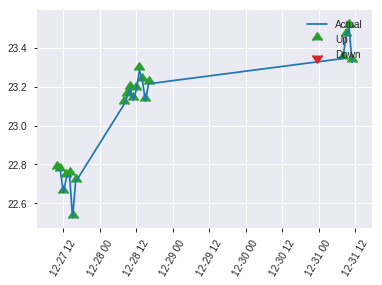


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24956423332949734
RMSE: 0.499564043271228
LogLoss: 0.6923841450134572
Null degrees of freedom: 220
Residual degrees of freedom: -815
Null deviance: 305.1498983064551
Residual deviance: 306.0337920959481
AIC: 2378.0337920959482
AUC: 0.49496699669967
pr_auc: 0.5148728161620789
Gini: -0.010066006600660038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49905503779470584: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    97   0.9604   (97.0/101.0)
1      0    120  0        (0.0/120.0)
Total  4    217  0.4389   (97.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499055     0.712166  216
max f2                       0.499055     0.860832  216
max f0point5                 0.525468     0.619048  179
max accuracy                 0.527161     0.58371   177
max precision                0.639729     1         0
max recall                   0.499055     1         216
max specificity              0.639729     1         0
max absolute_mcc             0.499055     0.147989  216
max min_per_class_accuracy   0.546371     0.475248  110
max mean_per_class_accuracy  0.527161     0.55788   177

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 55.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.628261           0.613889  0.613889           0.333333         0.632599  0.333333                    0.632599            0.00833333      0.00833333                 -38.6111  -38.6111
    2        0.0226244                   0.620573           0.920833  0.736667           0.5              0.624533  0.4                         0.629373            0.00833333      0.0166667                  -7.91667  -26.3333
    3        0.0316742                   0.614909           1.84167   1.05238            1                0.617963  0.571429                    0.626113            0.0166667       0.0333333                  84.1667   5.2381
    4        0.040724                    0.608939           0.920833  1.02315            0.5              0.612592  0.555556                    0.623108            0.00833333      0.0416667                  -7.91667  2.31481
    5        0.0542986                   0.605452           0         0.767361           0                0.607035  0.416667                    0.61909             0               0.0416667                  -100      -23.2639
    6        0.104072                    0.589726           0.837121  0.800725           0.454545         0.595694  0.434783                    0.607901            0.0416667       0.0833333                  -16.2879  -19.9275
    7        0.153846                    0.583458           1.00455   0.866667           0.545455         0.585945  0.470588                    0.600797            0.05            0.133333                   0.454545  -13.3333
    8        0.20362                     0.577565           0.837121  0.859444           0.454545         0.580001  0.466667                    0.595714            0.0416667       0.175                      -16.2879  -14.0556
    9        0.303167                    0.566351           1.08826   0.934577           0.590909         0.571039  0.507463                    0.587612            0.108333        0.283333                   8.82576   -6.54229
    10       0.402715                    0.554854           0.837121  0.910487           0.454545         0.560653  0.494382                    0.580948            0.0833333       0.366667                   -16.2879  -8.95131
    11       0.502262                    0.546371           1.17197   0.962312           0.636364         0.549371  0.522523                    0.574689            0.116667        0.483333                   17.197    -3.76877
    12       0.60181                     0.540064           1.25568   1.01084            0.681818         0.543311  0.548872                    0.569499            0.125           0.608333                   25.5682   1.08396
    13       0.701357                    0.534982           1.25568   1.04559            0.681818         0.537536  0.567742                    0.564962            0.125           0.733333                   25.5682   4.55914
    14       0.800905                    0.527569           1.17197   1.0613             0.636364         0.530935  0.576271                    0.560733            0.116667        0.85                       17.197    6.12994
    15       0.900452                    0.51808            0.669697  1.01801            0.363636         0.522276  0.552764                    0.556481            0.0666667       0.916667                   -33.0303  1.80067
    16       1                           0.488559           0.837121  1                  0.454545         0.507284  0.542986                    0.551584 

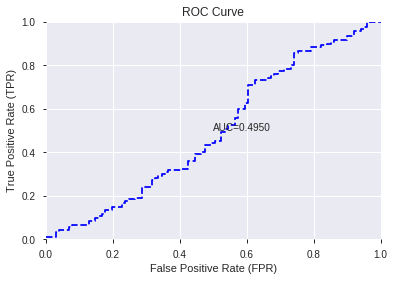

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


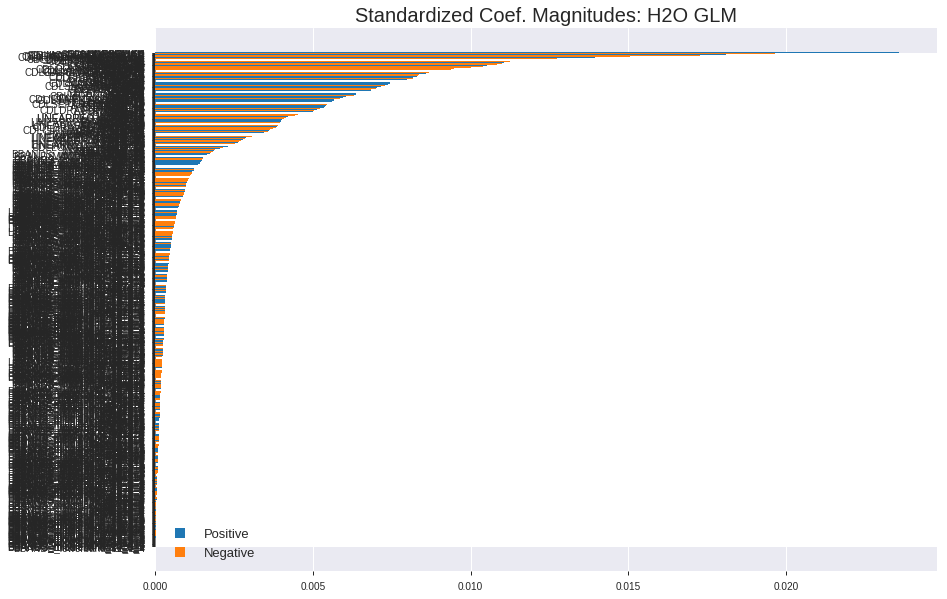

'log_likelihood'
--2019-07-25 07:15:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_071413_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_071413_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CORREL_30',
 'CDL3LINESTRIKE',
 'CDLMARUBOZU',
 'CDLMORNINGDOJISTAR',
 'CDLLONGLINE',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CDLRISEFALL3METHODS',
 'CDLHARAMICROSS',
 'CDLXSIDEGAP3METHODS',
 'HT_PHASOR_quadrature',
 'quarter',
 'HT_TRENDMODE',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'PLUS_DI_30',
 'CDL3BLACKCROWS',
 'aroonup_24',
 'PLUS_DI_24',
 'is_month_start',
 'BETA_8',
 'CORREL_24',
 'CCI_30',
 'CDL3OUTSIDE',
 'PLUS_DI_20',
 'CDLDOJISTAR',
 'STOCHRSI_fastk',
 'weekofyear',
 'week',
 'CDLSPINNINGTOP',
 'dayofyear',
 'is_month_end',
 'PLUS_DI_14',
 'CDLCOUNTERATTACK',
 'month',
 'CDLLADDERBOTTOM',
 'PLUS_DI_12',
 'MACDEXT_hist',
 'COS',
 'CDLGAPSIDESIDEWHITE',
 'CDLADVANCEBLOCK',
 'aroonup_12',
 'CDLBELTHOLD',
 'ADXR_8',
 'CORREL_8',
 'ROC_14',
 'MOM_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'day',
 'CDLRICKSHAWMAN',
 'MFI_20',
 'CDLHANGINGMAN',
 'aroonup_20',
 'PLUS_DI_8',
 'CDLTAKURI',
 'MFI_24',
 'STOCHRSI_fastd',
 'ADX_8',
 'MFI_30',
 'CDLHARAMI',
 'hour',
 'CDLMATCHINGL

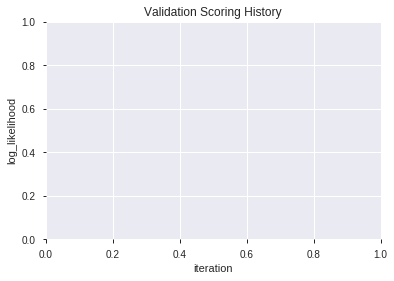

In [0]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190725_071558  0.508498  0.700529              0.490099  0.503503  0.253515
1  XGBoost_grid_1_AutoML_20190725_071558_model_2  0.506931  0.693943              0.479414  0.500395  0.250395
2  XGBoost_grid_1_AutoML_20190725_071558_model_6  0.506106  0.700182              0.500000  0.503245  0.253255
3  XGBoost_grid_1_AutoML_20190725_071558_model_4  0.503342  0.697266              0.489315  0.501975  0.251979
4  XGBoost_grid_1_AutoML_20190725_071558_model_5  0.494884  0.726856              0.500000  0.515167  0.265397
5               XGBoost_2_AutoML_20190725_071558  0.493647  0.704829              0.500000  0.505668  0.255700
6  XGBoost_grid_1_AutoML_20190725_071558_model_1  0.484901  0.709113              0.500000  0.507429  0.257485
7  XGBoost_grid_1_AutoML_20190725_071558_model_7  0.480776  0.721270              0.500000  0.512941  0.263108
8               XGBoost_1_AutoML_20190725_071558  0.471040  0.708142              0.494266  0.507101  0.257151
9  XGBoost_grid_1_AutoML_20190725_071558_model_3  0.438366  0.716402              0.495050  0.511211  0.261336

variable  relative_importance  scaled_importance  percentage
0                      MFI_8           101.362007           1.000000    0.020934
1                        BOP            83.252426           0.821338    0.017194
2                  CORREL_30            78.063354           0.770144    0.016122
3                    BETA_30            73.047348           0.720658    0.015086
4                        OBV            68.323959           0.674059    0.014111
..                       ...                  ...                ...         ...
294  BBANDS_upperband_24_2_5             1.029424           0.010156    0.000213
295               aroonup_12             0.860748           0.008492    0.000178
296   BBANDS_lowerband_8_7_4             0.856314           0.008448    0.000177
297  BBANDS_upperband_24_2_4             0.328224           0.003238    0.000068
298                   CMO_12             0.130664           0.001289    0.000027

[299 rows x 4 columns]

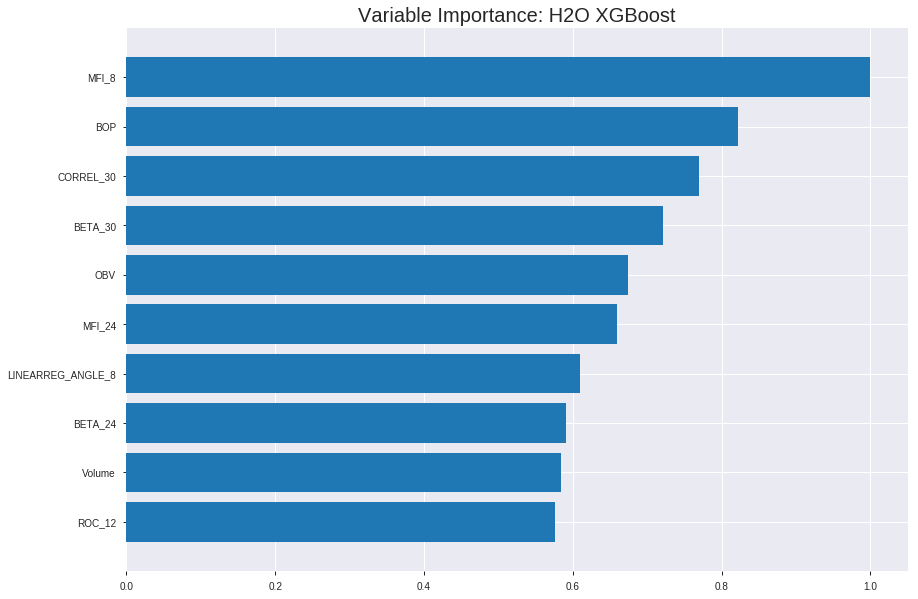

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190725_071558


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17801201838629713
RMSE: 0.4219147051079129
LogLoss: 0.5452785613046465
Mean Per-Class Error: 0.11162474050042448
AUC: 0.9558611183486161
pr_auc: 0.9597026966554465
Gini: 0.9117222366972322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5157768428325653: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      644  95   0.1286   (95.0/739.0)
1      79   726  0.0981   (79.0/805.0)
Total  723  821  0.1127   (174.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.515777     0.892989  207
max f2                       0.479715     0.93087   243
max f0point5                 0.534588     0.905207  188
max accuracy                 0.531469     0.887306  192
max precision                0.798536     1         0
max recall                   0.400115     1         317
max specificity              0.798536     1         0
max absolute_mcc             0.531469     0.776151  192
max min_per_class_accuracy   0.521556     0.883627  202
max mean_per_class_accuracy  0.531469     0.888375  192

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 52.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.719381           1.91801    1.91801            1                0.748005  1                           0.748005            0.0198758       0.0198758                  91.8012   91.8012
    2        0.0200777                   0.71109            1.91801    1.91801            1                0.715517  1                           0.732285            0.0186335       0.0385093                  91.8012   91.8012
    3        0.0304404                   0.702486           1.91801    1.91801            1                0.706688  1                           0.723571            0.0198758       0.0583851                  91.8012   91.8012
    4        0.0401554                   0.692708           1.91801    1.91801            1                0.697733  1                           0.71732             0.0186335       0.0770186                  91.8012   91.8012
    5        0.0505181                   0.685869           1.91801    1.91801            1                0.688978  1                           0.711506            0.0198758       0.0968944                  91.8012   91.8012
    6        0.100389                    0.661319           1.91801    1.91801            1                0.672583  1                           0.69217             0.0956522       0.192547                   91.8012   91.8012
    7        0.150259                    0.639296           1.91801    1.91801            1                0.648673  1                           0.677734            0.0956522       0.288199                   91.8012   91.8012
    8        0.20013                     0.619106           1.91801    1.91801            1                0.62921   1                           0.665642            0.0956522       0.383851                   91.8012   91.8012
    9        0.29987                     0.590859           1.79347    1.87659            0.935065         0.605498  0.978402                    0.645637            0.178882        0.562733                   79.3466   87.6587
    10       0.400259                    0.559065           1.6829     1.82801            0.877419         0.574872  0.953074                    0.627889            0.168944        0.731677                   68.2901   82.8009
    11       0.5                         0.527475           1.39492    1.74161            0.727273         0.542262  0.908031                    0.610808            0.13913         0.870807                   39.4918   74.1615
    12       0.599741                    0.48963            0.797096   1.58454            0.415584         0.508351  0.826134                    0.593769            0.0795031       0.950311                   -20.2904  58.4535
    13       0.70013                     0.454592           0.309357   1.40169            0.16129          0.472794  0.730805                    0.576422            0.0310559       0.981366                   -69.0643  40.1693
    14       0.79987                     0.419175           0.124546   1.24244            0.0649351        0.436941  0.647773                    0.55903             0.0124224       0.993789                   -87.5454  24.2437
    15       0.899611                    0.372211           0.0622731  1.11159            0.0324675        0.396867  0.579554                    0.541051            0.00621118      1                          -93.7727  11.1591
    16       1                           0.223461           0          1                  0                0.332705  0.521373                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.250947010020739
RMSE: 0.500946114887359
LogLoss: 0.6951047171749941
Mean Per-Class Error: 0.4627661769560911
AUC: 0.5202315120501816
pr_auc: 0.5514302387197519
Gini: 0.040463024100363176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3801968991756439: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    205  0.9856   (205.0/208.0)
1      1    232  0.0043   (1.0/233.0)
Total  4    437  0.4671   (206.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.380197     0.692537   395
max f2                       0.369096     0.849125   398
max f0point5                 0.464287     0.588235   298
max accuracy                 0.464287     0.55102    298
max precision                0.675255     1          0
max recall                   0.369096     1          398
max specificity              0.675255     1          0
max absolute_mcc             0.592836     0.0927865  38
max min_per_class_accuracy   0.506117     0.506438   192
max mean_per_class_accuracy  0.543092     0.537234   106

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.654291           0.757082  0.757082           0.4              0.662825  0.4                         0.662825            0.00858369      0.00858369                 -24.2918  -24.2918
    2        0.0204082                   0.644313           0.946352  0.841202           0.5              0.647088  0.444444                    0.655831            0.00858369      0.0171674                  -5.36481  -15.8798
    3        0.031746                    0.630383           1.51416   1.08155            0.8              0.638153  0.571429                    0.649517            0.0171674       0.0343348                  51.4163   8.15451
    4        0.0408163                   0.619785           1.41953   1.15665            0.75             0.626269  0.611111                    0.644351            0.0128755       0.0472103                  41.9528   15.6652
    5        0.0521542                   0.616818           1.13562   1.15208            0.6              0.617926  0.608696                    0.638607            0.0128755       0.0600858                  13.5622   15.2081
    6        0.102041                    0.58647            1.20445   1.17768            0.636364         0.60168   0.622222                    0.620554            0.0600858       0.120172                   20.4448   17.7682
    7        0.151927                    0.56898            1.03238   1.12997            0.545455         0.577513  0.597015                    0.606421            0.0515021       0.171674                   3.23839   12.9972
    8        0.201814                    0.558233           1.03238   1.10585            0.545455         0.563045  0.58427                     0.595699            0.0515021       0.223176                   3.23839   10.5849
    9        0.301587                    0.538168           1.03238   1.08155            0.545455         0.546277  0.571429                    0.579349            0.103004        0.32618                    3.23839   8.15451
    10       0.401361                    0.51979            0.688256  0.983778           0.363636         0.529032  0.519774                    0.566841            0.0686695       0.39485                    -31.1744  -1.62217
    11       0.501134                    0.505546           1.11842   1.01058            0.590909         0.51209   0.533937                    0.55594             0.111588        0.506438                   11.8416   1.0584
    12       0.600907                    0.489561           1.0754    1.02135            0.568182         0.49768   0.539623                    0.546267            0.107296        0.613734                   7.53999   2.13459
    13       0.70068                     0.474913           0.946352  1.01067            0.5              0.48209   0.533981                    0.537128            0.0944206       0.708155                   -5.36481  1.06671
    14       0.800454                    0.457494           1.11842   1.0241             0.590909         0.466287  0.541076                    0.528298            0.111588        0.819742                   11.8416   2.40976
    15       0.900227                    0.434769           0.817304  1.00118            0.431818         0.445101  0.528967                    0.519077            0.0815451       0.901288                   -18.2696  0.117837
    16       1                           0.357572           0.989368  1                  0.522727         0.408693  0.528345                    0.508064      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:16:08  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.478627                         0.5                0.693147              0.5               0                    1                  0.471655
    2019-07-25 07:16:09  0.642 sec   5                  0.489309         0.671952            0.788696        0.798376           1.91801          0.303756                         0.499751           0.692649              0.515393          0.53018              0.378541           0.462585
    2019-07-25 07:16:09  0.823 sec   10                 0.481773         0.657201            0.826586        0.83498            1.91801          0.25842                          0.499972           0.69309               0.504447          0.530199             1.2618             0.469388
    2019-07-25 07:16:09  1.028 sec   15                 0.471676         0.637667            0.851513        0.857295           1.91801          0.240285                         0.501559           0.696285              0.483369          0.519211             1.13562            0.469388
    2019-07-25 07:16:10  1.224 sec   20                 0.463369         0.621809            0.881362        0.885631           1.91801          0.194948                         0.502111           0.697445              0.489951          0.517569             0.757082           0.46712
    2019-07-25 07:16:10  1.411 sec   25                 0.45634          0.608516            0.901604        0.906025           1.91801          0.192358                         0.501805           0.696859              0.495388          0.525097             0.378541           0.471655
    2019-07-25 07:16:10  1.619 sec   30                 0.448252         0.59336             0.919055        0.92373            1.91801          0.170337                         0.501201           0.695615              0.503941          0.540654             1.13562            0.471655
    2019-07-25 07:16:10  1.806 sec   35                 0.441785         0.581333            0.927963        0.932391           1.91801          0.158679                         0.501288           0.695798              0.50587           0.530359             0.757082           0.471655
    2019-07-25 07:16:10  1.987 sec   40                 0.435755         0.570317            0.939128        0.942907           1.91801          0.141192                         0.500693           0.69459               0.515135          0.539582             0.757082           0.464853
    2019-07-25 07:16:11  2.178 sec   45                 0.429247         0.558492            0.948487        0.952767           1.91801          0.126295                         0.500396           0.693951              0.520159          0.558484             1.51416            0.469388
    2019-07-25 07:16:11  2.377 sec   50                 0.421915         0.545279            0.955861        0.959703           1.91801          0.112694                         0.500946           0.695105              0.520232          0.55143              0.757082           0.46712

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
MFI_8                    101.36200714111328     1.0                    0.020934007726131288
BOP                      83.25242614746094      0.8213375849154141     0.01719388734838129
CORREL_30                78.0633544921875       0.770144126916409      0.016122203103102743
BETA_30                  73.04734802246094      0.7206580659039882     0.01508626151953292
OBV                      68.32395935058594      0.6740588636476711     0.014110753459467624
---                      ---                    ---                    ---
BBANDS_upperband_24_2_5  1.0294241905212402     0.010155917582493264   0.0002126040571378666
aroonup_12               0.860748291015625      0.008491823665422449   0.00017776790222089807
BBANDS_lowerband_8_7_4   0.8563137054443359     0.008448073687532653   0.000176852039845735
BBANDS_upperband_24_2_4  0.32822418212890625    0.0032381381484678172  6.778720901830576e-05
CMO_12                   0.13066387176513672    0.0012890813377760982  2.6985638684616496e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.583710407239819)

('F1', 0.7079646017699115)

('auc', 0.5084983498349835)

('logloss', 0.7005285166435911)

('mean_per_class_error', 0.4429042904290429)

('rmse', 0.5035032267682622)

('mse', 0.2535154993660521)

xgboost prediction progress: |████████████████████████████████████████████| 100%


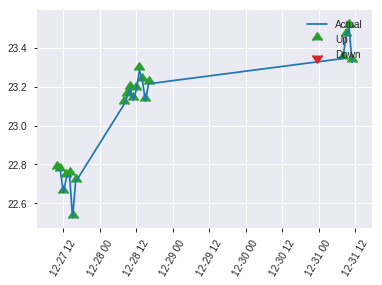


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2535154993660521
RMSE: 0.5035032267682622
LogLoss: 0.7005285166435911
Mean Per-Class Error: 0.4429042904290429
AUC: 0.5084983498349835
pr_auc: 0.5259027264400422
Gini: 0.016996699669967086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37602466344833374: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    99   0.9802   (99.0/101.0)
1      0    120  0        (0.0/120.0)
Total  2    219  0.448    (99.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376025     0.707965  218
max f2                       0.376025     0.858369  218
max f0point5                 0.450825     0.619048  179
max accuracy                 0.450825     0.58371   179
max precision                0.695366     0.666667  2
max recall                   0.376025     1         218
max specificity              0.720408     0.990099  0
max absolute_mcc             0.450825     0.146338  179
max min_per_class_accuracy   0.505775     0.49505   110
max mean_per_class_accuracy  0.450825     0.557096  179

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.693357           1.22778   1.22778            0.666667         0.707343  0.666667                    0.707343            0.0166667       0.0166667                  22.7778   22.7778
    2        0.0226244                   0.684034           0         0.736667           0                0.68527   0.4                         0.698514            0               0.0166667                  -100      -26.3333
    3        0.0316742                   0.673862           0.920833  0.789286           0.5              0.68091   0.428571                    0.693484            0.00833333      0.025                      -7.91667  -21.0714
    4        0.040724                    0.659128           0.920833  0.818519           0.5              0.668044  0.444444                    0.687831            0.00833333      0.0333333                  -7.91667  -18.1481
    5        0.0542986                   0.650582           0.613889  0.767361           0.333333         0.653447  0.416667                    0.679235            0.00833333      0.0416667                  -38.6111  -23.2639
    6        0.104072                    0.578011           0.669697  0.720652           0.363636         0.604715  0.391304                    0.643595            0.0333333       0.075                      -33.0303  -27.9348
    7        0.153846                    0.55975            1.00455   0.8125             0.545455         0.564574  0.441176                    0.618029            0.05            0.125                      0.454545  -18.75
    8        0.20362                     0.5492             1.17197   0.90037            0.636364         0.552724  0.488889                    0.602066            0.0583333       0.183333                   17.197    -9.96296
    9        0.303167                    0.531391           1.08826   0.962065           0.590909         0.53919   0.522388                    0.58142             0.108333        0.291667                   8.82576   -3.79353
    10       0.402715                    0.519377           0.837121  0.93118            0.454545         0.524496  0.505618                    0.567349            0.0833333       0.375                      -16.2879  -6.88202
    11       0.502262                    0.505775           1.25568   0.995495           0.681818         0.512135  0.540541                    0.556406            0.125           0.5                        25.5682   -0.45045
    12       0.60181                     0.489037           1.25568   1.03853            0.681818         0.497365  0.56391                     0.546639            0.125           0.625                      25.5682   3.85338
    13       0.701357                    0.473431           1.17197   1.05747            0.636364         0.479203  0.574194                    0.537068            0.116667        0.741667                   17.197    5.74731
    14       0.800905                    0.456195           1.00455   1.05089            0.545455         0.463308  0.570621                    0.5279              0.1             0.841667                   0.454545  5.08945
    15       0.900452                    0.433689           0.920833  1.03652            0.5              0.444183  0.562814                    0.518645            0.0916667       0.933333                   -7.91667  3.65159
    16       1                           0.273676           0.669697  1                  0.363636         0.406464  0.542986                    0.507477 

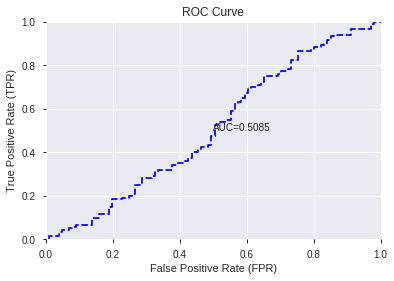

This function is available for GLM models only


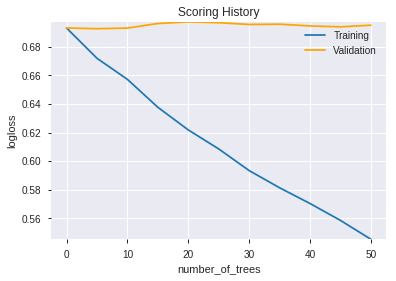

--2019-07-25 07:16:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.49.242
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.49.242|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190725_071558',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190725_071558',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_8bc5',
   'type

['MFI_8',
 'BOP',
 'CORREL_30',
 'BETA_30',
 'OBV',
 'MFI_24',
 'LINEARREG_ANGLE_8',
 'BETA_24',
 'Volume',
 'ROC_12',
 'STOCHF_fastk',
 'HT_DCPERIOD',
 'SUB',
 'MOM_8',
 'PLUS_DI_14',
 'MFI_12',
 'BETA_8',
 'PLUS_DI_30',
 'HT_PHASOR_quadrature',
 'MFI_20',
 'CORREL_14',
 'ATR_12',
 'MOM_12',
 'TRANGE',
 'PLUS_DI_12',
 'BETA_14',
 'CORREL_8',
 'STOCH_slowk',
 'NATR_24',
 'DIV',
 'BETA_20',
 'ADXR_12',
 'ROC_20',
 'PLUS_DI_24',
 'MFI_14',
 'WILLR_8',
 'COS',
 'SIN',
 'ROC_14',
 'NATR_8',
 'STOCHRSI_fastk',
 'MFI_30',
 'PLUS_DM_20',
 'BBANDS_upperband_20_0_5',
 'LINEARREG_ANGLE_30',
 'MACDFIX_signal_24',
 'ADX_24',
 'CCI_8',
 'hour',
 'PLUS_DM_8',
 'LINEARREG_ANGLE_20',
 'LINEARREG_SLOPE_20',
 'DX_8',
 'CORREL_20',
 'DX_12',
 'STOCH_slowd',
 'SAR_0.3',
 'NATR_14',
 'MACDFIX_hist_8',
 'MINUS_DI_30',
 'PLUS_DM_24',
 'PPO',
 'PLUS_DM_14',
 'MACDFIX_hist_20',
 'AROONOSC_12',
 'CCI_14',
 'MACDEXT_hist',
 'BBANDS_upperband_12_1_5',
 'MOM_24',
 'MOM_30',
 'PLUS_DI_20',
 'ROCP_20',
 'aroondown_2

In [0]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [0]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

111

['BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_14_5_3',
 'BBANDS_middleband_14_5_5',
 'BBANDS_lowerband_14_7_5',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_middleband_20_2_2',
 'BBANDS_middleband_20_2_5',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_upperband_20_6_3',
 'SAR_0.24',
 'BBANDS_lowerband_24_7_5',
 'MA_30_2',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'DX_8',
 'MACDFIX_8',
 'MOM_8',
 'PLUS_DM_8',
 'ROCP_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'aroonup_12',
 'AROONOSC_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'MOM_12',
 'PLUS_DI_12',
 'ROC_12',
 'ROCP_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'ADX_14',
 'ADXR_14',
 'aroondown_14',
 'DX_14',
 'MACDFIX_hist_14',
 'MFI_14',
 'MINUS_DM_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'aroondown_20',
 'aroonup_20',
 'CCI_20',
 'CMO_20',
 'MACDFIX_signal_20',
 'MOM_20',
 'PLUS_DM_20',
 'ROC_20',
 'ROCR_20',
 'WILLR_20',
 'DX_24',
 'MACDFIX_signal_24',
 'MINUS_DI_24',
 'MOM_24',
 'PLUS_DM_24',
 'R

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_071850_model_3  0.510726  1.134345              0.483581  0.609812  0.371871
1  DeepLearning_grid_1_AutoML_20190725_071850_model_2  0.508581  1.623475              0.500000  0.631246  0.398471
2  DeepLearning_grid_1_AutoML_20190725_071850_model_9  0.500000  0.693480              0.500000  0.500167  0.250167
3               DeepLearning_1_AutoML_20190725_071850  0.499752  0.828147              0.500000  0.543426  0.295312
4  DeepLearning_grid_1_AutoML_20190725_071850_model_6  0.498927  0.715099              0.500000  0.510651  0.260764
5  DeepLearning_grid_1_AutoML_20190725_071850_model_1  0.485314  2.154819              0.490099  0.663594  0.440358
6  DeepLearning_grid_1_AutoML_20190725_071850_model_7  0.475619  1.174093              0.495050  0.614430  0.377524
7  DeepLearning_grid_1_AutoML_20190725_071850_model_8  0.470462  0.691562              0.500000  0.499207  0.249208
8  DeepLearning_grid_1_AutoML_20190725_071850_model_4  0.464769  1.210202              0.490099  0.617702  0.381555
9  DeepLearning_grid_1_AutoML_20190725_071850_model_5  0.405528  0.744345              0.495050  0.524356  0.274949

variable  relative_importance  scaled_importance  percentage
0       HT_TRENDMODE             1.000000           1.000000    0.023597
1     STOCHRSI_fastk             0.580261           0.580261    0.013692
2            CDLDOJI             0.573478           0.573478    0.013532
3          aroonup_8             0.546900           0.546900    0.012905
4            ADXR_14             0.537891           0.537891    0.012692
..               ...                  ...                ...         ...
106           ROC_12             0.300613           0.300613    0.007093
107           RSI_24             0.297346           0.297346    0.007016
108        MACD_hist             0.296742           0.296742    0.007002
109           CMO_20             0.293538           0.293538    0.006927
110  MACDFIX_hist_14             0.283294           0.283294    0.006685

[111 rows x 4 columns]

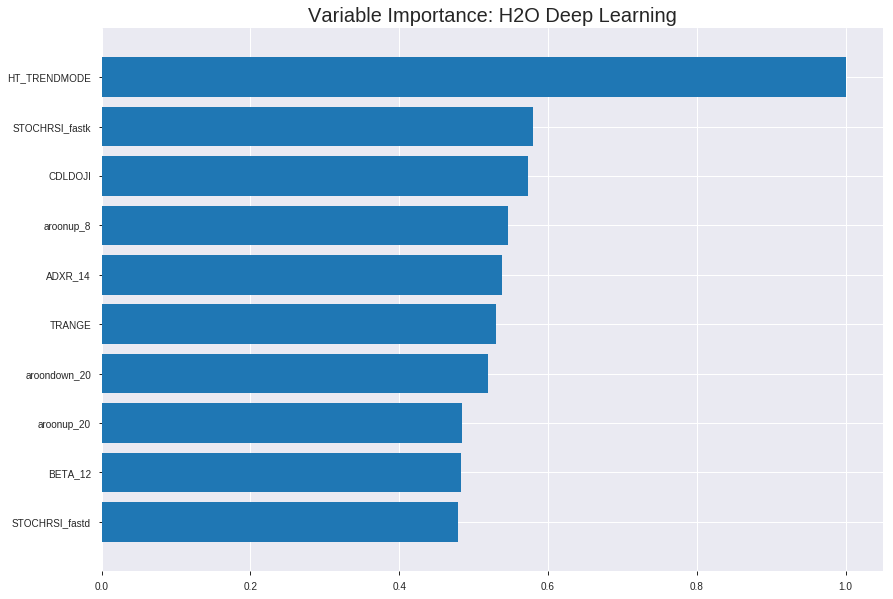

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_071850_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2819103654027128
RMSE: 0.5309523193307595
LogLoss: 0.8410834518789054
Mean Per-Class Error: 0.40115650661041025
AUC: 0.6165600652215937
pr_auc: 0.652499093079156
Gini: 0.23312013044318736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.009027256966950623: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    735   0.9946   (735.0/739.0)
1      1    804   0.0012   (1.0/805.0)
Total  5    1539  0.4767   (736.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00902726   0.686007  397
max f2                       0.00522266   0.845233  398
max f0point5                 0.328002     0.606993  237
max accuracy                 0.470405     0.593264  177
max precision                0.976574     1         0
max recall                   0.00522266   1         398
max specificity              0.976574     1         0
max absolute_mcc             0.587954     0.216864  127
max min_per_class_accuracy   0.348792     0.586335  228
max mean_per_class_accuracy  0.470405     0.598843  177

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 37.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.90734            1.79814   1.79814            0.9375           0.936862   0.9375                      0.936862            0.0186335       0.0186335                  79.8137   79.8137
    2        0.0200777                   0.886073           1.79014   1.79427            0.933333         0.895858   0.935484                    0.917022            0.0173913       0.0360248                  79.0145   79.427
    3        0.0304404                   0.863415           1.31863   1.63235            0.6875           0.875978   0.851064                    0.903049            0.0136646       0.0496894                  31.8634   63.2351
    4        0.0401554                   0.849603           1.53441   1.60866            0.8              0.8571     0.83871                     0.891933            0.0149068       0.0645963                  53.441    60.8656
    5        0.0505181                   0.830023           0.959006  1.47539            0.5              0.840109   0.769231                    0.881302            0.00993789      0.0745342                  -4.09938  47.5394
    6        0.100389                    0.757199           1.41983   1.44779            0.74026          0.793654   0.754839                    0.837761            0.0708075       0.145342                   41.9827   44.779
    7        0.150259                    0.68595            1.44474   1.44678            0.753247         0.718405   0.75431                     0.798147            0.0720497       0.217391                   44.4737   44.6777
    8        0.20013                     0.635043           1.29528   1.40903            0.675325         0.661751   0.734628                    0.764158            0.0645963       0.281988                   29.5281   40.9025
    9        0.29987                     0.526762           1.09601   1.30491            0.571429         0.579861   0.680346                    0.702859            0.109317        0.391304                   9.60071   30.4911
    10       0.400259                    0.443623           0.952819  1.2166             0.496774         0.488388   0.634304                    0.649067            0.0956522       0.486957                   -4.71809  21.6603
    11       0.5                         0.348311           0.971461  1.1677             0.506494         0.394402   0.608808                    0.598266            0.0968944       0.583851                   -2.85392  16.7702
    12       0.599741                    0.256688           0.822005  1.11021            0.428571         0.30465    0.578834                    0.549436            0.0819876       0.665839                   -17.7995  11.021
    13       0.70013                     0.180175           0.791954  1.06458            0.412903         0.216481   0.555042                    0.501695            0.0795031       0.745342                   -20.8046  6.45767
    14       0.79987                     0.10808            0.859369  1.03899            0.448052         0.141049   0.5417                      0.456724            0.0857143       0.831056                   -14.0631  3.89881
    15       0.899611                    0.0569814          0.921642  1.02598            0.480519         0.0810484  0.534917                    0.415072            0.0919255       0.922981                   -7.83577  2.59778
    16       1                           0.00336158         0.767205  1                  0.4              0.0350496  0.521373                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3307999596554748
RMSE: 0.5751521187090202
LogLoss: 0.9301638423544089
Mean Per-Class Error: 0.48249215912842525
AUC: 0.49052905249257184
pr_auc: 0.5239205980930264
Gini: -0.018941895014856325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03397765765118382: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    202  0.9712   (202.0/208.0)
1      1    232  0.0043   (1.0/233.0)
Total  7    434  0.4603   (203.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0339777    0.695652  392
max f2                       0.0297182    0.850986  395
max f0point5                 0.0339777    0.589132  392
max accuracy                 0.0460088    0.539683  387
max precision                0.801202     0.695652  21
max recall                   0.0297182    1         395
max specificity              0.94957      0.995192  0
max absolute_mcc             0.0297182    0.101259  395
max min_per_class_accuracy   0.334741     0.476395  199
max mean_per_class_accuracy  0.801202     0.517508  21

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 37.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.907012           0.757082  0.757082           0.4              0.936936   0.4                         0.936936            0.00858369      0.00858369                 -24.2918  -24.2918
    2        0.0204082                   0.872661           1.41953   1.0515             0.75             0.890692   0.555556                    0.916383            0.0128755       0.0214592                  41.9528   5.15021
    3        0.031746                    0.846144           1.13562   1.08155            0.6              0.853111   0.571429                    0.893786            0.0128755       0.0343348                  13.5622   8.15451
    4        0.0408163                   0.830665           1.41953   1.15665            0.75             0.839317   0.611111                    0.881682            0.0128755       0.0472103                  41.9528   15.6652
    5        0.0521542                   0.801202           1.8927    1.31666            1                0.810342   0.695652                    0.866173            0.0214592       0.0686695                  89.2704   31.6664
    6        0.102041                    0.717183           0.86032   1.09356            0.454545         0.752937   0.577778                    0.810813            0.0429185       0.111588                   -13.968   9.35622
    7        0.151927                    0.663117           0.602224  0.932227           0.318182         0.692322   0.492537                    0.771906            0.0300429       0.141631                   -39.7776  -6.77727
    8        0.201814                    0.586377           1.29048   1.02078            0.681818         0.62388    0.539326                    0.735315            0.0643777       0.206009                   29.048    2.07841
    9        0.301587                    0.489007           0.817304  0.953467           0.431818         0.533984   0.503759                    0.668709            0.0815451       0.287554                   -18.2696  -4.65326
    10       0.401361                    0.403869           0.903336  0.941005           0.477273         0.44798    0.497175                    0.613839            0.0901288       0.377682                   -9.66641  -5.89947
    11       0.501134                    0.330779           1.03238   0.959198           0.545455         0.371003   0.506787                    0.565491            0.103004        0.480687                   3.23839   -4.08017
    12       0.600907                    0.27544            1.29048   1.0142             0.681818         0.304442   0.535849                    0.522147            0.128755        0.609442                   29.048    1.42036
    13       0.70068                     0.215697           0.86032   0.992291           0.454545         0.246045   0.524272                    0.482832            0.0858369       0.695279                   -13.968   -0.770865
    14       0.800454                    0.143026           1.0754    1.00265            0.568182         0.177968   0.529745                    0.444832            0.107296        0.802575                   7.53999   0.265049
    15       0.900227                    0.09286            0.946352  0.996411           0.5              0.118002   0.526448                    0.408609            0.0944206       0.896996                   -5.36481  -0.358915
    16       1                           0.00610529         1.03238   1                  0.545455         0.0566329  0.528345         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:20:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 07:20:50  1 min 59.334 sec  3512 obs/sec      10        1             15440      0.572907         1.14141             -0.315294      0.568473        0.606935           1.55839          0.478627                         0.634285           1.40795               -0.614457        0.47851           0.50438              1.51416            0.46712
    2019-07-25 07:20:58  2 min  7.109 sec  3852 obs/sec      30        3             46320      0.557491         0.956195            -0.24546       0.577158        0.616629           1.79814          0.477332                         0.582743           1.00358               -0.362736        0.492778          0.520765             0.757082           0.46712
    2019-07-25 07:21:05  2 min 13.989 sec  4116 obs/sec      50        5             77200      0.530952         0.841083            -0.129706      0.61656         0.652499           1.79814          0.476684                         0.575152           0.930164              -0.327466        0.490529          0.523921             0.757082           0.460317
    2019-07-25 07:21:11  2 min 20.329 sec  4332 obs/sec      70        7             108080     0.522944         0.836306            -0.095883      0.643492        0.682111           1.91801          0.475389                         0.58241            0.988135              -0.361182        0.49836           0.527684             1.51416            0.464853
    2019-07-25 07:21:17  2 min 26.301 sec  4516 obs/sec      90        9             138960     0.5145           0.820778            -0.0607782     0.672563        0.712384           1.91801          0.47215                          0.580869           0.965889              -0.353988        0.487898          0.526216             1.51416            0.469388
    2019-07-25 07:21:23  2 min 31.941 sec  4684 obs/sec      110       11            169840     0.485696         0.720671            0.0546704      0.711712        0.749378           1.91801          0.384067                         0.587931           1.01989               -0.38711         0.492623          0.517045             0.757082           0.46712
    2019-07-25 07:21:28  2 min 37.369 sec  4833 obs/sec      130       13            200720     0.466446         0.662957            0.12812        0.744327        0.775191           1.91801          0.338083                         0.583599           1.01308               -0.366741        0.491973          0.516929             1.13562            0.464853
    2019-07-25 07:21:28  2 min 37.521 sec  4832 obs/sec      130       13            200720     0.530952         0.841083            -0.129706      0.61656         0.652499           1.79814          0.476684                         0.575152           0.930164              -0.327466        0.490529          0.523921             0.757082           0.460317

Variable Importances: 


variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  --------------------
HT_TRENDMODE     1.0                    1.0                  0.02359668106018488
STOCHRSI_fastk   0.5802612900733948     0.5802612900733948   0.013692240593433318
CDLDOJI          0.5734776258468628     0.5734776258468628   0.013532168632260458
aroonup_8        0.5468997359275818     0.5468997359275818   0.01290501864058248
ADXR_14          0.5378906726837158     0.5378906726837158   0.012692434648565941
---              ---                    ---                  ---
ROC_12           0.3006129562854767     0.3006129562854767   0.007093468052027692
RSI_24           0.2973460853099823     0.2973460853099823   0.007016380739554177
MACD_hist        0.29674187302589417    0.29674187302589417  0.007002123334993903
CMO_20           0.29353827238082886    0.29353827238082886  0.006926528992328094
MACDFIX_hist_14  0.28329408168792725    0.28329408168792725  0.00668480009182798


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5565610859728507)

('F1', 0.7065868263473052)

('auc', 0.5107260726072608)

('logloss', 1.1343448054546796)

('mean_per_class_error', 0.4738036303630363)

('rmse', 0.6098119081275412)

('mse', 0.3718705632941527)

deeplearning prediction progress: |███████████████████████████████████████| 100%


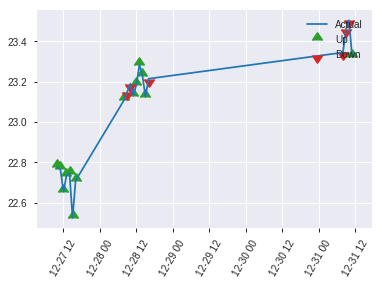


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3718705632941527
RMSE: 0.6098119081275412
LogLoss: 1.1343448054546796
Mean Per-Class Error: 0.4738036303630363
AUC: 0.5107260726072608
pr_auc: 0.5473593881948917
Gini: 0.021452145214521545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.015656762580717774: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      5    96   0.9505   (96.0/101.0)
1      2    118  0.0167   (2.0/120.0)
Total  7    214  0.4434   (98.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0156568    0.706587   213
max f2                       0.00439212   0.857143   219
max f0point5                 0.0156568    0.604508   213
max accuracy                 0.0156568    0.556561   213
max precision                0.924173     1          0
max recall                   0.00439212   1          219
max specificity              0.924173     1          0
max absolute_mcc             0.0156568    0.0934062  213
max min_per_class_accuracy   0.20238      0.516667   108
max mean_per_class_accuracy  0.234186     0.526196   95

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 24.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.784838           1.22778   1.22778            0.666667         0.847998   0.666667                    0.847998            0.0166667       0.0166667                  22.7778   22.7778
    2        0.0226244                   0.752593           0         0.736667           0                0.760369   0.4                         0.812947            0               0.0166667                  -100      -26.3333
    3        0.0316742                   0.731572           0.920833  0.789286           0.5              0.742525   0.428571                    0.792826            0.00833333      0.025                      -7.91667  -21.0714
    4        0.040724                    0.69477            1.84167   1.02315            1                0.720389   0.555556                    0.776729            0.0166667       0.0416667                  84.1667   2.31481
    5        0.0542986                   0.67081            1.22778   1.07431            0.666667         0.681369   0.583333                    0.752889            0.0166667       0.0583333                  22.7778   7.43056
    6        0.104072                    0.543736           1.17197   1.12101            0.636364         0.588008   0.608696                    0.674033            0.0583333       0.116667                   17.197    12.1014
    7        0.153846                    0.482971           0.837121  1.02917            0.454545         0.514226   0.558824                    0.622331            0.0416667       0.158333                   -16.2879  2.91667
    8        0.20362                     0.407013           0.837121  0.982222           0.454545         0.429919   0.533333                    0.575297            0.0416667       0.2                        -16.2879  -1.77778
    9        0.303167                    0.324103           1.08826   1.01704            0.590909         0.368797   0.552239                    0.507491            0.108333        0.308333                   8.82576   1.70398
    10       0.402715                    0.243717           1.00455   1.01395            0.545455         0.285654   0.550562                    0.452655            0.1             0.408333                   0.454545  1.39513
    11       0.502262                    0.199747           1.08826   1.02868            0.590909         0.222039   0.558559                    0.406947            0.108333        0.516667                   8.82576   2.86787
    12       0.60181                     0.143604           0.753409  0.983145           0.409091         0.172976   0.533835                    0.368245            0.075           0.591667                   -24.6591  -1.68546
    13       0.701357                    0.0990515          1.00455   0.986183           0.545455         0.115725   0.535484                    0.332404            0.1             0.691667                   0.454545  -1.38172
    14       0.800905                    0.0629541          1.25568   1.01968            0.681818         0.0809591  0.553672                    0.301151            0.125           0.816667                   25.5682   1.96798
    15       0.900452                    0.0412056          0.920833  1.00875            0.5              0.0496358  0.547739                    0.273345            0.0916667       0.908333                   -7.91667  0.875209
    16       1                           0.00206493         0.920833  1                  0.5              0.0220363  0.542986             

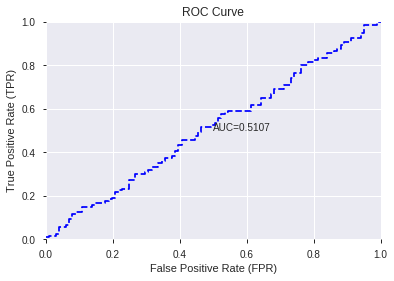

This function is available for GLM models only


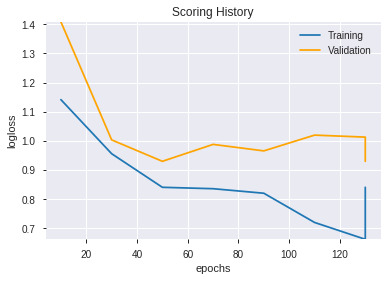

--2019-07-25 07:29:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_071850_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_071850_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'aroonup_8',
 'ADXR_14',
 'TRANGE',
 'aroondown_20',
 'aroonup_20',
 'BETA_12',
 'STOCHRSI_fastd',
 'HT_PHASOR_inphase',
 'aroondown_14',
 'CORREL_8',
 'ADX_14',
 'STOCHF_fastk',
 'CORREL_12',
 'AROONOSC_8',
 'BETA_8',
 'CDLSPINNINGTOP',
 'DX_8',
 'MFI_14',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'aroonup_12',
 'AROONOSC_12',
 'ADOSC',
 'STOCHF_fastd',
 'MFI_30',
 'OBV',
 'NATR_8',
 'NATR_30',
 'STOCH_slowd',
 'DX_24',
 'BBANDS_lowerband_24_7_5',
 'HT_PHASOR_quadrature',
 'DX_14',
 'CDLHIKKAKE',
 'VAR_8',
 'PLUS_DI_12',
 'ATR_24',
 'ULTOSC',
 'ATR_8',
 'MINUS_DM_12',
 'PLUS_DM_8',
 'ATR_20',
 'PLUS_DI_14',
 'BBANDS_upperband_20_6_3',
 'MINUS_DI_12',
 'ROC_14',
 'ROCR_20',
 'WILLR_8',
 'MINUS_DM_14',
 'MACDFIX_signal_20',
 'MACDEXT_hist',
 'WILLR_12',
 'ROCP_8',
 'CCI_8',
 'CDLENGULFING',
 'ROC_20',
 'BBANDS_middleband_20_2_2',
 'WILLR_20',
 'WILLR_30',
 'PLUS_DI_30',
 'PLUS_DM_24',
 'ROCR_24',
 'MINUS_DI_24',
 'APO',
 'MA_30_2',
 'MACDFIX_signa

In [0]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_073025_model_1  0.50165  0.694573               0.49505  0.500691  0.250692

variable  relative_importance  scaled_importance  percentage
0                CDLMARUBOZU             0.053717           1.000000    0.040076
1                CDLLONGLINE             0.051957           0.967233    0.038763
2                 PLUS_DI_30             0.035116           0.653732    0.026199
3                 aroonup_20             0.035032           0.652158    0.026136
4               HT_TRENDMODE             0.030700           0.571512    0.022904
..                       ...                  ...                ...         ...
106              STOCH_slowd             0.000574           0.010686    0.000428
107        MACDFIX_signal_20             0.000295           0.005496    0.000220
108  BBANDS_lowerband_14_4_4             0.000256           0.004760    0.000191
109                 SAR_0.24             0.000250           0.004662    0.000187
110               PLUS_DM_14             0.000167           0.003112    0.000125

[111 rows x 4 columns]

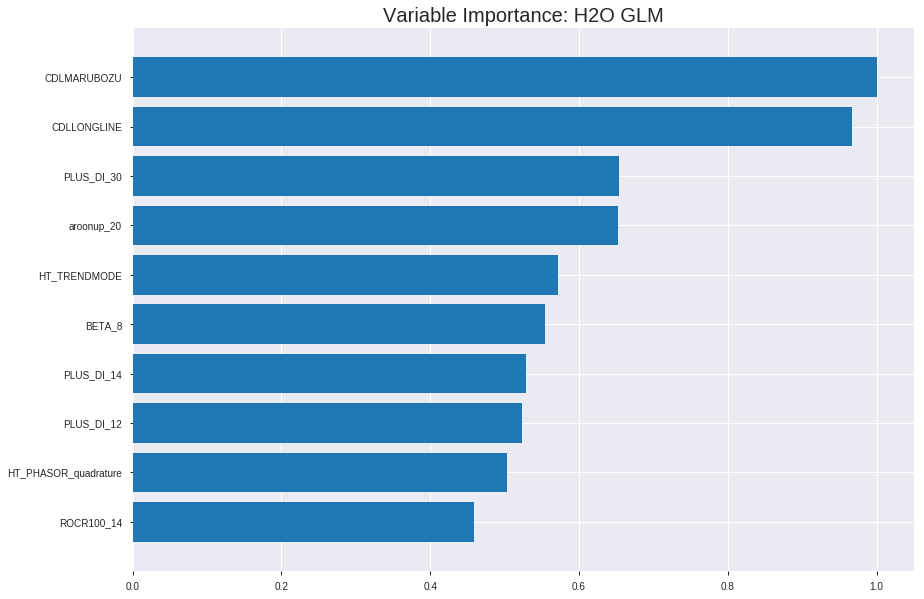

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_073025_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24454701185704805
RMSE: 0.4945169479977891
LogLoss: 0.6821583582017207
Null degrees of freedom: 1543
Residual degrees of freedom: 1432
Null deviance: 2137.6163902402923
Residual deviance: 2106.5050101269135
AIC: 2330.5050101269135
AUC: 0.5926987115373301
pr_auc: 0.6026454333006872
Gini: 0.18539742307466023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4213904440279661: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    733   0.9919   (733.0/739.0)
1      1    804   0.0012   (1.0/805.0)
Total  7    1537  0.4754   (734.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42139      0.686593  392
max f2                       0.414781     0.845588  395
max f0point5                 0.509158     0.598849  237
max accuracy                 0.511377     0.578368  230
max precision                0.629204     0.785714  11
max recall                   0.414781     1         395
max specificity              0.655535     0.998647  0
max absolute_mcc             0.511377     0.152178  230
max min_per_class_accuracy   0.518439     0.570186  209
max mean_per_class_accuracy  0.511377     0.575294  230

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.626883           1.43851   1.43851            0.75             0.638856  0.75                        0.638856            0.0149068       0.0149068                  43.8509   43.8509
    2        0.0200777                   0.618374           1.27867   1.36117            0.666667         0.622535  0.709677                    0.630958            0.0124224       0.0273292                  27.8675   36.117
    3        0.0304404                   0.608616           1.55839   1.42831            0.8125           0.613127  0.744681                    0.624888            0.0161491       0.0434783                  55.8385   42.8307
    4        0.0401554                   0.602176           1.02294   1.33023            0.533333         0.604815  0.693548                    0.620032            0.00993789      0.0534161                  2.294     33.0234
    5        0.0505181                   0.594487           1.67826   1.40162            0.875            0.597668  0.730769                    0.615444            0.0173913       0.0708075                  67.8261   40.1624
    6        0.100389                    0.578076           1.19564   1.2993             0.623377         0.585664  0.677419                    0.60065             0.0596273       0.130435                   19.5644   29.9299
    7        0.150259                    0.566786           1.17073   1.25663            0.61039          0.572915  0.655172                    0.591445            0.0583851       0.18882                    17.0735   25.6629
    8        0.20013                     0.557491           1.02128   1.19798            0.532468         0.562036  0.624595                    0.584116            0.0509317       0.239752                   2.12793   19.7982
    9        0.29987                     0.541604           1.14583   1.18063            0.597403         0.549289  0.615551                    0.572532            0.114286        0.354037                   14.5826   18.0634
    10       0.400259                    0.528504           1.12606   1.16695            0.587097         0.535372  0.608414                    0.563212            0.113043        0.467081                   12.6059   16.6946
    11       0.5                         0.518484           1.00882   1.1354             0.525974         0.523442  0.591969                    0.555279            0.100621        0.567702                   0.882472  13.5404
    12       0.599741                    0.509072           1.02128   1.11642            0.532468         0.513658  0.582073                    0.548357            0.101863        0.669565                   2.12793   11.6424
    13       0.70013                     0.497256           0.866199  1.08055            0.451613         0.503349  0.563367                    0.541904            0.0869565       0.756522                   -13.3801  8.05454
    14       0.79987                     0.48471            0.909188  1.05918            0.474026         0.490738  0.552227                    0.535523            0.0906832       0.847205                   -9.08123  5.91777
    15       0.899611                    0.468757           0.734823  1.02322            0.383117         0.477607  0.533477                    0.529102            0.0732919       0.920497                   -26.5177  2.32161
    16       1                           0.395133           0.791954  1                  0.412903         0.45211   0.521373                    0.521373          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24620843411581045
RMSE: 0.49619394808462797
LogLoss: 0.685472414557895
Null degrees of freedom: 440
Residual degrees of freedom: 329
Null deviance: 610.0237499842223
Residual deviance: 604.5866696400634
AIC: 828.5866696400634
AUC: 0.5550614889402443
pr_auc: 0.5957716873689191
Gini: 0.11012297788048864
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4369510936525461: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    203  0.976    (203.0/208.0)
1      0    233  0        (0.0/233.0)
Total  5    436  0.4603   (203.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436951     0.696562  394
max f2                       0.436951     0.851608  394
max f0point5                 0.457429     0.592344  384
max accuracy                 0.547904     0.55102   119
max precision                0.64875      1         0
max recall                   0.436951     1         394
max specificity              0.64875      1         0
max absolute_mcc             0.584482     0.15388   33
max min_per_class_accuracy   0.517481     0.528846  212
max mean_per_class_accuracy  0.547904     0.564017  119

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.616421           1.51416   1.51416            0.8              0.631925  0.8                         0.631925            0.0171674       0.0171674                  51.4163   51.4163
    2        0.0204082                   0.605522           0.946352  1.2618             0.5              0.609996  0.666667                    0.622179            0.00858369      0.0257511                  -5.36481  26.1803
    3        0.031746                    0.598382           1.51416   1.35193            0.8              0.602229  0.714286                    0.615054            0.0171674       0.0429185                  51.4163   35.1931
    4        0.0408163                   0.594928           1.8927    1.4721             1                0.596799  0.777778                    0.610997            0.0171674       0.0600858                  89.2704   47.2103
    5        0.0521542                   0.591375           1.13562   1.39896            0.6              0.593066  0.73913                     0.607099            0.0128755       0.0729614                  13.5622   39.8955
    6        0.102041                    0.57856            1.20445   1.30386            0.636364         0.584582  0.688889                    0.596091            0.0600858       0.133047                   20.4448   30.3863
    7        0.151927                    0.566257           1.11842   1.24297            0.590909         0.572269  0.656716                    0.588269            0.055794        0.188841                   11.8416   24.297
    8        0.201814                    0.557014           1.11842   1.21218            0.590909         0.560899  0.640449                    0.581503            0.055794        0.244635                   11.8416   21.2181
    9        0.301587                    0.542829           1.11842   1.18116            0.590909         0.550287  0.62406                     0.571176            0.111588        0.356223                   11.8416   18.1161
    10       0.401361                    0.530453           0.817304  1.09071            0.431818         0.536239  0.576271                    0.562491            0.0815451       0.437768                   -18.2696  9.07107
    11       0.501134                    0.517491           0.903336  1.05341            0.477273         0.523848  0.556561                    0.554797            0.0901288       0.527897                   -9.66641  5.34053
    12       0.600907                    0.505141           0.903336  1.02849            0.477273         0.51072   0.543396                    0.547479            0.0901288       0.618026                   -9.66641  2.84881
    13       0.70068                     0.495382           0.903336  1.01067            0.477273         0.499352  0.533981                    0.540626            0.0901288       0.708155                   -9.66641  1.06671
    14       0.800454                    0.485212           1.0754    1.01874            0.568182         0.490425  0.538244                    0.534369            0.107296        0.815451                   7.53999   1.87358
    15       0.900227                    0.473402           0.989368  1.01548            0.522727         0.479918  0.536524                    0.528334            0.0987124       0.914163                   -1.06321  1.54809
    16       1                           0.416924           0.86032   1                  0.454545         0.456746  0.528345                    0.521191          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 07:30:25  0.000 sec   2            4         112           1.37942           1.3759
    2019-07-25 07:30:25  0.016 sec   3            2.9       112           1.37861           1.37521
    2019-07-25 07:30:25  0.033 sec   4            2.1       112           1.37763           1.37449
    2019-07-25 07:30:25  0.063 sec   6            1.6       112           1.37647           1.37382
    2019-07-25 07:30:25  0.092 sec   8            1.1       112           1.37508           1.37314
    2019-07-25 07:30:25  0.123 sec   10           0.83      112           1.37344           1.37249
    2019-07-25 07:30:25  0.157 sec   12           0.6       112           1.37154           1.37189
    2019-07-25 07:30:25  0.188 sec   14           0.44      112           1.36937           1.3714
    2019-07-25 07:30:25  0.214 sec   16           0.32      112           1.36695           1.37105
    2019-07-25 07:30:25  0.246 sec   18           0.23      112           1.36432           1.37094
    2019-07-25 07:30:25  0.278 sec   20           0.17      112           1.36152           1.37114
    2019-07-25 07:30:25  0.309 sec   22           0.12      112           1.35863           1.37171
    2019-07-25 07:30:25  0.342 sec   24           0.089     112           1.35573           1.37271
    2019-07-25 07:30:25  0.374 sec   26           0.065     112           1.35291           1.37416
    2019-07-25 07:30:25  0.403 sec   28           0.047     112           1.35025           1.37607

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5610859728506787)

('F1', 0.7058823529411764)

('auc', 0.5016501650165016)

('logloss', 0.6945727817105357)

('mean_per_class_error', 0.46687293729372936)

('rmse', 0.5006911308972496)

('mse', 0.2506916085591667)

glm prediction progress: |████████████████████████████████████████████████| 100%


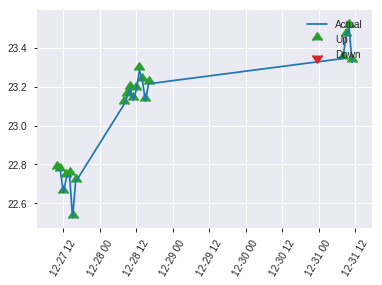


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2506916085591667
RMSE: 0.5006911308972496
LogLoss: 0.6945727817105357
Null degrees of freedom: 220
Residual degrees of freedom: 109
Null deviance: 305.1498983064551
Residual deviance: 307.0011695160568
AIC: 531.0011695160567
AUC: 0.5016501650165016
pr_auc: 0.5281152752606064
Gini: 0.0033003300330032292
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43024519575730624: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    100  0.9901   (100.0/101.0)
1      0    120  0        (0.0/120.0)
Total  1    220  0.4525   (100.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430245     0.705882  219
max f2                       0.430245     0.857143  219
max f0point5                 0.478438     0.60446   182
max accuracy                 0.478438     0.561086  182
max precision                0.514141     0.574257  100
max recall                   0.430245     1         219
max specificity              0.617402     0.990099  0
max absolute_mcc             0.556207     0.099869  32
max min_per_class_accuracy   0.510151     0.516667  109
max mean_per_class_accuracy  0.478438     0.533127  182

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 51.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.59046            0.613889  0.613889           0.333333         0.601402  0.333333                    0.601402            0.00833333      0.00833333                 -38.6111  -38.6111
    2        0.0226244                   0.586444           0.920833  0.736667           0.5              0.587131  0.4                         0.595694            0.00833333      0.0166667                  -7.91667  -26.3333
    3        0.0316742                   0.584441           0.920833  0.789286           0.5              0.585545  0.428571                    0.592794            0.00833333      0.025                      -7.91667  -21.0714
    4        0.040724                    0.579549           0.920833  0.818519           0.5              0.583747  0.444444                    0.590784            0.00833333      0.0333333                  -7.91667  -18.1481
    5        0.0542986                   0.575425           1.22778   0.920833           0.666667         0.576722  0.5                         0.587268            0.0166667       0.05                       22.7778   -7.91667
    6        0.104072                    0.563951           0.669697  0.800725           0.363636         0.569819  0.434783                    0.578923            0.0333333       0.0833333                  -33.0303  -19.9275
    7        0.153846                    0.555361           0.837121  0.8125             0.454545         0.558653  0.441176                    0.572365            0.0416667       0.125                      -16.2879  -18.75
    8        0.20362                     0.547832           1.33939   0.941296           0.727273         0.551607  0.511111                    0.567291            0.0666667       0.191667                   33.9394   -5.87037
    9        0.303167                    0.530805           1.00455   0.962065           0.545455         0.538261  0.522388                    0.557758            0.1             0.291667                   0.454545  -3.79353
    10       0.402715                    0.521899           1.17197   1.01395            0.636364         0.525372  0.550562                    0.549753            0.116667        0.408333                   17.197    1.39513
    11       0.502262                    0.509662           1.08826   1.02868            0.590909         0.515325  0.558559                    0.542929            0.108333        0.516667                   8.82576   2.86787
    12       0.60181                     0.498922           0.920833  1.01084            0.5              0.502876  0.548872                    0.536304            0.0916667       0.608333                   -7.91667  1.08396
    13       0.701357                    0.49107            1.00455   1.00995            0.545455         0.495219  0.548387                    0.530472            0.1             0.708333                   0.454545  0.994624
    14       0.800905                    0.481023           1.17197   1.03008            0.636364         0.486237  0.559322                    0.524974            0.116667        0.825                      17.197    3.00847
    15       0.900452                    0.469434           0.669697  0.990243           0.363636         0.475213  0.537688                    0.519473            0.0666667       0.891667                   -33.0303  -0.975712
    16       1                           0.423156           1.08826   1                  0.590909         0.456593  0.542986                    0.51321

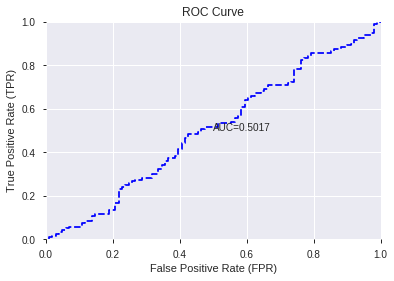

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


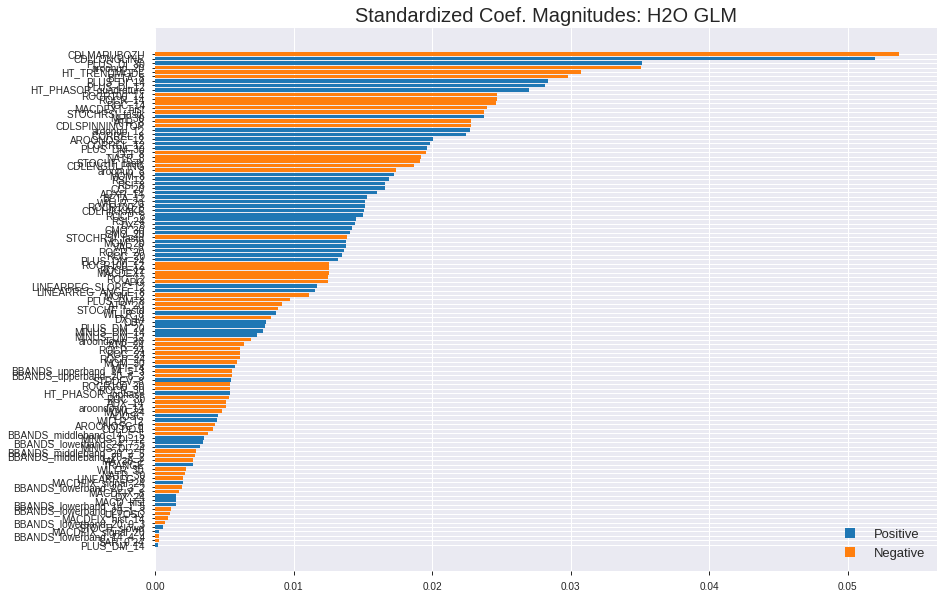

'log_likelihood'
--2019-07-25 07:30:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_073025_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_073025_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLMARUBOZU',
 'CDLLONGLINE',
 'PLUS_DI_30',
 'aroonup_20',
 'HT_TRENDMODE',
 'BETA_8',
 'PLUS_DI_14',
 'PLUS_DI_12',
 'HT_PHASOR_quadrature',
 'ROCR100_14',
 'ROCR_14',
 'ROC_14',
 'MACDEXT_hist',
 'STOCHRSI_fastk',
 'MFI_30',
 'ATR_8',
 'CDLSPINNINGTOP',
 'aroonup_12',
 'CORREL_8',
 'AROONOSC_12',
 'CORREL_12',
 'PLUS_DM_30',
 'CCI_8',
 'NATR_8',
 'STOCHF_fastk',
 'CDLENGULFING',
 'aroonup_8',
 'MOM_8',
 'RSI_12',
 'RSI_8',
 'CCI_20',
 'ADXR_14',
 'BETA_12',
 'WILLR_20',
 'ROCR100_8',
 'CDLHIKKAKE',
 'ROCP_8',
 'RSI_24',
 'DX_8',
 'CMO_30',
 'CMO_20',
 'STOCHRSI_fastd',
 'MOM_20',
 'VAR_8',
 'ROCR_20',
 'ROC_20',
 'PLUS_DM_24',
 'ROCR100_12',
 'ROCP_12',
 'MACDEXT',
 'ROC_12',
 'APO',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_8',
 'MOM_12',
 'PLUS_DM_8',
 'ATR_20',
 'STOCHF_fastd',
 'WILLR_8',
 'DX_14',
 'OBV',
 'PLUS_DM_20',
 'MINUS_DM_14',
 'MINUS_DM_12',
 'aroondown_20',
 'ATR_24',
 'ROCR_24',
 'ROC_24',
 'ROCP_24',
 'MOM_30',
 'MFI_14',
 'BBANDS_upperband_14_5_3',
 'BBANDS_upper

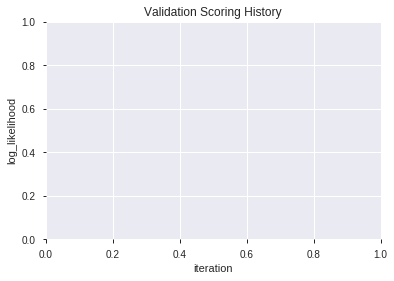

In [0]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_073133_model_1  0.526856  0.708838              0.500000  0.506919  0.256967
1  XGBoost_grid_1_AutoML_20190725_073133_model_5  0.516089  0.742615              0.464563  0.521339  0.271794
2  XGBoost_grid_1_AutoML_20190725_073133_model_3  0.512129  0.707176              0.490099  0.506666  0.256710
3  XGBoost_grid_1_AutoML_20190725_073133_model_4  0.496700  0.698096              0.479414  0.502403  0.252409
4  XGBoost_grid_1_AutoML_20190725_073133_model_2  0.490182  0.701756              0.500000  0.504216  0.254233
5               XGBoost_2_AutoML_20190725_073133  0.479455  0.708424              0.500000  0.507384  0.257438
6  XGBoost_grid_1_AutoML_20190725_073133_model_7  0.475413  0.717481              0.484365  0.511658  0.261794
7  XGBoost_grid_1_AutoML_20190725_073133_model_6  0.470462  0.723421              0.495050  0.514494  0.264704
8               XGBoost_1_AutoML_20190725_073133  0.465759  0.726132              0.500000  0.515630  0.265874
9               XGBoost_3_AutoML_20190725_073133  0.454373  0.724740              0.500000  0.514636  0.264850

variable  relative_importance  scaled_importance  percentage
0                    BETA_12           189.284943           1.000000    0.043613
1                     TRANGE           118.948586           0.628410    0.027407
2                     BETA_8           117.790749           0.622293    0.027140
3                     NATR_8           110.011406           0.581195    0.025348
4                 PLUS_DI_30           106.920654           0.564866    0.024636
..                       ...                  ...                ...         ...
98                   ROCP_24             5.347435           0.028251    0.001232
99   BBANDS_lowerband_20_1_3             3.998666           0.021125    0.000921
100                   ROCP_8             3.701435           0.019555    0.000853
101                ROCR100_8             3.536769           0.018685    0.000815
102                  MA_30_2             1.435842           0.007586    0.000331

[103 rows x 4 columns]

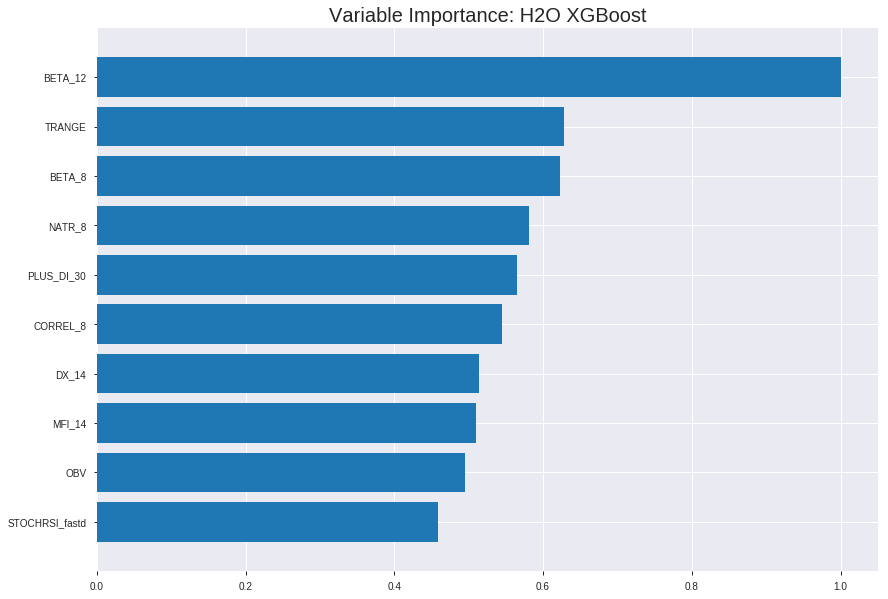

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_073133_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1830719239450764
RMSE: 0.42786904999669745
LogLoss: 0.5554311871232264
Mean Per-Class Error: 0.13952041956984007
AUC: 0.9315971726102925
pr_auc: 0.9343811998258003
Gini: 0.863194345220585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5135225355625153: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      620  119  0.161    (119.0/739.0)
1      95   710  0.118    (95.0/805.0)
Total  715  829  0.1386   (214.0/1544.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513523     0.869033  209
max f2                       0.467015     0.912186  253
max f0point5                 0.530752     0.873184  192
max accuracy                 0.513523     0.861399  209
max precision                0.851677     1         0
max recall                   0.357539     1         348
max specificity              0.851677     1         0
max absolute_mcc             0.513523     0.722272  209
max min_per_class_accuracy   0.520003     0.85521   203
max mean_per_class_accuracy  0.513523     0.86048   209

Gains/Lift Table: Avg response rate: 52.14 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.745267           1.91801    1.91801            1                0.771951  1                           0.771951            0.0198758       0.0198758                  91.8012   91.8012
    2        0.0200777                   0.728751           1.91801    1.91801            1                0.734677  1                           0.753915            0.0186335       0.0385093                  91.8012   91.8012
    3        0.0304404                   0.710902           1.91801    1.91801            1                0.718076  1                           0.741715            0.0198758       0.0583851                  91.8012   91.8012
    4        0.0401554                   0.695761           1.91801    1.91801            1                0.704185  1                           0.732635            0.0186335       0.0770186                  91.8012   91.8012
    5        0.0505181                   0.688945           1.91801    1.91801            1                0.692523  1                           0.724407            0.0198758       0.0968944                  91.8012   91.8012
    6        0.100389                    0.65996            1.8931     1.90564            0.987013         0.671869  0.993548                    0.698307            0.0944099       0.191304                   89.3103   90.5638
    7        0.150259                    0.635299           1.8931     1.90148            0.987013         0.648074  0.991379                    0.681635            0.0944099       0.285714                   89.3103   90.1478
    8        0.20013                     0.616727           1.81838    1.88077            0.948052         0.625883  0.980583                    0.667742            0.0906832       0.376398                   81.8375   88.0769
    9        0.29987                     0.582362           1.71874    1.82688            0.896104         0.599909  0.952484                    0.64518             0.171429        0.547826                   71.8738   82.6876
    10       0.400259                    0.553847           1.54678    1.75663            0.806452         0.568462  0.915858                    0.625938            0.15528         0.703106                   54.6784   75.6626
    11       0.5                         0.524964           1.37001    1.6795             0.714286         0.539137  0.875648                    0.608623            0.136646        0.839752                   37.0009   67.9503
    12       0.599741                    0.492712           0.809551   1.53482            0.422078         0.5096    0.800216                    0.592155            0.0807453       0.920497                   -19.0449  53.4824
    13       0.70013                     0.457636           0.532094   1.39105            0.277419         0.474859  0.725254                    0.575336            0.0534161       0.973913                   -46.7906  39.1047
    14       0.79987                     0.41976            0.16191    1.23778            0.0844156        0.438512  0.645344                    0.558275            0.0161491       0.990062                   -83.809   23.7778
    15       0.899611                    0.374478           0.0871824  1.11021            0.0454545        0.397485  0.578834                    0.540448            0.00869565      0.998758                   -91.2818  11.021
    16       1                           0.243708           0.0123743  1                  0.00645161       0.333762  0.521373                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2530918732047703
RMSE: 0.5030823721864743
LogLoss: 0.6997591476120775
Mean Per-Class Error: 0.45868067018818093
AUC: 0.5275978045559591
pr_auc: 0.5539943093369294
Gini: 0.05519560911191812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28430214524269104: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    208  1        (208.0/208.0)
1      0    233  0        (0.0/233.0)
Total  0    441  0.4717   (208.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.284302     0.691395   399
max f2                       0.284302     0.848507   399
max f0point5                 0.463044     0.584325   265
max accuracy                 0.463329     0.55102    263
max precision                0.788733     1          0
max recall                   0.284302     1          399
max specificity              0.788733     1          0
max absolute_mcc             0.463329     0.0879698  263
max min_per_class_accuracy   0.504748     0.51073    196
max mean_per_class_accuracy  0.463329     0.541319   263

Gains/Lift Table: Avg response rate: 52.83 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113379                   0.722059           1.13562   1.13562            0.6              0.746661  0.6                         0.746661            0.0128755       0.0128755                  13.5622   13.5622
    2        0.0204082                   0.691381           0.473176  0.841202           0.25             0.704579  0.444444                    0.727958            0.00429185      0.0171674                  -52.6824  -15.8798
    3        0.031746                    0.675628           1.51416   1.08155            0.8              0.682275  0.571429                    0.711643            0.0171674       0.0343348                  51.4163   8.15451
    4        0.0408163                   0.651499           1.41953   1.15665            0.75             0.664068  0.611111                    0.701071            0.0128755       0.0472103                  41.9528   15.6652
    5        0.0521542                   0.643275           1.51416   1.23437            0.8              0.647085  0.652174                    0.689334            0.0171674       0.0643777                  51.4163   23.4372
    6        0.102041                    0.618708           0.946352  1.09356            0.5              0.631074  0.577778                    0.660852            0.0472103       0.111588                   -5.36481  9.35622
    7        0.151927                    0.596106           1.03238   1.07347            0.545455         0.604961  0.567164                    0.6425              0.0515021       0.16309                    3.23839   7.34738
    8        0.201814                    0.577089           1.29048   1.12712            0.681818         0.587103  0.595506                    0.628806            0.0643777       0.227468                   29.048    12.7116
    9        0.301587                    0.548825           0.774288  1.01039            0.409091         0.560586  0.533835                    0.606237            0.0772532       0.304721                   -22.5712  1.03908
    10       0.401361                    0.527793           1.24746   1.06932            0.659091         0.536814  0.564972                    0.588979            0.124464        0.429185                   24.7464   6.93242
    11       0.501134                    0.504255           0.817304  1.01915            0.431818         0.513754  0.538462                    0.574002            0.0815451       0.51073                    -18.2696  1.91482
    12       0.600907                    0.482535           1.11842   1.03563            0.590909         0.491995  0.54717                     0.560386            0.111588        0.622318                   11.8416   3.56304
    13       0.70068                     0.457109           1.03238   1.03517            0.545455         0.470895  0.546926                    0.547643            0.103004        0.725322                   3.23839   3.51681
    14       0.800454                    0.429852           0.86032   1.01337            0.454545         0.444322  0.535411                    0.534765            0.0858369       0.811159                   -13.968   1.3374
    15       0.900227                    0.393847           0.817304  0.991643           0.431818         0.412242  0.523929                    0.521185            0.0815451       0.892704                   -18.2696  -0.835667
    16       1                           0.284302           1.0754    1                  0.568182         0.366534  0.528345                    0.505755       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:31:36  0.013 sec   0                  0.5              0.693147            0.5             0                  1                0.478627                         0.5                0.693147              0.5               0                    1                  0.471655
    2019-07-25 07:31:36  0.113 sec   5                  0.487631         0.668643            0.784906        0.793484           1.91801          0.311528                         0.4996             0.692348              0.523523          0.539889             0.757082           0.469388
    2019-07-25 07:31:36  0.165 sec   10                 0.478            0.649792            0.820696        0.82712            1.91801          0.26943                          0.500576           0.694336              0.509533          0.540288             0.757082           0.471655
    2019-07-25 07:31:36  0.222 sec   15                 0.468528         0.631518            0.850574        0.858493           1.91801          0.224093                         0.500335           0.693881              0.518509          0.537856             0.378541           0.471655
    2019-07-25 07:31:37  0.275 sec   20                 0.460842         0.616806            0.866887        0.874151           1.91801          0.224741                         0.501161           0.695553              0.513887          0.537076             1.51416            0.471655
    2019-07-25 07:31:37  0.328 sec   25                 0.453583         0.603093            0.886782        0.891507           1.91801          0.193005                         0.500697           0.694608              0.519654          0.543208             1.51416            0.471655
    2019-07-25 07:31:37  0.380 sec   30                 0.446746         0.590322            0.902269        0.905192           1.91801          0.175518                         0.500323           0.693878              0.526917          0.546302             1.13562            0.471655
    2019-07-25 07:31:37  0.431 sec   35                 0.441803         0.581071            0.908264        0.910762           1.91801          0.165803                         0.500334           0.693901              0.529187          0.551115             1.13562            0.471655
    2019-07-25 07:31:37  0.485 sec   40                 0.438357         0.574672            0.913703        0.915966           1.91801          0.159326                         0.500977           0.695208              0.526308          0.54993              1.13562            0.460317
    2019-07-25 07:31:37  0.538 sec   45                 0.433211         0.565222            0.922193        0.924328           1.91801          0.15544                          0.502774           0.698969              0.519602          0.545935             1.13562            0.46712
    2019-07-25 07:31:37  0.593 sec   50                 0.427869         0.555431            0.931597        0.934381           1.91801          0.138601                         0.503082           0.699759              0.527598          0.553994             1.13562            0.471655

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BETA_12                  189.28494262695312     1.0                   0.043613262630921974
TRANGE                   118.9485855102539      0.6284101833957303    0.027407018368383832
BETA_8                   117.7907485961914      0.6222932841960703    0.027140240437102184
NATR_8                   110.01140594482422     0.5811947026427616    0.025347797206059366
PLUS_DI_30               106.920654296875       0.564866136804112     0.02463565517575204
---                      ---                    ---                   ---
ROCP_24                  5.347434997558594      0.028250715156447677  0.0012321058596295206
BBANDS_lowerband_20_1_3  3.9986660480499268     0.021125114298872597  0.0009213351580249758
ROCP_8                   3.7014353275299072     0.01955483239268945   0.0008528500408460254
ROCR100_8                3.536769390106201      0.018684895591914795  0.0008149092586815363
MA_30_2                  1.4358420372009277     0.007585611498061504  0.00033083326648109787


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5565610859728507)

('F1', 0.7038123167155426)

('auc', 0.5268564356435643)

('logloss', 0.7088377883658398)

('mean_per_class_error', 0.45057755775577557)

('rmse', 0.5069190892857981)

('mse', 0.25696696308234296)

xgboost prediction progress: |████████████████████████████████████████████| 100%


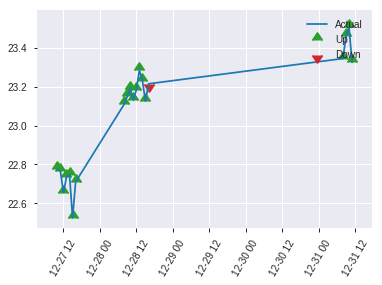


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25696696308234296
RMSE: 0.5069190892857981
LogLoss: 0.7088377883658398
Mean Per-Class Error: 0.45057755775577557
AUC: 0.5268564356435643
pr_auc: 0.5554216523088304
Gini: 0.05371287128712865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2563484311103821: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    101  1        (101.0/101.0)
1      0    120  0        (0.0/120.0)
Total  0    221  0.457    (101.0/221.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.256348     0.703812  218
max f2                       0.256348     0.85592   218
max f0point5                 0.341677     0.599385  211
max accuracy                 0.463805     0.556561  140
max precision                0.792835     1         0
max recall                   0.256348     1         218
max specificity              0.792835     1         0
max absolute_mcc             0.539723     0.110718  58
max min_per_class_accuracy   0.487147     0.524752  109
max mean_per_class_accuracy  0.539723     0.549422  58

Gains/Lift Table: Avg response rate: 54.30 %, avg score: 49.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0135747                   0.769512           0.613889  0.613889           0.333333         0.783556  0.333333                    0.783556            0.00833333      0.00833333                 -38.6111  -38.6111
    2        0.0226244                   0.738225           0.920833  0.736667           0.5              0.747593  0.4                         0.769171            0.00833333      0.0166667                  -7.91667  -26.3333
    3        0.0361991                   0.713264           0.613889  0.690625           0.333333         0.71701   0.375                       0.74961             0.00833333      0.025                      -38.6111  -30.9375
    4        0.040724                    0.700111           0         0.613889           0                0.712848  0.333333                    0.745526            0               0.025                      -100      -38.6111
    5        0.0542986                   0.656833           1.22778   0.767361           0.666667         0.671258  0.416667                    0.726959            0.0166667       0.0416667                  22.7778   -23.2639
    6        0.104072                    0.616022           1.33939   1.04094            0.727273         0.630781  0.565217                    0.680961            0.0666667       0.108333                   33.9394   4.0942
    7        0.153846                    0.577227           1.17197   1.08333            0.636364         0.590836  0.588235                    0.651803            0.0583333       0.166667                   17.197    8.33333
    8        0.20362                     0.55617            1.17197   1.105              0.636364         0.563689  0.6                         0.630264            0.0583333       0.225                      17.197    10.5
    9        0.303167                    0.533305           1.17197   1.12699            0.636364         0.543467  0.61194                     0.601763            0.116667        0.341667                   17.197    12.699
    10       0.402715                    0.515526           0.837121  1.05534            0.454545         0.525107  0.573034                    0.582815            0.0833333       0.425                      -16.2879  5.53371
    11       0.502262                    0.487147           1.00455   1.04527            0.545455         0.500841  0.567568                    0.566568            0.1             0.525                      0.454545  4.52703
    12       0.60181                     0.476396           0.920833  1.02469            0.5              0.482302  0.556391                    0.552629            0.0916667       0.616667                   -7.91667  2.46867
    13       0.701357                    0.449021           0.920833  1.00995            0.5              0.460441  0.548387                    0.539544            0.0916667       0.708333                   -7.91667  0.994624
    14       0.800905                    0.423322           0.837121  0.988465           0.454545         0.436436  0.536723                    0.526729            0.0833333       0.791667                   -16.2879  -1.15348
    15       0.900452                    0.388555           1.00455   0.990243           0.545455         0.4048    0.537688                    0.513249            0.1             0.891667                   0.454545  -0.975712
    16       1                           0.256348           1.08826   1                  0.590909         0.3525    0.542986                    0.497247     

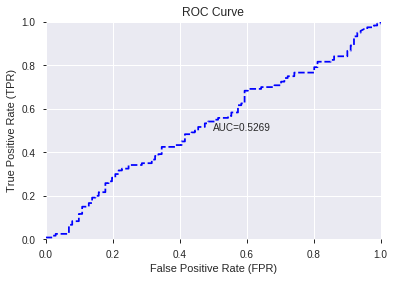

This function is available for GLM models only


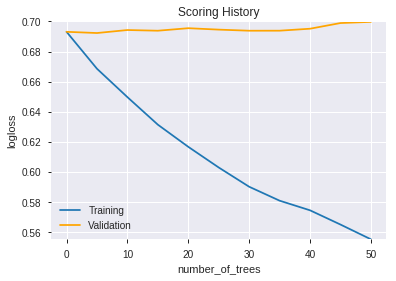

--2019-07-25 07:31:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_073133_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_073133_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8bc5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BETA_12',
 'TRANGE',
 'BETA_8',
 'NATR_8',
 'PLUS_DI_30',
 'CORREL_8',
 'DX_14',
 'MFI_14',
 'OBV',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'ROC_20',
 'PLUS_DM_8',
 'STOCH_slowd',
 'DX_8',
 'PLUS_DM_20',
 'ADOSC',
 'BBANDS_lowerband_14_7_5',
 'ADX_14',
 'AROONOSC_12',
 'ROC_14',
 'STOCHF_fastk',
 'HT_PHASOR_inphase',
 'PLUS_DI_14',
 'BBANDS_lowerband_14_4_4',
 'MOM_20',
 'aroonup_20',
 'MOM_24',
 'LINEARREG_SLOPE_12',
 'STDDEV_8',
 'PLUS_DM_14',
 'NATR_30',
 'BBANDS_lowerband_24_7_5',
 'PLUS_DM_24',
 'ROC_24',
 'SAR_0.24',
 'MINUS_DI_24',
 'MACDFIX_8',
 'MOM_12',
 'BBANDS_upperband_20_6_3',
 'PLUS_DM_30',
 'MACDEXT_hist',
 'ROC_30',
 'ROC_12',
 'ATR_8',
 'MINUS_DI_12',
 'MOM_8',
 'BBANDS_upperband_14_5_3',
 'AROONOSC_8',
 'RSI_12',
 'MOM_30',
 'LINEARREG_ANGLE_8',
 'RSI_8',
 'ATR_24',
 'MINUS_DM_14',
 'ADXR_14',
 'PLUS_DI_12',
 'WILLR_8',
 'RSI_24',
 'DX_24',
 'CCI_8',
 'MINUS_DM_12',
 'APO',
 'ULTOSC',
 'MACDFIX_signal_24',
 'aroondown_14',
 'WILLR_12',
 'aroondown_20',
 'ROCR_14',
 

In [0]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [0]:
  # Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.593
GLM             0.584
XGBoost         0.597
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.584    0.584
DLF          0.557  0.548    0.597
Fwe          0.593  0.584    0.584
RFE          0.557  0.561    0.557
XGBF         0.548  0.548    0.597





F1


DeepLearning    0.710
GLM             0.712
XGBoost         0.710
dtype: float64

DeepLearning    GLM  XGBoost
All          0.708  0.712    0.708
DLF          0.706  0.706    0.710
Fwe          0.710  0.712    0.708
RFE          0.707  0.706    0.704
XGBF         0.706  0.706    0.710





auc


DeepLearning    0.551
GLM             0.502
XGBoost         0.574
dtype: float64

DeepLearning    GLM  XGBoost
All          0.543  0.495    0.508
DLF          0.551  0.485    0.574
Fwe          0.544  0.495    0.508
RFE          0.511  0.502    0.527
XGBF         0.528  0.485    0.574





logloss


DeepLearning    1.210
GLM             0.695
XGBoost         0.709
dtype: float64

DeepLearning    GLM  XGBoost
All          0.689  0.692    0.701
DLF          0.728  0.695    0.690
Fwe          1.210  0.692    0.701
RFE          1.134  0.695    0.709
XGBF         0.780  0.695    0.690





mean_per_class_error


DeepLearning    0.474
GLM             0.475
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.438  0.442    0.443
DLF          0.432  0.475    0.411
Fwe          0.413  0.442    0.443
RFE          0.474  0.467    0.451
XGBF         0.446  0.475    0.411





rmse


DeepLearning    0.610
GLM             0.501
XGBoost         0.507
dtype: float64

DeepLearning    GLM  XGBoost
All          0.498  0.500    0.504
DLF          0.512  0.501    0.498
Fwe          0.594  0.500    0.504
RFE          0.610  0.501    0.507
XGBF         0.533  0.501    0.498





mse


DeepLearning    0.372
GLM             0.251
XGBoost         0.257
dtype: float64

DeepLearning    GLM  XGBoost
All          0.248  0.250    0.254
DLF          0.263  0.251    0.248
Fwe          0.353  0.250    0.254
RFE          0.372  0.251    0.257
XGBF         0.284  0.251    0.248

{'F1':       DeepLearning    GLM  XGBoost
 All          0.708    NaN      NaN
 DLF          0.706    NaN      NaN
 DLF            NaN  0.706      NaN
 DLF            NaN    NaN    0.710
 All            NaN  0.712      NaN
 All            NaN    NaN    0.708
 XGBF         0.706    NaN      NaN
 XGBF           NaN  0.706      NaN
 XGBF           NaN    NaN    0.710
 Fwe          0.710    NaN      NaN
 Fwe            NaN  0.712      NaN
 Fwe            NaN    NaN    0.708
 RFE          0.707    NaN      NaN
 RFE            NaN  0.706      NaN
 RFE            NaN    NaN    0.704,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.570    NaN      NaN
 DLF          0.557    NaN      NaN
 DLF            NaN  0.548      NaN
 DLF            NaN    NaN    0.597
 All            NaN  0.584      NaN
 All            NaN    NaN    0.584
 XGBF         0.548    NaN      NaN
 XGBF           NaN  0.548      NaN
 XGBF           NaN    NaN    0.597
 Fwe          0.593    NaN      NaN
 Fwe     